**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


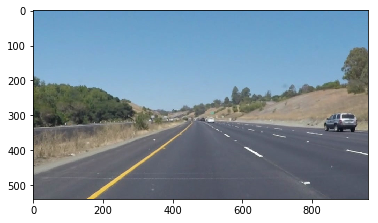

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
os.listdir("test_images/")


['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

0.651234567901
leftline
0.624664879357
leftline
0.624040920716
leftline
0.653266331658
leftline
0.65
leftline
-0.726708074534
rightline
-0.69696969697
rightline
-0.723684210526
rightline
-0.701219512195
rightline
60.0
310 425
474 310
931.0
466 298
626 402


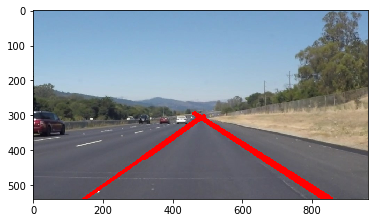

In [10]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


# Read in and grayscale the image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50 #50
high_threshold = 150 #150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 #  1 distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 150 # 5 minimum number of pixels making up a line
max_line_gap = 50    # 1 maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image,(x1,y1),(x2,y2),(255,0,0),10)
        slope=(y2-y1)/(x2-x1)
        print (slope)
        if slope > 0:
            print ("leftline")
            leftline =[[x1, y1, x2, y2]]
        else :
            print ("rightline")
            rightline =[[x1, y1, x2, y2]]
# cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
#print (x1, y1)
#print (x2, y2)
#print (lines)
#print ("--------")
#print (line)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

# extrapolate for right line
for x1,y1,x2,y2 in rightline:
    yl=600
    a=np.subtract(yl,y1)
    b=np.subtract(x2,x1)
    c=np.multiply(a,b)
    d=np.subtract(y2, y1)
    e=np.divide(c,d)
    f=np.add(e, x1)
    xl=np.around(f)
print (xl)

print (x1, y1)
print (x2, y2)
#xl=np.around[[np.multiply[(yl-y1),(x2-x1)]/(y2-y1)]+x1]

#print (xl)
rightline =[[x1, y1, xl.astype(int), yl]]
#draw_lines(image, lines, [255, 0, 0], 2)
#
for x1,y1,x2,y2 in rightline:
   cv2.line(image,(x1,y1),(x2,y2),(255,0,0),10)
color_edges = np.dstack((edges, edges, edges)) 
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

# extrapolate for left line
for x1,y1,x2,y2 in leftline:
    yl=600
    a=np.subtract(yl,y1)
    b=np.subtract(x2,x1)
    c=np.multiply(a,b)
    d=np.subtract(y2, y1)
    e=np.divide(c,d)
    f=np.add(e, x1)
    xl=np.around(f)
print (xl)

print (x1, y1)
print (x2, y2)
#xl=np.around[[np.multiply[(yl-y1),(x2-x1)]/(y2-y1)]+x1]

#print (xl)
leftline =[[x1, y1, xl.astype(int), yl]]
#draw_lines(image, lines, [255, 0, 0], 2)
#
for x1,y1,x2,y2 in leftline:
   cv2.line(image,(x1,y1),(x2,y2),(255,0,0),10)
color_edges = np.dstack((edges, edges, edges)) 
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [88]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 50 #50
    high_threshold = 150 #150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 
    
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 #  1 distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 150 # 5 minimum number of pixels making up a line
    max_line_gap = 50    # 1 maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    # Iterate over the output "lines" and draw lines on a blank image
    lslopemax=0
    count1=0
    xl_points = []
    yl_points = []
    
    xr_points = []
    yr_points = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(image,(x1,y1),(x2,y2),(255,0,0),10)
            print (x1, y1)
            print (x2, y2)
            
            slope=(y2-y1)/(x2-x1)
            print (slope)
            if slope > 0:
                print ("rightline")
                #leftline =[[x1, y1, x2, y2]]
                #if slope > slopemax :
                xr_points += [x1, x2]
                yr_points += [y1, y2]
                #if slope > lslopemax :
                #lslopemax+=slope
                #count1=count1+1
            else :
                print ("leftline")
                xl_points.extend([x1, x2])
                yl_points.extend([y1, y2])
                #rightline =[[x1, y1, x2, y2]]
                
    # cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    #lavgslope=lslopemax/count1;
    
#    print ("Avg left slope is :")
#    print (lavgslope)

    if (len(xr_points)>0) :
        fit_line = np.polyfit(xr_points, yr_points, 1)
       
        min_x = min(xr_points)
        max_x = max(xr_points)

#    min_y = min(yl_points)
#    max_y= max(yl_points)

        min_y = fit_line[0]*min_x + fit_line[1]
        max_y = fit_line[0]*max_x + fit_line[1]
    

 #   min_y = lslopemax * min_x + fit_line[1]
        ypoint=320
    #xpoint= avgX + (ypoint-avgY)/lavgslope
        xpoint = (ypoint - fit_line[1])/fit_line[0]
        xf=np.around(xpoint)

    ##point_1 = (min_x.astype(int), min_y.astype(int))
    #point_1 = (avgX.astype(int), avgY.astype(int))
    #point_2 = (xf.astype(int), ypoint)
        point_1 = (max_x.astype(int), max_y.astype(int))
        point_2 = (xf.astype(int), ypoint)
        cv2.line(image, point_1, point_2, color=(255,0,0),thickness=5)
        print (xl_points)
    
    if (len(xl_points)>0) :
        fit_linel = np.polyfit(xl_points, yl_points, 1)
    
        max_xl = max(xl_points)
        min_xl = min(xl_points)
        
        max_yl = fit_linel[0]*max_xl + fit_linel[1]
        min_yl = fit_linel[0]*min_xl + fit_linel[1]
    
        point_3 = (min_xl.astype(int), min_yl.astype(int))
    
        ylpoint = 320
        xlpoint = (ylpoint - fit_linel[1])/fit_linel[0]
    
        xfl = np.around(xlpoint)
    
        print ("############################")
        print (fit_linel[1])
        point_4 = (xfl.astype(int), ylpoint)
    
##    cv2.line(image, point_1, point_2, color=(255,0,0),thickness=5)

        if (fit_linel[1] > 0) :
            cv2.line(image, point_3, point_4, color=(255,0,0),thickness=5)
    
    color_edges = np.dstack((edges, edges, edges)) 
#print (x1, y1)
#print (x2, y2)
#print (lines)
#print ("--------")
#print (line)
    
# Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
##    plt.imshow(lines_edgesa

    return image

Let's try the one with the solid white lane on the right first ...

In [89]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

462 293
870 538
0.600490196078
rightline
460 293
671 425
0.625592417062
rightline
459 293
717 455
0.627906976744
rightline
464 293
698 434
0.602564102564
rightline
702 438
869 539
0.604790419162
rightline
[]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:08, 24.90it/s]

453 293
860 538
0.601965601966
rightline
465 293
802 495
0.59940652819
rightline
451 291
768 482
0.602523659306
rightline
467 293
800 493
0.600600600601
rightline
282 453
469 307
-0.780748663102
leftline
698 441
860 539
0.604938271605
rightline
[282, 469]
############################
673.171122995
583 370
817 521
0.645299145299
rightline
461 293
868 538
0.601965601966
rightline
678 424
867 538
0.603174603175
rightline
463 293
619 394
0.647435897436
rightline
630 399
845 538
0.646511627907
rightline
493 311
740 460
0.603238866397
rightline
[]
459 294
761 483
0.62582781457
rightline
461 293
868 538
0.601965601966
rightline
463 293
767 476
0.601973684211
rightline
460 294
681 432
0.62443438914
rightline
337 407
489 301
-0.697368421053
leftline
337 406
487 301
-0.7
leftline
462 293
801 497
0.601769911504
rightline
[337, 489, 337, 487]
############################
641.928364689
461 293
868 538
0.601965601966
rightline
460 294
717 455
0.626459143969
rightline
458 294
827 525
0.626016260163
r

  5%|▍         | 10/222 [00:00<00:08, 26.00it/s]

462 293
871 538
0.59902200489
rightline
458 293
813 515
0.625352112676
rightline
640 399
843 521
0.600985221675
rightline
553 348
746 464
0.60103626943
rightline
[]
458 293
851 538
0.623409669211
rightline
461 293
797 494
0.598214285714
rightline
660 411
872 538
0.599056603774
rightline
326 411
489 301
-0.674846625767
leftline
332 413
483 300
-0.748344370861
leftline
326 410
484 300
-0.696202531646
leftline
509 324
733 464
0.625
rightline
[326, 489, 332, 483, 326, 484]
############################
642.245888851
458 293
849 538
0.626598465473
rightline
460 293
871 539
0.598540145985
rightline
599 382
848 538
0.626506024096
rightline
318 424
489 300
-0.72514619883
leftline
335 405
485 300
-0.7
leftline
662 413
871 538
0.598086124402
rightline
316 425
488 300
-0.726744186047
leftline
[318, 489, 335, 485, 316, 488]
############################
650.649579189
461 295
866 538
0.6
rightline
614 394
844 538
0.626086956522
rightline
458 295
699 446
0.626556016598
rightline
300 440
483 302
-0.754

  7%|▋         | 16/222 [00:00<00:07, 26.15it/s]

450 290
834 539
0.6484375
rightline
230 483
477 310
-0.7004048583
leftline
450 291
738 478
0.649305555556
rightline
463 297
733 465
0.622222222222
rightline
240 485
486 306
-0.727642276423
leftline
230 482
476 309
-0.70325203252
leftline
298 442
488 304
-0.726315789474
leftline
517 331
682 434
0.624242424242
rightline
[230, 477, 240, 486, 230, 476, 298, 488]
############################
649.977043888
642 409
854 537
0.603773584906
rightline
450 290
833 539
0.650130548303
rightline
450 291
828 536
0.648148148148
rightline
466 296
623 397
0.643312101911
rightline
461 296
619 399
0.651898734177
rightline
692 440
854 538
0.604938271605
rightline
[]
462 294
834 526
0.623655913978
rightline
458 294
721 465
0.650190114068
rightline
625 403
833 538
0.649038461538
rightline
460 294
624 401
0.65243902439
rightline
664 429
833 539
0.650887573964
rightline
[]
461 292
857 539
0.623737373737
rightline
473 302
696 447
0.650224215247
rightline
650 418
835 538
0.648648648649
rightline
462 292
691 435
0

 10%|▉         | 22/222 [00:00<00:07, 27.22it/s]

613 390
822 530
0.66985645933
rightline
488 308
857 538
0.623306233062
rightline
461 290
858 538
0.624685138539
rightline
558 354
715 459
0.668789808917
rightline
[]
461 292
856 538
0.622784810127
rightline
460 292
699 448
0.652719665272
rightline
656 421
827 533
0.654970760234
rightline
463 292
853 536
0.625641025641
rightline
619 391
855 539
0.627118644068
rightline
[]
460 294
734 472
0.649635036496
rightline
463 294
854 538
0.624040920716
rightline
637 410
833 538
0.65306122449
rightline
326 411
489 301
-0.674846625767
leftline
332 413
492 301
-0.7
leftline
326 410
482 305
-0.673076923077
leftline
326 412
491 301
-0.672727272727
leftline
465 294
855 538
0.625641025641
rightline
462 294
617 395
0.651612903226
rightline
325 410
477 307
-0.677631578947
leftline
[326, 489, 332, 492, 326, 482, 326, 491, 325, 477]
############################
632.964465296
480 306
853 539
0.624664879357
rightline
460 295
763 492
0.650165016502
rightline
462 294
853 538
0.624040920716
rightline
648 418
832

 14%|█▎        | 30/222 [00:01<00:06, 30.62it/s]

459 294
791 510
0.650602409639
rightline
463 294
854 538
0.624040920716
rightline
244 479
488 302
-0.725409836066
leftline
232 478
479 305
-0.7004048583
leftline
464 294
712 449
0.625
rightline
678 437
833 538
0.651612903226
rightline
461 294
638 409
0.649717514124
rightline
675 427
854 539
0.625698324022
rightline
327 417
478 308
-0.721854304636
leftline
245 478
407 356
-0.753086419753
leftline
497 318
674 433
0.649717514124
rightline
[244, 488, 232, 479, 327, 478, 245, 407]
############################
650.961556256
463 293
748 471
0.624561403509
rightline
461 293
855 539
0.624365482234
rightline
460 293
663 425
0.650246305419
rightline
473 302
717 461
0.651639344262
rightline
665 428
834 538
0.650887573964
rightline
[]
463 293
850 535
0.625322997416
rightline
461 293
854 538
0.623409669211
rightline
458 293
756 487
0.651006711409
rightline
460 293
654 419
0.649484536082
rightline
[]
666 427
833 539
0.670658682635
rightline
462 293
855 538
0.623409669211
rightline
339 406
497 300
-0.

 15%|█▌        | 34/222 [00:01<00:06, 29.94it/s]


-0.673333333333
leftline
460 292
688 434
0.622807017544
rightline
697 438
856 537
0.622641509434
rightline
538 344
836 538
0.651006711409
rightline
[341, 491]
############################
630.606666667
461 291
858 539
0.624685138539
rightline
458 292
837 538
0.64907651715
rightline
335 412
489 300
-0.727272727273
leftline
642 404
857 538
0.623255813953
rightline
327 409
483 300
-0.698717948718
leftline
549 347
706 445
0.624203821656
rightline
328 410
485 300
-0.700636942675
leftline
333 412
488 300
-0.722580645161
leftline
550 352
836 538
0.65034965035
rightline
328 412
487 300
-0.704402515723
leftline
[335, 489, 327, 483, 328, 485, 333, 488, 328, 487]
############################
645.203986894
460 291
766 482
0.624183006536
rightline
650 409
858 538
0.620192307692
rightline
459 292
808 519
0.650429799427
rightline
561 359
836 538
0.650909090909
rightline
322 422
480 303
-0.753164556962
leftline
311 421
462 315
-0.701986754967
leftline
311 422
481 303
-0.7
leftline
318 423
488 300
-0.

 19%|█▉        | 42/222 [00:01<00:05, 32.77it/s]

0.650887573964
rightline
486 310
779 493
0.62457337884
rightline
209 508
445 330
-0.754237288136
leftline
552 355
832 537
0.65
rightline
642 415
833 539
0.649214659686
rightline
[206, 471, 209, 445]
############################
664.662599903
483 308
805 509
0.624223602484
rightline
563 362
833 538
0.651851851852
rightline
461 293
854 539
0.625954198473
rightline
459 294
648 417
0.650793650794
rightline
611 394
833 539
0.653153153153
rightline
671 434
828 536
0.649681528662
rightline
[]
562 356
854 539
0.626712328767
rightline
566 363
774 499
0.653846153846
rightline
674 435
833 539
0.654088050314
rightline
339 406
489 301
-0.7
leftline
599 380
812 513
0.62441314554
rightline
603 388
833 538
0.652173913043
rightline
[339, 489]
############################
643.3
613 394
834 538
0.651583710407
rightline
459 292
854 538
0.622784810127
rightline
461 292
855 538
0.624365482234
rightline
614 389
854 539
0.625
rightline
323 413
479 308
-0.673076923077
leftline
[323, 479]
######################

 21%|██        | 46/222 [00:01<00:05, 30.98it/s]

467 291
740 468
0.648351648352
rightline
462 291
759 491
0.673400673401
rightline
668 429
831 538
0.668711656442
rightline
465 291
683 432
0.646788990826
rightline
313 418
476 304
-0.699386503067
leftline
324 420
478 304
-0.753246753247
leftline
314 418
477 304
-0.699386503067
leftline
321 420
487 299
-0.728915662651
leftline
481 303
831 539
0.674285714286
rightline
[313, 476, 324, 478, 314, 477, 321, 487]
############################
647.155439301
486 304
690 436
0.647058823529
rightline
463 291
773 500
0.674193548387
rightline
676 434
832 539
0.673076923077
rightline
303 434
475 304
-0.755813953488
leftline
541 339
720 455
0.648044692737
rightline
295 431
489 300
-0.675257731959
leftline
304 434
476 304
-0.755813953488
leftline
327 408
487 300
-0.675
leftline
295 433
467 308
-0.726744186047
leftline
493 309
647 409
0.649350649351
rightline
[303, 475, 295, 489, 304, 476, 327, 487, 295, 467]
############################
646.2375599
461 290
790 511
0.671732522796
rightline
464 290
668 4

 25%|██▍       | 55/222 [00:01<00:05, 31.43it/s]

 291
830 539
0.673913043478
rightline
630 398
853 538
0.627802690583
rightline
546 347
830 538
0.672535211268
rightline
459 291
704 444
0.624489795918
rightline
461 291
629 396
0.625
rightline
675 427
852 538
0.627118644068
rightline
495 314
740 479
0.673469387755
rightline
[]
463 291
831 539
0.673913043478
rightline
652 412
853 538
0.626865671642
rightline
459 291
747 471
0.625
rightline
462 291
631 397
0.627218934911
rightline
540 344
772 500
0.672413793103
rightline
[]
532 338
831 539
0.672240802676
rightline
668 422
853 538
0.627027027027
rightline
569 359
787 496
0.628440366972
rightline
323 412
489 300
-0.674698795181
leftline
461 291
664 418
0.625615763547
rightline
327 408
487 300
-0.675
leftline
[323, 489, 327, 487]
############################
629.344294368
538 342
831 539
0.672354948805
rightline
690 436
853 538
0.625766871166
rightline
459 291
798 503
0.625368731563
rightline
461 291
672 423
0.625592417062
rightline
313 423
484 299
-0.72514619883
leftline
306 423
488 300
-0

 27%|██▋       | 59/222 [00:02<00:05, 27.41it/s]

 293
852 538
0.623409669211
rightline
462 297
711 459
0.650602409639
rightline
461 293
624 395
0.625766871166
rightline
620 394
851 539
0.627705627706
rightline
633 409
829 537
0.65306122449
rightline
316 422
475 307
-0.723270440252
leftline
458 293
619 398
0.652173913043
rightline
306 421
488 303
-0.648351648352
leftline
308 419
467 312
-0.672955974843
leftline
313 423
485 303
-0.697674418605
leftline
[316, 475, 306, 488, 308, 467, 313, 485]
############################
633.083675985
459 294
850 538
0.624040920716
rightline
456 294
659 426
0.650246305419
rightline
623 403
814 528
0.65445026178
rightline
660 428
829 538
0.650887573964
rightline
458 294
619 399
0.652173913043
rightline
308 429
470 307
-0.753086419753
leftline
286 435
488 304
-0.648514851485
leftline
625 398
850 539
0.626666666667
rightline
461 294
618 392
0.624203821656
rightline
285 435
470 311
-0.67027027027
leftline
[308, 470, 286, 488, 285, 470]
############################
632.459450324
458 294
850 538
0.6224489795

 30%|██▉       | 66/222 [00:02<00:06, 25.63it/s]

458 293
823 539
0.67397260274
rightline
463 294
621 396
0.645569620253
rightline
620 394
844 539
0.647321428571
rightline
558 359
824 538
0.672932330827
rightline
[]
459 293
823 538
0.673076923077
rightline
611 389
817 522
0.645631067961
rightline
642 408
844 539
0.648514851485
rightline
458 293
822 538
0.673076923077
rightline
463 294
625 399
0.648148148148
rightline
464 294
714 456
0.648
rightline
[]
458 293
822 539
0.675824175824
rightline
459 293
822 538
0.674931129477
rightline
636 405
843 539
0.647342995169
rightline
461 294
616 394
0.645161290323
rightline
463 294
729 466
0.646616541353
rightline
327 414
498 294
-0.701754385965
leftline
317 414
496 294
-0.670391061453
leftline
676 430
843 538
0.646706586826
rightline
320 414
491 303
-0.649122807018
leftline
316 414
473 308
-0.675159235669
leftline
[327, 498, 317, 496, 320, 491, 316, 473]
############################
629.032314173
475 305
821 538
0.673410404624
rightline
462 294
660 422
0.646464646465
rightline
659 420
842 539
0.

 31%|███       | 69/222 [00:02<00:05, 26.29it/s]

624 398
810 515
0.629032258065
rightline
457 292
823 539
0.674863387978
rightline
458 291
824 538
0.674863387978
rightline
342 400
492 299
-0.673333333333
leftline
335 398
490 298
-0.645161290323
leftline
340 400
492 298
-0.671052631579
leftline
612 390
762 484
0.626666666667
rightline
463 295
823 538
0.675
rightline
[342, 492, 335, 490, 340, 492]
############################
623.767214777
457 291
824 538
0.673024523161
rightline
463 292
750 478
0.648083623693
rightline
461 292
677 432
0.648148148148
rightline
328 409
492 299
-0.670731707317
leftline
324 406
475 305
-0.668874172185
leftline
325 409
490 298
-0.672727272727
leftline
461 295
735 479
0.671532846715
rightline
323 409
485 300
-0.672839506173
leftline
327 409
492 298
-0.672727272727
leftline
[328, 492, 324, 475, 325, 490, 323, 485, 327, 492]
############################
626.488574406
477 305
824 539
0.674351585014
rightline
461 292
744 475
0.646643109541
rightline
456 292
768 502
0.673076923077
rightline
458 291
824 538
0.674

 34%|███▍      | 75/222 [00:02<00:06, 23.63it/s]

 300
-0.647286821705
leftline
459 291
646 412
0.647058823529
rightline
246 467
466 308
-0.722727272727
leftline
270 451
467 308
-0.725888324873
leftline
650 413
843 538
0.647668393782
rightline
457 291
731 476
0.675182481752
rightline
319 412
495 298
-0.647727272727
leftline
[230, 488, 246, 466, 270, 467, 319, 495]
############################
630.292210871
457 292
820 537
0.674931129477
rightline
460 292
763 488
0.646864686469
rightline
631 402
842 539
0.649289099526
rightline
671 427
843 538
0.645348837209
rightline
455 292
623 405
0.672619047619
rightline
456 292
744 486
0.673611111111
rightline
[]
456 292
820 538
0.675824175824
rightline
652 416
842 539
0.647368421053
rightline
459 292
672 430
0.647887323944
rightline
344 395
494 298
-0.646666666667
leftline
457 292
746 487
0.674740484429
rightline
511 325
792 507
0.64768683274
rightline
526 340
790 518
0.674242424242
rightline
[344, 494]
############################
617.453333333
588 382
819 538
0.675324675325
rightline
456 292
81

 35%|███▌      | 78/222 [00:02<00:06, 21.30it/s]


459 291
776 497
0.649842271293
rightline
648 423
819 539
0.678362573099
rightline
[321, 481, 320, 480, 325, 487, 323, 476]
############################
632.515811994
457 291
826 530
0.647696476965
rightline
454 291
800 525
0.676300578035
rightline
459 291
840 539
0.650918635171
rightline
665 435
818 539
0.679738562092
rightline
300 422
473 306
-0.670520231214
leftline
455 291
605 392
0.673333333333
rightline
306 422
482 304
-0.670454545455
leftline
607 395
819 538
0.674528301887
rightline
[300, 473, 306, 482]
############################
624.770991929
458 291
839 538
0.648293963255
rightline
611 398
818 538
0.676328502415
rightline
456 291
825 530
0.647696476965
rightline
455 291
609 395
0.675324675325
rightline
[]
458 291
759 501
0.697674418605
rightline
462 291
682 439
0.672727272727
rightline
460 291
627 403
0.670658682635
rightline
621 404
797 527
0.698863636364
rightline
[]
455 291
834 537
0.64907651715
rightline
671 432
835 539
0.65243902439
rightline
458 291
813 539
0.698591549

 38%|███▊      | 85/222 [00:03<00:06, 22.58it/s]

 291
784 519
0.699386503067
rightline
461 291
674 434
0.671361502347
rightline
310 419
487 300
-0.672316384181
leftline
302 419
474 303
-0.674418604651
leftline
459 291
813 539
0.700564971751
rightline
313 418
488 300
-0.674285714286
leftline
305 419
482 300
-0.672316384181
leftline
309 419
486 300
-0.672316384181
leftline
304 419
464 311
-0.675
leftline
307 419
477 305
-0.670588235294
leftline
[310, 487, 302, 474, 313, 488, 305, 482, 309, 486, 304, 464, 307, 477]
############################
624.989360716
457 291
809 537
0.698863636364
rightline
620 397
774 500
0.668831168831
rightline
459 291
812 538
0.699716713881
rightline
283 430
476 305
-0.647668393782
leftline
461 291
657 423
0.673469387755
rightline
291 432
485 301
-0.675257731959
leftline
282 432
484 301
-0.648514851485
leftline
294 431
489 300
-0.671794871795
leftline
[283, 476, 291, 485, 282, 484, 294, 489]
############################
620.729007089
457 291
811 539
0.700564971751
rightline
459 291
812 538
0.699716713881
righ

 41%|████      | 91/222 [00:03<00:05, 22.59it/s]

458 291
809 537
0.700854700855
rightline
336 403
487 301
-0.675496688742
leftline
555 360
810 539
0.701960784314
rightline
454 291
748 482
0.649659863946
rightline
329 401
496 293
-0.646706586826
leftline
330 400
495 293
-0.648484848485
leftline
648 416
831 539
0.672131147541
rightline
334 403
485 301
-0.675496688742
leftline
464 291
615 396
0.695364238411
rightline
466 291
635 409
0.698224852071
rightline
[336, 487, 329, 496, 330, 495, 334, 485]
############################
621.163519952
453 292
823 532
0.648648648649
rightline
552 358
810 539
0.701550387597
rightline
457 291
810 538
0.699716713881
rightline
322 409
497 300
-0.622857142857
leftline
314 411
495 294
-0.646408839779
leftline
321 413
497 294
-0.676136363636
leftline
465 291
627 404
0.697530864198
rightline
322 413
488 301
-0.674698795181
leftline
313 411
495 293
-0.648351648352
leftline
319 409
496 294
-0.649717514124
leftline
[322, 497, 314, 495, 321, 497, 322, 488, 313, 495, 319, 496]
############################
618.64

 42%|████▏     | 94/222 [00:03<00:05, 21.63it/s]

564 366
809 538
0.702040816327
rightline
462 292
829 539
0.673024523161
rightline
487 310
753 489
0.672932330827
rightline
320 408
491 301
-0.625730994152
leftline
601 393
808 538
0.700483091787
rightline
329 410
494 294
-0.70303030303
leftline
322 408
491 302
-0.627218934911
leftline
337 405
496 294
-0.698113207547
leftline
[320, 491, 329, 494, 322, 491, 337, 496]
############################
623.889075721
464 292
696 460
0.724137931034
rightline
467 292
659 426
0.697916666667
rightline
618 405
808 539
0.705263157895
rightline
312 421
494 294
-0.697802197802
leftline
305 419
494 301
-0.624338624339
leftline
468 291
658 425
0.705263157895
rightline
318 418
496 294
-0.696629213483
leftline
459 291
678 438
0.671232876712
rightline
309 421
493 293
-0.695652173913
leftline
[312, 494, 305, 494, 318, 496, 309, 493]
############################
630.291309124
464 292
674 444
0.72380952381
rightline
466 291
671 434
0.69756097561
rightline
295 433
494 294
-0.698492462312
leftline
484 305
718 475

 45%|████▌     | 100/222 [00:03<00:05, 22.77it/s]

483 303
736 486
0.723320158103
rightline
487 302
697 449
0.7
rightline
488 305
782 518
0.724489795918
rightline
464 290
666 436
0.722772277228
rightline
[]
490 307
780 517
0.724137931034
rightline
488 303
667 428
0.698324022346
rightline
629 400
793 514
0.69512195122
rightline
490 306
811 539
0.725856697819
rightline
492 309
707 465
0.725581395349
rightline
[]
489 304
812 539
0.727554179567
rightline
340 401
491 299
-0.675496688742
leftline
484 302
714 469
0.726086956522
rightline
336 401
492 292
-0.698717948718
leftline
562 355
816 527
0.677165354331
rightline
339 401
490 299
-0.675496688742
leftline
469 292
684 437
0.674418604651
rightline
657 420
832 538
0.674285714286
rightline
338 401
489 299
-0.675496688742
leftline
[340, 491, 336, 492, 339, 490, 338, 489]
############################
631.508866792
479 298
783 518
0.723684210526
rightline
328 409
491 299
-0.674846625767
leftline
570 360
833 538
0.67680608365
rightline
606 389
813 539
0.724637681159
rightline
490 305
698 446
0.677

 48%|████▊     | 106/222 [00:04<00:05, 22.70it/s]

578 367
831 538
0.675889328063
rightline
465 290
832 538
0.675749318801
rightline
463 290
622 402
0.704402515723
rightline
603 390
773 510
0.705882352941
rightline
461 290
709 464
0.701612903226
rightline
[]
465 291
832 538
0.673024523161
rightline
462 291
679 443
0.700460829493
rightline
598 387
811 537
0.704225352113
rightline
339 398
492 303
-0.62091503268
leftline
466 291
831 537
0.67397260274
rightline
[339, 492]
############################
608.490196078
466 292
830 537
0.673076923077
rightline
464 292
676 441
0.702830188679
rightline
326 409
481 305
-0.670967741935
leftline
672 430
833 538
0.670807453416
rightline
631 411
812 538
0.701657458564
rightline
328 410
492 303
-0.65243902439
leftline
585 378
813 538
0.701754385965
rightline
[326, 481, 328, 492]
############################
625.29168423
489 306
835 539
0.673410404624
rightline
603 390
814 538
0.701421800948
rightline
463 291
694 453
0.701298701299
rightline
311 418
491 302
-0.644444444444
leftline
334 411
490 293
-0.756

 50%|████▉     | 110/222 [00:04<00:04, 25.30it/s]

 447
468 312
-0.675
leftline
636 412
817 539
0.701657458564
rightline
277 448
473 311
-0.698979591837
leftline
[313, 478, 268, 476, 280, 489, 268, 468, 277, 473]
############################
636.089328673
599 385
818 539
0.703196347032
rightline
468 290
817 525
0.67335243553
rightline
465 290
660 427
0.702564102564
rightline
238 465
491 301
-0.648221343874
leftline
238 466
492 301
-0.649606299213
leftline
252 467
472 307
-0.727272727273
leftline
[238, 491, 238, 492, 252, 472]
############################
628.423376667
469 290
838 539
0.674796747967
rightline
464 290
818 538
0.700564971751
rightline
651 422
818 539
0.700598802395
rightline
252 468
402 355
-0.753333333333
leftline
465 290
642 414
0.700564971751
rightline
507 317
743 476
0.673728813559
rightline
[252, 402]
############################
657.84
469 290
838 539
0.674796747967
rightline
465 291
818 538
0.699716713881
rightline
467 291
729 467
0.671755725191
rightline
635 411
817 539
0.703296703297
rightline
492 307
785 504
0.6

 52%|█████▏    | 116/222 [00:04<00:04, 25.25it/s]

466 291
819 538
0.699716713881
rightline
559 351
790 506
0.670995670996
rightline
308 421
476 308
-0.672619047619
leftline
467 291
820 538
0.699716713881
rightline
312 423
481 305
-0.698224852071
leftline
468 291
684 436
0.671296296296
rightline
311 423
470 316
-0.672955974843
leftline
642 415
819 539
0.700564971751
rightline
551 346
747 478
0.673469387755
rightline
[308, 476, 312, 481, 311, 470]
############################
633.900613557
464 291
704 447
0.65
rightline
466 291
821 539
0.698591549296
rightline
661 420
842 538
0.651933701657
rightline
486 304
643 406
0.649681528662
rightline
[]
464 290
742 471
0.651079136691
rightline
461 290
677 436
0.675925925926
rightline
680 431
844 538
0.65243902439
rightline
466 290
664 419
0.651515151515
rightline
[]
464 290
792 503
0.649390243902
rightline
466 290
695 439
0.650655021834
rightline
462 290
675 434
0.676056338028
rightline
338 405
491 302
-0.673202614379
leftline
334 406
490 301
-0.673076923077
leftline
335 406
491 301
-0.6730769230

 55%|█████▍    | 122/222 [00:04<00:04, 24.87it/s]

460 290
826 537
0.674863387978
rightline
464 290
673 425
0.645933014354
rightline
462 290
715 461
0.675889328063
rightline
466 290
848 538
0.649214659686
rightline
291 439
472 307
-0.729281767956
leftline
338 399
489 301
-0.649006622517
leftline
280 444
462 322
-0.67032967033
leftline
[291, 472, 338, 489, 280, 462]
############################
636.79098697
461 291
827 538
0.674863387978
rightline
579 364
848 538
0.646840148699
rightline
252 465
477 308
-0.697777777778
leftline
562 358
731 472
0.674556213018
rightline
465 291
681 431
0.648148148148
rightline
306 420
492 303
-0.629032258065
leftline
274 441
493 304
-0.625570776256
leftline
255 454
492 306
-0.62447257384
leftline
693 437
845 535
0.644736842105
rightline
[252, 477, 306, 492, 274, 493, 255, 492]
############################
620.795065732
552 352
826 537
0.675182481752
rightline
654 414
824 521
0.629411764706
rightline
215 492
481 306
-0.699248120301
leftline
461 292
650 410
0.624338624339
rightline
460 292
773 488
0.6261980

 58%|█████▊    | 128/222 [00:04<00:03, 23.80it/s]

595 380
830 538
0.672340425532
rightline
462 292
692 436
0.626086956522
rightline
330 408
489 305
-0.647798742138
leftline
460 292
791 499
0.625377643505
rightline
677 428
851 537
0.626436781609
rightline
331 411
481 306
-0.7
leftline
327 409
490 303
-0.650306748466
leftline
333 411
491 304
-0.677215189873
leftline
463 292
830 539
0.673024523161
rightline
334 411
492 305
-0.670886075949
leftline
[330, 489, 331, 481, 327, 490, 333, 491, 334, 492]
############################
630.906275723
572 364
832 539
0.673076923077
rightline
460 291
769 484
0.624595469256
rightline
677 427
854 538
0.627118644068
rightline
320 421
490 302
-0.7
leftline
462 291
623 399
0.670807453416
rightline
315 421
477 308
-0.697530864198
leftline
318 421
484 305
-0.698795180723
leftline
633 404
832 538
0.673366834171
rightline
313 421
492 304
-0.653631284916
leftline
502 316
689 433
0.625668449198
rightline
[320, 490, 315, 477, 318, 484, 313, 492]
############################
637.910326223
460 291
856 538
0.623737

 59%|█████▉    | 131/222 [00:05<00:04, 22.15it/s]

457 291
837 538
0.65
rightline
461 291
858 539
0.624685138539
rightline
467 294
859 538
0.622448979592
rightline
459 291
745 477
0.65034965035
rightline
321 418
482 305
-0.701863354037
leftline
331 417
490 302
-0.723270440252
leftline
319 416
492 304
-0.647398843931
leftline
[321, 482, 331, 490, 319, 492]
############################
639.343437988
467 294
858 538
0.624040920716
rightline
458 291
838 538
0.65
rightline
460 291
765 481
0.622950819672
rightline
635 407
837 539
0.653465346535
rightline
302 429
485 306
-0.672131147541
leftline
310 431
492 304
-0.697802197802
leftline
698 438
859 538
0.621118012422
rightline
309 431
490 304
-0.701657458564
leftline
303 430
491 303
-0.675531914894
leftline
303 428
483 306
-0.677777777778
leftline
463 295
837 538
0.649732620321
rightline
[302, 485, 310, 492, 309, 490, 303, 491, 303, 483]
############################
638.594284457
458 291
838 538
0.65
rightline
467 295
817 513
0.622857142857
rightline
457 292
838 539
0.648293963255
rightline
28

 62%|██████▏   | 137/222 [00:05<00:03, 23.25it/s]

228 493
490 303
-0.725190839695
leftline
578 370
837 539
0.65250965251
rightline
232 491
491 303
-0.725868725869
leftline
316 423
483 306
-0.700598802395
leftline
227 493
484 306
-0.727626459144
leftline
493 315
686 431
0.60103626943
rightline
[215, 482, 228, 490, 232, 491, 316, 483, 227, 484]
############################
653.75478274
486 305
860 539
0.625668449198
rightline
457 290
839 538
0.649214659686
rightline
459 290
817 513
0.622905027933
rightline
458 290
695 444
0.649789029536
rightline
584 373
798 512
0.64953271028
rightline
[]
461 292
840 538
0.64907651715
rightline
478 299
860 538
0.625654450262
rightline
466 293
705 449
0.652719665272
rightline
[]
484 303
863 539
0.622691292876
rightline
481 303
842 538
0.650969529086
rightline
490 305
863 538
0.624664879357
rightline
333 409
493 301
-0.675
leftline
603 383
839 537
0.652542372881
rightline
[333, 493]
############################
633.775
481 303
842 538
0.650969529086
rightline
680 424
864 538
0.619565217391
rightline
484 3

 64%|██████▎   | 141/222 [00:05<00:03, 24.23it/s]

692 433
866 538
0.603448275862
rightline
481 303
844 539
0.650137741047
rightline
640 401
804 500
0.603658536585
rightline
487 302
647 405
0.64375
rightline
[]
481 305
842 539
0.648199445983
rightline
484 304
759 475
0.621818181818
rightline
482 304
637 405
0.651612903226
rightline
486 304
803 502
0.624605678233
rightline
[]
482 305
840 538
0.650837988827
rightline
484 305
773 485
0.622837370242
rightline
486 305
861 539
0.624
rightline
485 308
840 539
0.650704225352
rightline
[]
485 309
839 539
0.649717514124
rightline
482 306
839 538
0.649859943978
rightline
485 306
785 493
0.623333333333
rightline
487 306
851 533
0.623626373626
rightline
326 415
477 309
-0.701986754967
leftline
333 417
490 303
-0.726114649682
leftline
329 418
484 306
-0.722580645161
leftline
334 417
491 303
-0.726114649682
leftline
[326, 477, 333, 490, 329, 484, 334, 491]
############################
653.892483823
462 294
838 538
0.648936170213
rightline
486 307
854 536
0.622282608696
rightline
316 430
490 304
-0.72

 66%|██████▌   | 147/222 [00:05<00:02, 26.19it/s]

463 294
837 537
0.649732620321
rightline
486 306
859 539
0.624664879357
rightline
487 306
859 538
0.623655913978
rightline
259 463
493 299
-0.700854700855
leftline
269 465
496 300
-0.726872246696
leftline
484 306
682 429
0.621212121212
rightline
260 463
416 357
-0.679487179487
leftline
529 336
706 451
0.649717514124
rightline
581 371
798 512
0.649769585253
rightline
[259, 493, 269, 496, 260, 416]
############################
649.137892534
643 403
858 537
0.623255813953
rightline
464 294
822 527
0.650837988827
rightline
486 306
859 539
0.624664879357
rightline
462 294
838 538
0.648936170213
rightline
239 489
491 299
-0.753968253968
leftline
484 306
711 454
0.651982378855
rightline
321 422
495 305
-0.672413793103
leftline
322 422
477 309
-0.729032258065
leftline
318 423
498 302
-0.672222222222
leftline
485 306
708 445
0.62331838565
rightline
[239, 491, 321, 495, 322, 477, 318, 498]
############################
654.474177512
638 399
862 538
0.620535714286
rightline
463 293
841 538
0.64814

 69%|██████▉   | 153/222 [00:05<00:02, 23.94it/s]

463 292
872 538
0.601466992665
rightline
627 391
871 538
0.602459016393
rightline
633 401
851 538
0.628440366972
rightline
461 292
626 395
0.624242424242
rightline
465 292
620 385
0.6
rightline
618 391
771 487
0.627450980392
rightline
450 290
613 381
0.558282208589
rightline
[]
646 403
871 539
0.604444444444
rightline
463 292
684 425
0.601809954751
rightline
639 405
849 537
0.628571428571
rightline
682 433
850 538
0.625
rightline
461 292
635 401
0.626436781609
rightline
483 301
648 404
0.624242424242
rightline
637 397
872 538
0.6
rightline
[]
463 290
821 522
0.648044692737
rightline
464 290
721 450
0.622568093385
rightline
465 290
754 470
0.622837370242
rightline
461 290
781 497
0.646875
rightline
348 408
501 297
-0.725490196078
leftline
564 351
784 488
0.622727272727
rightline
342 406
497 298
-0.696774193548
leftline
[348, 501, 342, 497]
############################
651.90874821
486 305
847 539
0.648199445983
rightline
492 306
808 503
0.623417721519
rightline
465 293
782 498
0.6466876

 70%|███████   | 156/222 [00:06<00:02, 24.36it/s]

486 304
848 539
0.649171270718
rightline
665 412
869 539
0.622549019608
rightline
562 349
810 503
0.620967741935
rightline
488 304
849 538
0.648199445983
rightline
300 444
490 301
-0.752631578947
leftline
487 305
795 505
0.649350649351
rightline
296 445
484 304
-0.75
leftline
289 444
478 307
-0.724867724868
leftline
290 442
469 312
-0.72625698324
leftline
302 443
464 321
-0.753086419753
leftline
[300, 490, 296, 484, 289, 478, 290, 469, 302, 464]
############################
661.993749518
487 303
849 538
0.649171270718
rightline
486 303
849 539
0.650137741047
rightline
563 349
779 483
0.62037037037
rightline
613 379
861 533
0.620967741935
rightline
263 462
468 313
-0.726829268293
leftline
272 463
484 304
-0.75
leftline
274 463
485 304
-0.75355450237
leftline
[263, 468, 272, 484, 274, 485]
############################
662.665354848
488 304
850 539
0.649171270718
rightline
616 386
851 538
0.646808510638
rightline
688 425
871 539
0.622950819672
rightline
240 489
490 301
-0.752
leftline
578

 73%|███████▎  | 162/222 [00:06<00:02, 23.06it/s]

501
0.649006622517
rightline
466 291
877 538
0.60097323601
rightline
512 319
699 440
0.647058823529
rightline
[]
666 418
858 538
0.625
rightline
566 351
879 539
0.600638977636
rightline
341 408
491 303
-0.7
leftline
459 291
659 412
0.605
rightline
594 367
880 538
0.597902097902
rightline
568 356
768 481
0.625
rightline
344 408
503 297
-0.698113207547
leftline
[341, 491, 344, 503]
############################
647.11115287
452 290
613 383
0.577639751553
rightline
599 370
795 487
0.59693877551
rightline
490 302
741 465
0.649402390438
rightline
335 419
492 301
-0.751592356688
leftline
327 418
479 308
-0.723684210526
leftline
491 304
662 415
0.649122807018
rightline
[335, 492, 327, 479]
############################
661.976288993
462 292
733 449
0.579335793358
rightline
455 290
714 446
0.602316602317
rightline
460 292
758 464
0.577181208054
rightline
463 292
669 411
0.577669902913
rightline
[]
461 292
819 499
0.578212290503
rightline
458 292
762 475
0.601973684211
rightline
460 292
706 440
0

 76%|███████▌  | 169/222 [00:06<00:02, 25.74it/s]

462 292
855 519
0.577608142494
rightline
481 304
887 538
0.576354679803
rightline
455 290
789 491
0.601796407186
rightline
453 290
624 392
0.59649122807
rightline
337 416
493 302
-0.730769230769
leftline
336 414
506 299
-0.676470588235
leftline
[337, 493, 336, 506]
############################
650.72951527
454 290
849 528
0.60253164557
rightline
456 290
886 538
0.576744186047
rightline
328 429
489 303
-0.782608695652
leftline
455 290
756 471
0.601328903654
rightline
321 429
478 310
-0.757961783439
leftline
619 383
877 532
0.577519379845
rightline
329 429
485 307
-0.782051282051
leftline
326 424
477 310
-0.754966887417
leftline
498 315
679 419
0.574585635359
rightline
[328, 489, 321, 478, 329, 485, 326, 477]
############################
678.229054501
455 290
885 538
0.576744186047
rightline
454 291
856 533
0.601990049751
rightline
301 443
477 310
-0.755681818182
leftline
309 445
483 309
-0.781609195402
leftline
301 444
480 309
-0.754189944134
leftline
312 444
481 312
-0.781065088757
lef

 78%|███████▊  | 173/222 [00:06<00:01, 26.46it/s]

452 290
806 503
0.601694915254
rightline
479 304
885 538
0.576354679803
rightline
568 361
863 539
0.603389830508
rightline
479 305
884 539
0.577777777778
rightline
[]
450 290
863 538
0.600484261501
rightline
453 290
884 539
0.577726218097
rightline
671 415
885 538
0.57476635514
rightline
[]
458 292
885 538
0.576112412178
rightline
566 359
864 538
0.60067114094
rightline
568 356
884 539
0.579113924051
rightline
456 292
808 504
0.602272727273
rightline
337 416
489 302
-0.75
leftline
334 420
490 302
-0.75641025641
leftline
698 430
880 535
0.576923076923
rightline
[337, 489, 334, 490]
############################
670.753130138
455 292
851 530
0.60101010101
rightline
458 292
885 538
0.576112412178
rightline
587 372
863 538
0.601449275362
rightline
457 292
884 539
0.578454332553
rightline
326 432
478 309
-0.809210526316
leftline
329 431
479 310
-0.806666666667
leftline
[326, 478, 329, 479]
############################
696.048934491
454 292
865 538
0.598540145985
rightline
495 313
649 402
0.5

 81%|████████  | 179/222 [00:07<00:01, 23.71it/s]

456 292
885 539
0.575757575758
rightline
600 380
864 539
0.602272727273
rightline
455 292
864 538
0.601466992665
rightline
730 449
885 538
0.574193548387
rightline
[]
600 380
863 538
0.600760456274
rightline
458 292
688 425
0.578260869565
rightline
451 290
864 538
0.600484261501
rightline
480 306
790 485
0.577419354839
rightline
568 356
780 479
0.580188679245
rightline
690 435
863 539
0.601156069364
rightline
[]
569 356
885 539
0.579113924051
rightline
455 292
864 538
0.601466992665
rightline
612 387
863 538
0.601593625498
rightline
614 383
822 503
0.576923076923
rightline
457 292
611 385
0.603896103896
rightline
460 292
610 379
0.58
rightline
330 422
492 304
-0.728395061728
leftline
325 426
496 302
-0.72514619883
leftline
[330, 492, 325, 496]
############################
661.989709023
572 357
886 539
0.579617834395
rightline
596 376
865 538
0.602230483271
rightline
459 291
613 380
0.577922077922
rightline
307 440
482 308
-0.754285714286
leftline
457 291
611 384
0.603896103896
rightlin

 82%|████████▏ | 182/222 [00:07<00:01, 23.58it/s]

634 398
867 538
0.600858369099
rightline
458 290
657 405
0.577889447236
rightline
584 363
888 539
0.578947368421
rightline
577 363
868 538
0.601374570447
rightline
251 484
473 310
-0.783783783784
leftline
267 484
475 310
-0.836538461538
leftline
460 290
612 378
0.578947368421
rightline
262 486
474 314
-0.811320754717
leftline
253 483
475 315
-0.756756756757
leftline
[251, 473, 267, 475, 262, 474, 253, 475]
############################
689.291531842
587 369
869 539
0.602836879433
rightline
460 290
611 377
0.576158940397
rightline
575 357
881 534
0.578431372549
rightline
457 290
653 408
0.602040816327
rightline
620 384
809 493
0.57671957672
rightline
285 469
463 320
-0.837078651685
leftline
238 507
426 350
-0.835106382979
leftline
663 416
850 528
0.598930481283
rightline
[285, 463, 238, 426]
############################
706.153636827
640 401
869 539
0.602620087336
rightline
582 361
890 539
0.577922077922
rightline
457 290
681 425
0.602678571429
rightline
512 320
686 421
0.580459770115
ri

 85%|████████▍ | 188/222 [00:07<00:01, 22.58it/s]

 369
888 538
0.578767123288
rightline
456 290
729 454
0.600732600733
rightline
681 419
888 539
0.579710144928
rightline
668 418
868 538
0.6
rightline
460 290
718 439
0.577519379845
rightline
337 418
492 301
-0.754838709677
leftline
521 328
699 435
0.601123595506
rightline
[337, 492]
############################
672.380645161
609 377
887 538
0.579136690647
rightline
456 290
754 469
0.60067114094
rightline
501 313
680 417
0.581005586592
rightline
318 430
473 309
-0.78064516129
leftline
318 432
493 300
-0.754285714286
leftline
452 290
659 405
0.555555555556
rightline
[318, 473, 318, 493]
############################
673.875113947
459 290
834 507
0.578666666667
rightline
455 290
808 502
0.600566572238
rightline
612 379
886 538
0.580291970803
rightline
676 423
848 527
0.604651162791
rightline
457 290
698 435
0.601659751037
rightline
[]
488 308
870 538
0.602094240838
rightline
501 313
891 538
0.576923076923
rightline
489 308
733 455
0.602459016393
rightline
706 440
870 539
0.603658536585
rig

 87%|████████▋ | 194/222 [00:07<00:01, 22.00it/s]

500 310
875 535
0.6
rightline
724 436
903 539
0.575418994413
rightline
501 309
776 467
0.574545454545
rightline
711 436
882 538
0.59649122807
rightline
325 422
493 296
-0.75
leftline
325 419
480 302
-0.754838709677
leftline
558 341
794 477
0.576271186441
rightline
505 314
712 438
0.599033816425
rightline
[325, 493, 325, 480]
############################
664.623634957
491 306
730 449
0.598326359833
rightline
663 403
906 538
0.555555555556
rightline
469 291
836 511
0.599455040872
rightline
307 434
497 296
-0.726315789474
leftline
317 438
468 312
-0.834437086093
leftline
694 420
869 517
0.554285714286
rightline
[307, 497, 317, 468]
############################
675.500892834
501 313
767 472
0.597744360902
rightline
571 351
758 458
0.572192513369
rightline
596 369
783 481
0.598930481283
rightline
604 369
796 479
0.572916666667
rightline
281 456
481 306
-0.75
leftline
293 458
479 308
-0.806451612903
leftline
282 458
453 324
-0.783625730994
leftline
[281, 481, 293, 479, 282, 453]
############

 89%|████████▊ | 197/222 [00:07<00:01, 21.45it/s]

465 294
889 539
0.577830188679
rightline
458 291
869 538
0.60097323601
rightline
615 380
889 538
0.576642335766
rightline
460 292
627 388
0.574850299401
rightline
457 292
613 385
0.596153846154
rightline
605 379
870 538
0.6
rightline
[]
457 292
866 538
0.601466992665
rightline
614 381
886 538
0.577205882353
rightline
456 292
624 393
0.60119047619
rightline
461 294
635 394
0.574712643678
rightline
616 387
804 500
0.601063829787
rightline
652 403
885 538
0.579399141631
rightline
[]
584 363
888 538
0.575657894737
rightline
456 291
868 539
0.601941747573
rightline
462 293
888 539
0.577464788732
rightline
334 421
489 304
-0.754838709677
leftline
460 293
625 388
0.575757575758
rightline
681 418
889 538
0.576923076923
rightline
514 328
675 421
0.577639751553
rightline
457 291
868 538
0.60097323601
rightline
[334, 489]
############################
673.116129032
560 349
889 539
0.577507598784
rightline
657 404
889 538
0.577586206897
rightline
455 290
869 539
0.601449275362
rightline
650 406
868

 90%|█████████ | 200/222 [00:08<00:01, 21.10it/s]

587 364
891 539
0.575657894737
rightline
460 292
871 539
0.60097323601
rightline
679 416
891 538
0.575471698113
rightline
459 292
644 398
0.572972972973
rightline
453 290
624 392
0.59649122807
rightline
461 290
636 399
0.622857142857
rightline
460 291
708 434
0.576612903226
rightline
[]
597 375
869 538
0.599264705882
rightline
605 375
890 539
0.575438596491
rightline
457 290
740 453
0.575971731449
rightline
458 293
694 434
0.597457627119
rightline
455 290
632 392
0.576271186441
rightline
716 438
886 536
0.576470588235
rightline
[]
457 290
795 493
0.600591715976
rightline
718 446
872 538
0.597402597403
rightline
634 392
838 506
0.558823529412
rightline
690 424
869 524
0.558659217877
rightline
452 290
661 406
0.555023923445
rightline
340 413
496 300
-0.724358974359
leftline
[340, 496]
############################
659.282051282
585 362
798 484
0.572769953052
rightline
453 291
665 414
0.580188679245
rightline
683 426
872 536
0.582010582011
rightline
461 291
718 439
0.575875486381
rightline

 93%|█████████▎| 206/222 [00:08<00:00, 21.43it/s]

 291
683 418
0.554585152838
rightline
[305, 480]
############################
678.771428571
576 356
768 466
0.572916666667
rightline
460 290
800 494
0.6
rightline
459 291
616 385
0.59872611465
rightline
281 458
481 307
-0.755
leftline
293 460
480 303
-0.839572192513
leftline
294 460
473 310
-0.837988826816
leftline
647 396
816 493
0.573964497041
rightline
280 458
480 307
-0.755
leftline
280 460
467 319
-0.754010695187
leftline
629 391
836 515
0.599033816425
rightline
[281, 481, 293, 480, 294, 473, 280, 480, 280, 467]
############################
683.273063682
476 299
781 482
0.6
rightline
722 439
900 538
0.556179775281
rightline
625 388
856 526
0.597402597403
rightline
458 291
744 450
0.555944055944
rightline
251 480
481 306
-0.75652173913
leftline
261 485
478 303
-0.838709677419
leftline
249 482
473 313
-0.754464285714
leftline
303 451
462 318
-0.836477987421
leftline
[251, 481, 261, 478, 249, 473, 303, 462]
############################
683.737273248
476 301
819 492
0.556851311953
rig

 95%|█████████▌| 212/222 [00:08<00:00, 22.12it/s]

478 301
865 516
0.555555555556
rightline
455 290
838 512
0.579634464752
rightline
482 305
748 459
0.578947368421
rightline
727 448
882 538
0.58064516129
rightline
741 448
903 538
0.555555555556
rightline
[]
479 302
906 539
0.555035128806
rightline
481 306
884 538
0.575682382134
rightline
488 308
885 538
0.579345088161
rightline
478 301
906 538
0.553738317757
rightline
[]
479 302
906 539
0.555035128806
rightline
482 306
885 538
0.575682382134
rightline
485 306
877 523
0.553571428571
rightline
482 307
884 539
0.577114427861
rightline
330 429
483 301
-0.83660130719
leftline
321 429
479 310
-0.753164556962
leftline
731 441
907 538
0.551136363636
rightline
582 363
880 535
0.577181208054
rightline
[330, 483, 321, 479]
############################
687.174565341
483 307
884 538
0.576059850374
rightline
480 303
906 539
0.553990610329
rightline
750 452
906 538
0.551282051282
rightline
583 364
881 536
0.577181208054
rightline
[]
483 308
883 539
0.5775
rightline
484 306
894 533
0.553658536585
righ

 97%|█████████▋| 215/222 [00:08<00:00, 22.16it/s]

485 307
902 539
0.556354916067
rightline
489 312
881 538
0.576530612245
rightline
484 308
844 507
0.552777777778
rightline
706 438
860 527
0.577922077922
rightline
606 374
864 517
0.554263565891
rightline
511 327
666 413
0.554838709677
rightline
[]
451 290
899 538
0.553571428571
rightline
489 313
879 538
0.576923076923
rightline
334 427
484 301
-0.84
leftline
386 331
537 315
-0.105960264901
leftline
450 290
765 472
0.577777777778
rightline
494 314
899 539
0.555555555556
rightline
[334, 484, 386, 537]
############################
562.960187745
482 310
878 538
0.575757575758
rightline
451 290
899 538
0.553571428571
rightline
450 290
877 537
0.578454332553
rightline
315 442
486 303
-0.812865497076
leftline
305 440
464 320
-0.754716981132
leftline
490 312
899 539
0.555012224939
rightline
325 424
486 302
-0.757763975155
leftline
305 441
481 313
-0.727272727273
leftline
[315, 486, 305, 464, 325, 486, 305, 481]
############################
675.166718923
449 291
877 538
0.577102803738
rightlin

100%|█████████▉| 221/222 [00:08<00:00, 24.82it/s]

483 309
897 538
0.553140096618
rightline
482 310
876 538
0.578680203046
rightline
484 308
898 538
0.555555555556
rightline
614 387
875 538
0.578544061303
rightline
619 385
897 539
0.553956834532
rightline
[]
586 366
896 538
0.554838709677
rightline
481 310
843 519
0.577348066298
rightline
483 308
665 409
0.554945054945
rightline
633 398
875 538
0.578512396694
rightline
[]
604 376
896 538
0.554794520548
rightline
618 389
876 538
0.577519379845
rightline
482 309
742 460
0.580769230769
rightline
485 309
642 396
0.554140127389
rightline
342 419
492 298
-0.806666666667
leftline
333 417
491 298
-0.753164556962
leftline
336 419
499 296
-0.754601226994
leftline
585 365
837 505
0.555555555556
rightline
[342, 492, 333, 491, 336, 499]
############################
677.390493925


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 15.5 s, sys: 1.25 s, total: 16.8 s
Wall time: 9.65 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [91]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

112 533
500 300
-0.600515463918
leftline
124 538
282 439
-0.626582278481
leftline
275 442
445 335
-0.629411764706
leftline
338 352
505 298
-0.323353293413
leftline
295 422
499 299
-0.602941176471
leftline
342 350
498 296
-0.346153846154
leftline
106 538
273 437
-0.604790419162
leftline
109 535
454 328
-0.6
leftline
############################
601.569679922
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:19, 34.51it/s]

126 539
322 412
-0.647959183673
leftline
110 538
334 399
-0.620535714286
leftline
162 498
493 292
-0.622356495468
leftline
213 475
499 297
-0.622377622378
leftline
104 533
326 395
-0.621621621622
leftline
326 411
499 299
-0.647398843931
leftline
342 350
496 300
-0.324675324675
leftline
124 538
278 441
-0.62987012987
leftline
############################
607.43584805
105 538
500 300
-0.60253164557
leftline
290 433
505 298
-0.627906976744
leftline
125 538
318 417
-0.626943005181
leftline
106 538
327 405
-0.601809954751
leftline
458 290
617 393
0.647798742138
rightline
202 479
499 300
-0.602693602694
leftline
[105, 500, 290, 505, 125, 318, 106, 327, 202, 499]
############################
606.38586206
246 453
500 300
-0.602362204724
leftline
106 538
505 298
-0.601503759398
leftline
213 483
415 356
-0.628712871287
leftline
458 290
632 403
0.649425287356
rightline
277 442
439 340
-0.62962962963
leftline
475 296
634 403
0.672955974843
rightline
130 536
300 429
-0.629411764706
leftline
473 297

  1%|          | 7/682 [00:00<00:20, 32.83it/s]

498 302
-0.623684210526
leftline
[118, 497, 137, 438, 117, 342, 138, 400, 270, 445, 118, 498]
############################
617.678259552
120 538
505 298
-0.623376623377
leftline
138 538
434 345
-0.652027027027
leftline
139 538
396 371
-0.649805447471
leftline
119 538
497 301
-0.626984126984
leftline
474 297
630 398
0.647435897436
rightline
[120, 505, 138, 434, 139, 396, 119, 497]
############################
620.207081078


  1%|▏         | 10/682 [00:00<00:22, 29.68it/s]

120 538
504 299
-0.622395833333
leftline
244 469
415 357
-0.654970760234
leftline
139 538
395 371
-0.65234375
leftline
121 537
498 301
-0.62599469496
leftline
474 296
643 405
0.644970414201
rightline
473 296
643 407
0.652941176471
rightline
[120, 504, 244, 415, 139, 395, 121, 498]
############################
618.953542662
121 538
367 384
-0.626016260163
leftline
222 485
500 298
-0.672661870504
leftline
285 434
501 299
-0.625
leftline
474 295
658 414
0.646739130435
rightline
474 294
649 416
0.697142857143
rightline
141 539
297 434
-0.673076923077
leftline
283 445
443 337
-0.675
leftline
344 398
496 296
-0.671052631579
leftline
474 296
655 413
0.646408839779
rightline
[121, 367, 222, 500, 285, 501, 141, 297, 283, 443, 344, 496]
############################
626.256215399
120 538
446 334
-0.625766871166
leftline
140 538
370 389
-0.647826086957
leftline
121 538
358 390
-0.62447257384
leftline
474 294
678 427
0.651960784314
rightline
273 442
504 298
-0.623376623377
leftline
[120, 446, 140, 

  2%|▏         | 16/682 [00:00<00:24, 27.32it/s]

146 539
418 355
-0.676470588235
leftline
182 503
499 298
-0.646687697161
leftline
145 538
431 345
-0.674825174825
leftline
473 294
754 484
0.67615658363
rightline
126 539
277 441
-0.649006622517
leftline
473 293
661 419
0.670212765957
rightline
[146, 418, 182, 499, 145, 431, 126, 277]
############################
628.035502624
128 539
499 298
-0.649595687332
leftline
148 538
370 388
-0.675675675676
leftline
472 297
624 392
0.625
rightline
203 491
362 388
-0.647798742138
leftline
147 538
415 357
-0.675373134328
leftline
148 539
327 418
-0.675977653631
leftline
[128, 499, 148, 370, 203, 362, 147, 415, 148, 327]
############################
632.739946544
130 538
384 373
-0.649606299213
leftline
471 296
635 398
0.621951219512
rightline
234 482
441 337
-0.700483091787
leftline
262 454
434 338
-0.674418604651
leftline
[130, 384, 234, 441, 262, 434]
############################
629.185068877
220 482
498 295
-0.672661870504
leftline
263 454
495 298
-0.672413793103
leftline
222 491
435 342
-0.6

  3%|▎         | 23/682 [00:00<00:23, 27.53it/s]

 538
420 353
-0.700757575758
leftline
136 539
497 296
-0.673130193906
leftline
155 538
433 343
-0.701438848921
leftline
472 293
630 395
0.645569620253
rightline
158 524
425 344
-0.674157303371
leftline
219 484
412 354
-0.673575129534
leftline
[156, 420, 136, 497, 155, 433, 158, 425, 219, 412]
############################
637.717685275
136 539
497 295
-0.675900277008
leftline
155 538
419 353
-0.700757575758
leftline
260 464
430 344
-0.705882352941
leftline
471 294
635 404
0.670731707317
rightline
470 295
642 402
0.622093023256
rightline
196 499
498 296
-0.672185430464
leftline
473 291
641 404
0.672619047619
rightline
474 290
637 404
0.699386503067
rightline
[136, 497, 155, 419, 260, 430, 196, 498]
############################
637.746614933
135 539
497 294
-0.67679558011
leftline
154 538
420 351
-0.703007518797
leftline
134 538
329 407
-0.671794871795
leftline
473 290
648 412
0.697142857143
rightline
233 473
441 333
-0.673076923077
leftline
470 294
657 411
0.625668449198
rightline
155 53

  4%|▍         | 26/682 [00:00<00:25, 26.06it/s]

leftline
230 474
497 294
-0.674157303371
leftline
161 520
447 327
-0.674825174825
leftline
559 354
712 453
0.647058823529
rightline
547 345
724 451
0.598870056497
rightline
547 344
725 451
0.601123595506
rightline
539 338
691 430
0.605263157895
rightline
156 535
428 344
-0.702205882353
leftline
[153, 418, 230, 497, 161, 447, 156, 428]
############################
638.296544012
147 529
312 421
-0.654545454545
leftline
154 538
411 358
-0.700389105058
leftline
472 291
743 474
0.675276752768
rightline
321 415
493 295
-0.697674418605
leftline
538 340
759 473
0.601809954751
rightline
471 293
700 447
0.672489082969
rightline
156 538
394 371
-0.701680672269
leftline
[147, 312, 154, 411, 321, 493, 156, 394]
############################
640.495829114
157 538
405 364
-0.701612903226
leftline
178 512
439 336
-0.674329501916
leftline
157 539
341 410
-0.701086956522
leftline
137 539
442 333
-0.675409836066
leftline
############################
640.930422509
709 442
871 539
0.598765432099
rightline
1

  5%|▍         | 34/682 [00:01<00:21, 29.72it/s]

141 538
422 348
-0.67615658363
leftline
162 539
406 361
-0.729508196721
leftline
179 527
384 378
-0.726829268293
leftline
474 290
627 389
0.647058823529
rightline
[141, 422, 162, 406, 179, 384]
############################
647.6579717
273 460
423 347
-0.753333333333
leftline
216 489
439 333
-0.699551569507
leftline
474 290
639 397
0.648484848485
rightline
[273, 423, 216, 439]
############################
647.82052019
164 538
378 382
-0.728971962617
leftline
209 494
436 335
-0.700440528634
leftline
168 522
442 330
-0.700729927007
leftline
473 291
653 403
0.622222222222
rightline
472 291
653 404
0.624309392265
rightline
164 539
351 403
-0.727272727273
leftline
[164, 378, 209, 436, 168, 442, 164, 351]
############################
651.099984873
197 503
434 337
-0.700421940928
leftline
165 539
384 380
-0.72602739726
leftline
145 539
441 331
-0.702702702703
leftline
165 538
383 380
-0.724770642202
leftline
510 314
661 415
0.668874172185
rightline
505 308
669 415
0.65243902439
rightline
473 2

  6%|▋         | 43/682 [00:01<00:21, 30.30it/s]

168 538
391 370
-0.7533632287
leftline
146 538
323 414
-0.700564971751
leftline
475 290
626 388
0.649006622517
rightline
167 538
403 360
-0.754237288136
leftline
259 458
432 336
-0.705202312139
leftline
474 294
628 386
0.597402597403
rightline
163 526
365 384
-0.70297029703
leftline
[168, 391, 146, 323, 167, 403, 259, 432, 163, 365]
############################
650.913510561
144 538
425 341
-0.701067615658
leftline
165 539
397 364
-0.754310344828
leftline
166 538
403 359
-0.755274261603
leftline
727 446
883 539
0.596153846154
rightline
475 290
637 395
0.648148148148
rightline
281 441
437 331
-0.705128205128
leftline
190 521
364 390
-0.752873563218
leftline
[144, 425, 165, 397, 166, 403, 281, 437, 190, 364]
############################
655.679683671
144 538
430 337
-0.702797202797
leftline
166 538
393 367
-0.753303964758
leftline
167 537
412 352
-0.755102040816
leftline
475 290
651 404
0.647727272727
rightline
145 538
302 428
-0.700636942675
leftline
217 486
436 332
-0.703196347032
left

  7%|▋         | 47/682 [00:01<00:21, 29.79it/s]

166 539
398 364
-0.754310344828
leftline
254 463
491 291
-0.725738396624
leftline
224 484
490 291
-0.725563909774
leftline
471 292
636 395
0.624242424242
rightline
298 432
451 321
-0.725490196078
leftline
471 293
644 401
0.624277456647
rightline
[166, 398, 254, 491, 224, 490, 298, 451]
############################
655.270175709
165 539
427 341
-0.75572519084
leftline
274 447
493 293
-0.703196347032
leftline
218 500
376 381
-0.753164556962
leftline
145 539
335 405
-0.705263157895
leftline
469 295
659 409
0.6
rightline
[165, 427, 274, 493, 218, 376, 145, 335]
############################
652.453116273
166 539
424 344
-0.755813953488
leftline
264 456
458 315
-0.726804123711
leftline
211 493
460 312
-0.726907630522
leftline
217 501
392 369
-0.754285714286
leftline
470 294
659 416
0.645502645503
rightline
469 295
653 405
0.597826086957
rightline
499 307
669 422
0.676470588235
rightline
[166, 424, 264, 458, 211, 460, 217, 392]
############################
658.533827437
166 538
438 333
-0.753

  8%|▊         | 54/682 [00:01<00:22, 27.82it/s]

 501
462 310
-0.726235741445
leftline
165 538
491 293
-0.751533742331
leftline
505 313
748 471
0.650205761317
rightline
282 442
458 314
-0.727272727273
leftline
473 294
709 447
0.648305084746
rightline
165 539
384 374
-0.753424657534
leftline
475 293
659 412
0.646739130435
rightline
[199, 462, 165, 491, 282, 458, 165, 384]
############################
657.441571889
144 538
492 294
-0.701149425287
leftline
165 539
435 335
-0.755555555556
leftline
469 295
619 385
0.6
rightline
320 413
491 293
-0.701754385965
leftline
164 538
373 381
-0.751196172249
leftline
[144, 492, 165, 435, 320, 491, 164, 373]
############################
652.698317588
165 538
490 293
-0.753846153846
leftline
290 436
458 314
-0.72619047619
leftline
694 437
855 537
0.621118012422
rightline
176 531
375 381
-0.753768844221
leftline
705 437
873 534
0.577380952381
rightline
704 437
872 534
0.577380952381
rightline
231 478
490 290
-0.725868725869
leftline
695 437
856 537
0.621118012422
rightline
165 539
435 335
-0.75555555

  9%|▉         | 60/682 [00:02<00:25, 24.70it/s]


648.446705578
142 538
457 317
-0.701587301587
leftline
232 488
447 326
-0.753488372093
leftline
475 293
636 405
0.695652173913
rightline
142 539
453 321
-0.700964630225
leftline
165 537
381 375
-0.75
leftline
456 290
641 401
0.6
rightline
461 292
646 403
0.6
rightline
[142, 457, 232, 447, 142, 453, 165, 381]
############################
646.997185484
141 538
458 316
-0.700315457413
leftline
201 510
492 291
-0.752577319588
leftline
465 290
627 399
0.672839506173
rightline
265 451
459 315
-0.701030927835
leftline
475 291
651 414
0.698863636364
rightline
474 292
629 400
0.696774193548
rightline
141 539
381 371
-0.7
leftline
162 539
336 408
-0.752873563218
leftline
[141, 458, 201, 492, 265, 459, 141, 381, 162, 336]
############################
646.979501722
140 538
317 414
-0.700564971751
leftline
140 539
458 316
-0.701257861635
leftline
160 538
338 408
-0.730337078652
leftline
218 495
422 346
-0.730392156863
leftline
464 290
680 425
0.625
rightline
465 293
671 426
0.645631067961
rightlin

  9%|▉         | 63/682 [00:02<00:25, 24.23it/s]

143 537
491 294
-0.698275862069
leftline
140 538
299 427
-0.698113207547
leftline
230 486
427 342
-0.730964467005
leftline
160 538
420 349
-0.726923076923
leftline
527 334
686 437
0.647798742138
rightline
464 291
705 441
0.622406639004
rightline
460 290
692 440
0.646551724138
rightline
459 290
635 399
0.619318181818
rightline
508 317
666 423
0.670886075949
rightline
[143, 491, 140, 299, 230, 427, 160, 420]
############################
642.366329775
158 538
418 349
-0.726923076923
leftline
200 494
359 386
-0.679245283019
leftline
157 538
488 297
-0.728096676737
leftline
555 353
732 455
0.576271186441
rightline
474 293
718 457
0.672131147541
rightline
318 413
490 297
-0.674418604651
leftline
561 357
732 456
0.578947368421
rightline
[158, 418, 200, 359, 157, 488, 318, 490]
############################
645.584207494
155 538
444 328
-0.726643598616
leftline
235 471
492 291
-0.700389105058
leftline
197 497
490 292
-0.699658703072
leftline
156 539
422 345
-0.729323308271
leftline
304 424
455 

 10%|█         | 69/682 [00:02<00:26, 22.85it/s]

457 317
-0.7
leftline
[181, 419, 226, 492, 156, 441, 267, 457]
############################
647.721554549
162 535
433 338
-0.726937269373
leftline
225 479
493 292
-0.69776119403
leftline
468 292
640 404
0.651162790698
rightline
156 538
445 328
-0.726643598616
leftline
467 291
642 404
0.645714285714
rightline
302 426
489 295
-0.700534759358
leftline
[162, 433, 225, 493, 156, 445, 302, 489]
############################
647.783299061
236 472
492 293
-0.69921875
leftline
158 539
435 337
-0.729241877256
leftline
463 290
654 414
0.649214659686
rightline
468 292
657 414
0.645502645503
rightline
157 538
495 293
-0.724852071006
leftline
[236, 492, 158, 435, 157, 495]
############################
649.821793731
158 539
433 339
-0.727272727273
leftline
216 486
492 293
-0.699275362319
leftline
158 538
496 293
-0.724852071006
leftline
293 433
494 293
-0.696517412935
leftline
############################
648.324122185
158 538
496 293
-0.724852071006
leftline
333 406
483 297
-0.726666666667
leftline
4

 11%|█         | 72/682 [00:02<00:27, 22.58it/s]

158 539
496 293
-0.727810650888
leftline
158 524
493 298
-0.674626865672
leftline
465 290
636 401
0.649122807018
rightline
222 493
416 352
-0.726804123711
leftline
463 291
627 401
0.670731707317
rightline
339 402
490 293
-0.721854304636
leftline
465 291
628 401
0.674846625767
rightline
160 536
318 422
-0.721518987342
leftline
[158, 496, 158, 493, 222, 416, 339, 490, 160, 318]
############################
647.470591132
138 538
332 407
-0.675257731959
leftline
140 536
493 298
-0.674220963173
leftline
216 497
428 343
-0.72641509434
leftline
158 538
321 420
-0.723926380368
leftline
458 290
641 409
0.650273224044
rightline
465 290
649 409
0.646739130435
rightline
464 291
648 410
0.646739130435
rightline
260 454
497 294
-0.675105485232
leftline
463 291
645 409
0.648351648352
rightline
[138, 332, 140, 493, 216, 428, 158, 321, 260, 497]
############################
638.760158724
137 539
498 295
-0.675900277008
leftline
467 290
635 407
0.696428571429
rightline
202 505
365 390
-0.705521472393
le

 12%|█▏        | 79/682 [00:02<00:24, 24.13it/s]

138 539
349 396
-0.677725118483
leftline
220 495
434 339
-0.728971962617
leftline
466 292
645 412
0.670391061453
rightline
338 403
489 294
-0.721854304636
leftline
138 538
342 400
-0.676470588235
leftline
248 474
493 296
-0.726530612245
leftline
[138, 349, 220, 434, 338, 489, 138, 342, 248, 493]
############################
640.184668361
138 538
497 296
-0.674094707521
leftline
196 512
437 337
-0.726141078838
leftline
458 290
610 385
0.625
rightline
334 405
496 295
-0.679012345679
leftline
138 539
339 403
-0.676616915423
leftline
158 539
350 400
-0.723958333333
leftline
[138, 497, 196, 437, 334, 496, 138, 339, 158, 350]
############################
640.698467682
285 440
490 297
-0.69756097561
leftline
159 539
496 294
-0.727002967359
leftline
219 485
489 296
-0.7
leftline
458 290
619 390
0.621118012422
rightline
462 294
613 392
0.649006622517
rightline
240 481
419 351
-0.72625698324
leftline
[285, 490, 159, 496, 219, 489, 240, 419]
############################
648.981684914
265 453
484 

 12%|█▏        | 85/682 [00:03<00:26, 22.77it/s]

 466
489 296
-0.696721311475
leftline
185 519
493 296
-0.724025974026
leftline
161 536
486 300
-0.726153846154
leftline
468 292
669 427
0.671641791045
rightline
461 296
615 389
0.603896103896
rightline
465 293
665 428
0.675
rightline
236 483
408 358
-0.726744186047
leftline
503 316
663 424
0.675
rightline
[245, 489, 185, 493, 161, 486, 236, 408]
############################
650.701200729
156 539
491 296
-0.725373134328
leftline
239 469
488 295
-0.698795180723
leftline
234 483
493 295
-0.725868725869
leftline
468 291
624 396
0.673076923077
rightline
464 293
617 396
0.673202614379
rightline
463 293
622 396
0.647798742138
rightline
272 447
488 296
-0.699074074074
leftline
[156, 491, 239, 488, 234, 493, 272, 488]
############################
646.68013452
231 485
493 295
-0.725190839695
leftline
134 538
380 372
-0.674796747967
leftline
474 295
630 404
0.698717948718
rightline
205 503
484 300
-0.727598566308
leftline
289 433
488 298
-0.678391959799
leftline
458 294
638 402
0.6
rightline
467 

 13%|█▎        | 88/682 [00:03<00:24, 23.85it/s]

132 538
496 293
-0.673076923077
leftline
133 538
388 366
-0.674509803922
leftline
239 476
402 361
-0.705521472393
leftline
165 529
361 392
-0.698979591837
leftline
467 292
689 436
0.648648648649
rightline
465 293
677 436
0.674528301887
rightline
458 290
690 435
0.625
rightline
470 290
680 437
0.7
rightline
[132, 496, 133, 388, 239, 402, 165, 361]
############################
633.822681905
131 539
488 298
-0.675070028011
leftline
131 538
488 297
-0.675070028011
leftline
466 293
704 453
0.672268907563
rightline
186 513
426 344
-0.704166666667
leftline
541 345
717 451
0.602272727273
rightline
152 538
315 423
-0.705521472393
leftline
467 292
631 402
0.670731707317
rightline
465 293
688 443
0.67264573991
rightline
469 291
634 402
0.672727272727
rightline
167 515
382 370
-0.674418604651
leftline
468 291
632 402
0.676829268293
rightline
[131, 488, 131, 488, 186, 426, 152, 315, 167, 382]
############################
633.993940279
130 538
488 297
-0.673184357542
leftline
194 496
488 298
-0.6734

 14%|█▍        | 94/682 [00:03<00:25, 23.49it/s]

485 300
-0.675141242938
leftline
150 538
497 295
-0.700288184438
leftline
218 481
488 299
-0.674074074074
leftline
468 293
627 400
0.672955974843
rightline
151 539
360 392
-0.703349282297
leftline
466 295
630 397
0.621951219512
rightline
456 290
628 397
0.622093023256
rightline
457 291
630 399
0.624277456647
rightline
[131, 485, 150, 497, 218, 488, 151, 360]
############################
636.975824423
133 539
488 299
-0.676056338028
leftline
153 538
498 296
-0.701449275362
leftline
457 291
644 408
0.625668449198
rightline
229 475
488 301
-0.671814671815
leftline
253 467
488 302
-0.702127659574
leftline
[133, 488, 153, 498, 229, 488, 253, 488]
############################
636.344602289
225 479
488 302
-0.673003802281
leftline
155 538
432 344
-0.70036101083
leftline
135 539
498 294
-0.674931129477
leftline
458 290
659 420
0.646766169154
rightline
154 538
498 297
-0.700581395349
leftline
168 517
466 316
-0.674496644295
leftline
[225, 488, 155, 432, 135, 498, 154, 498, 168, 466]
###########

 15%|█▍        | 100/682 [00:03<00:23, 24.80it/s]

[137, 488, 156, 397, 155, 437, 280, 497, 194, 388]
############################
639.517485424
137 538
488 301
-0.675213675214
leftline
224 490
424 349
-0.705
leftline
156 538
306 433
-0.7
leftline
326 417
499 295
-0.705202312139
leftline
457 292
661 419
0.622549019608
rightline
458 291
656 424
0.671717171717
rightline
469 296
627 406
0.696202531646
rightline
137 539
300 429
-0.674846625767
leftline
491 305
653 423
0.728395061728
rightline
[137, 488, 224, 424, 156, 306, 326, 499, 137, 300]
############################
638.261332032
137 538
488 301
-0.675213675214
leftline
156 538
307 432
-0.701986754967
leftline
239 479
432 343
-0.704663212435
leftline
473 293
637 412
0.725609756098
rightline
469 295
684 435
0.651162790698
rightline
309 429
498 296
-0.703703703704
leftline
458 290
675 436
0.672811059908
rightline
469 296
683 435
0.64953271028
rightline
181 508
482 305
-0.674418604651
leftline
273 447
488 302
-0.674418604651
leftline
458 291
672 435
0.672897196262
rightline
[137, 488, 15

 16%|█▌        | 106/682 [00:04<00:21, 27.03it/s]

135 539
488 301
-0.674220963173
leftline
176 523
426 347
-0.704
leftline
458 291
624 395
0.626506024096
rightline
134 538
301 426
-0.670658682635
leftline
689 438
839 528
0.6
rightline
156 538
344 406
-0.702127659574
leftline
273 454
431 343
-0.70253164557
leftline
470 295
620 396
0.673333333333
rightline
238 470
459 321
-0.674208144796
leftline
[135, 488, 176, 426, 134, 301, 156, 344, 273, 431, 238, 459]
############################
636.610991163
185 505
482 305
-0.673400673401
leftline
154 538
427 346
-0.703296703297
leftline
458 291
633 400
0.622857142857
rightline
134 538
292 432
-0.670886075949
leftline
457 291
635 402
0.623595505618
rightline
155 538
407 361
-0.702380952381
leftline
455 292
633 403
0.623595505618
rightline
[185, 482, 154, 427, 134, 292, 155, 407]
############################
636.864701194
153 538
432 342
-0.702508960573
leftline
208 489
487 301
-0.673835125448
leftline
133 539
305 423
-0.674418604651
leftline
471 295
643 411
0.674418604651
rightline
179 521
391 3

 16%|█▋        | 112/682 [00:04<00:23, 23.91it/s]

leftline
458 292
627 397
0.621301775148
rightline
154 539
396 369
-0.702479338843
leftline
336 353
487 301
-0.344370860927
leftline
277 442
444 333
-0.652694610778
leftline
471 295
626 399
0.670967741935
rightline
[133, 322, 153, 431, 200, 358, 154, 396, 336, 487, 277, 444]
############################
633.905910857
156 538
408 361
-0.702380952381
leftline
155 538
417 354
-0.702290076336
leftline
243 467
499 295
-0.671875
leftline
134 539
498 294
-0.673076923077
leftline
455 290
640 405
0.621621621622
rightline
[156, 408, 155, 417, 243, 499, 134, 498]
############################
639.582721454
171 515
498 295
-0.672782874618
leftline
156 538
407 362
-0.701195219124
leftline
135 539
297 430
-0.672839506173
leftline
257 458
484 305
-0.674008810573
leftline
454 290
654 415
0.625
rightline
158 536
424 349
-0.703007518797
leftline
332 355
485 302
-0.346405228758
leftline
453 291
654 416
0.621890547264
rightline
[171, 498, 156, 407, 135, 297, 257, 484, 158, 424, 332, 485]
###################

 17%|█▋        | 115/682 [00:04<00:24, 23.55it/s]

137 539
499 295
-0.674033149171
leftline
157 538
395 371
-0.701680672269
leftline
474 296
678 438
0.696078431373
rightline
239 480
415 356
-0.704545454545
leftline
332 355
487 302
-0.341935483871
leftline
456 291
721 456
0.622641509434
rightline
220 484
500 296
-0.671428571429
leftline
534 343
711 458
0.649717514124
rightline
510 325
722 458
0.627358490566
rightline
[137, 499, 157, 395, 239, 415, 332, 487, 220, 500]
############################
633.679558412
137 539
499 295
-0.674033149171
leftline
157 538
384 379
-0.700440528634
leftline
561 361
743 479
0.648351648352
rightline
158 537
396 370
-0.701680672269
leftline
456 291
758 479
0.622516556291
rightline
333 355
487 302
-0.344155844156
leftline
458 291
610 386
0.625
rightline
325 419
500 296
-0.702857142857
leftline
534 342
745 479
0.649289099526
rightline
454 291
660 419
0.621359223301
rightline
220 484
389 370
-0.674556213018
leftline
[137, 499, 157, 384, 158, 396, 333, 487, 325, 500, 220, 389]
############################
636.8

 18%|█▊        | 121/682 [00:04<00:25, 22.04it/s]

 539
484 304
-0.675287356322
leftline
157 538
374 386
-0.700460829493
leftline
177 512
389 369
-0.674528301887
leftline
475 296
635 404
0.675
rightline
156 538
391 373
-0.702127659574
leftline
473 296
634 404
0.670807453416
rightline
456 290
638 408
0.648351648352
rightline
334 354
502 296
-0.345238095238
leftline
[136, 484, 157, 374, 177, 389, 156, 391, 334, 502]
############################
636.111458843
137 539
409 355
-0.676470588235
leftline
257 469
484 304
-0.726872246696
leftline
458 290
660 416
0.623762376238
rightline
308 433
499 295
-0.722513089005
leftline
458 291
659 416
0.621890547264
rightline
[137, 409, 257, 484, 308, 499]
############################
639.918180538
157 538
369 389
-0.702830188679
leftline
262 456
479 304
-0.700460829493
leftline
157 539
314 429
-0.700636942675
leftline
456 290
615 389
0.622641509434
rightline
312 422
471 311
-0.698113207547
leftline
458 290
615 388
0.624203821656
rightline
334 354
502 296
-0.345238095238
leftline
[157, 369, 262, 479, 157

 18%|█▊        | 124/682 [00:04<00:23, 23.64it/s]

139 538
391 368
-0.674603174603
leftline
163 537
482 306
-0.724137931034
leftline
140 539
329 411
-0.677248677249
leftline
231 489
483 306
-0.72619047619
leftline
458 291
652 412
0.623711340206
rightline
332 355
502 296
-0.347058823529
leftline
327 411
499 295
-0.674418604651
leftline
456 290
647 414
0.649214659686
rightline
475 297
649 414
0.672413793103
rightline
488 310
648 414
0.65
rightline
[139, 391, 163, 482, 140, 329, 231, 483, 332, 502, 327, 499]
############################
635.911740194
162 539
483 306
-0.725856697819
leftline
246 468
480 305
-0.696581196581
leftline
472 298
660 424
0.670212765957
rightline
475 297
670 423
0.646153846154
rightline
490 307
664 424
0.672413793103
rightline
269 453
481 305
-0.698113207547
leftline
471 298
638 410
0.670658682635
rightline
498 313
663 424
0.672727272727
rightline
[162, 483, 246, 480, 269, 481]
############################
648.975262818
237 475
477 307
-0.7
leftline
177 528
479 309
-0.725165562914
leftline
473 298
681 438
0.673076

 19%|█▉        | 130/682 [00:05<00:23, 23.23it/s]

698 442
855 536
0.59872611465
rightline
192 504
500 296
-0.675324675325
leftline
165 538
500 295
-0.725373134328
leftline
143 538
350 398
-0.676328502415
leftline
475 299
626 397
0.649006622517
rightline
688 444
839 538
0.622516556291
rightline
700 442
856 536
0.602564102564
rightline
456 293
626 396
0.605882352941
rightline
164 538
328 419
-0.725609756098
leftline
[192, 500, 165, 500, 143, 350, 164, 328]
############################
645.99845732
164 539
500 295
-0.72619047619
leftline
173 517
500 296
-0.675840978593
leftline
325 359
490 305
-0.327272727273
leftline
142 538
372 383
-0.673913043478
leftline
459 293
631 405
0.651162790698
rightline
475 299
637 404
0.648148148148
rightline
302 429
478 310
-0.676136363636
leftline
472 300
634 405
0.648148148148
rightline
274 460
489 304
-0.725581395349
leftline
[164, 500, 173, 500, 325, 490, 142, 372, 302, 478, 274, 489]
############################
635.232066049
164 538
499 295
-0.725373134328
leftline
164 539
500 295
-0.72619047619
leftl

 20%|█▉        | 136/682 [00:05<00:23, 23.03it/s]

141 538
412 355
-0.675276752768
leftline
163 539
500 295
-0.724035608309
leftline
142 539
316 421
-0.67816091954
leftline
474 300
631 398
0.624203821656
rightline
265 454
499 296
-0.675213675214
leftline
164 538
434 342
-0.725925925926
leftline
456 293
631 399
0.605714285714
rightline
243 482
488 304
-0.726530612245
leftline
[141, 412, 163, 500, 142, 316, 265, 499, 164, 434, 243, 488]
############################
644.942461772
242 483
500 296
-0.72480620155
leftline
142 538
414 354
-0.676470588235
leftline
164 538
352 402
-0.723404255319
leftline
456 294
644 407
0.601063829787
rightline
477 298
634 408
0.700636942675
rightline
320 417
499 296
-0.675977653631
leftline
458 294
644 406
0.602150537634
rightline
143 538
390 371
-0.676113360324
leftline
475 300
643 409
0.64880952381
rightline
[242, 500, 142, 414, 164, 352, 320, 499, 143, 390]
############################
643.200302113
173 533
500 296
-0.724770642202
leftline
163 539
500 295
-0.724035608309
leftline
315 422
479 308
-0.6951219

 20%|██        | 139/682 [00:05<00:23, 22.63it/s]

165 539
500 295
-0.728358208955
leftline
295 436
477 309
-0.697802197802
leftline
470 301
717 461
0.647773279352
rightline
165 538
480 309
-0.726984126984
leftline
474 300
729 459
0.623529411765
rightline
327 358
479 309
-0.322368421053
leftline
313 432
500 296
-0.727272727273
leftline
472 301
719 461
0.647773279352
rightline
490 311
644 411
0.649350649351
rightline
489 311
729 461
0.625
rightline
[165, 500, 295, 477, 165, 480, 327, 479, 313, 500]
############################
644.598035766
143 538
371 384
-0.675438596491
leftline
142 538
398 365
-0.67578125
leftline
164 539
500 295
-0.72619047619
leftline
455 294
611 388
0.602564102564
rightline
477 299
750 483
0.673992673993
rightline
329 357
507 306
-0.286516853933
leftline
292 436
475 312
-0.677595628415
leftline
164 538
328 419
-0.725609756098
leftline
296 444
478 312
-0.725274725275
leftline
[143, 371, 142, 398, 164, 500, 329, 507, 292, 475, 164, 328, 296, 478]
############################
638.66356561
142 538
380 377
-0.676470588

 21%|██▏       | 145/682 [00:05<00:22, 23.69it/s]

 369
-0.677419354839
leftline
325 359
475 310
-0.326666666667
leftline
455 295
644 408
0.597883597884
rightline
473 300
641 405
0.625
rightline
256 473
500 296
-0.725409836066
leftline
[164, 498, 143, 359, 181, 499, 175, 392, 325, 475, 256, 500]
############################
642.162535939
163 539
478 310
-0.726984126984
leftline
169 535
499 296
-0.724242424242
leftline
296 435
476 309
-0.7
leftline
218 488
467 314
-0.698795180723
leftline
456 295
659 417
0.600985221675
rightline
475 299
653 415
0.651685393258
rightline
332 356
488 309
-0.301282051282
leftline
472 301
653 418
0.646408839779
rightline
485 308
654 418
0.650887573964
rightline
455 295
605 385
0.6
rightline
[163, 478, 169, 499, 296, 476, 218, 467, 332, 488]
############################
641.991915282
164 539
475 313
-0.726688102894
leftline
142 538
335 408
-0.673575129534
leftline
286 440
467 318
-0.674033149171
leftline
452 295
615 389
0.576687116564
rightline
164 538
423 350
-0.725868725869
leftline
214 503
473 315
-0.72586

 22%|██▏       | 148/682 [00:05<00:22, 23.45it/s]


0.651162790698
rightline
[143, 369, 320, 498, 167, 497, 142, 298, 162, 472]
############################
643.803368411
169 535
500 295
-0.725075528701
leftline
163 539
475 312
-0.727564102564
leftline
250 466
466 315
-0.699074074074
leftline
209 494
368 383
-0.698113207547
leftline
470 301
669 421
0.603015075377
rightline
354 350
506 298
-0.342105263158
leftline
480 295
647 416
0.724550898204
rightline
457 295
669 423
0.603773584906
rightline
497 318
669 422
0.604651162791
rightline
454 295
615 391
0.596273291925
rightline
[169, 500, 163, 475, 250, 466, 209, 368, 354, 506]
############################
644.418400995
193 503
500 296
-0.674267100977
leftline
163 539
415 356
-0.72619047619
leftline
142 538
324 415
-0.675824175824
leftline
470 302
690 434
0.6
rightline
476 299
679 436
0.674876847291
rightline
183 525
417 355
-0.726495726496
leftline
282 442
498 296
-0.675925925926
leftline
[193, 500, 163, 415, 142, 324, 183, 417, 282, 498]
############################
643.872761361
141 538

 23%|██▎       | 154/682 [00:06<00:23, 22.06it/s]

164 539
475 313
-0.726688102894
leftline
142 538
499 297
-0.675070028011
leftline
323 360
513 302
-0.305263157895
leftline
295 434
474 313
-0.675977653631
leftline
143 538
356 394
-0.676056338028
leftline
############################
630.611703669
143 538
502 296
-0.674094707521
leftline
699 440
852 532
0.601307189542
rightline
273 459
499 300
-0.703539823009
leftline
322 361
484 309
-0.320987654321
leftline
300 439
485 309
-0.702702702703
leftline
474 301
624 398
0.646666666667
rightline
702 441
852 531
0.6
rightline
298 432
471 315
-0.676300578035
leftline
[143, 502, 273, 499, 322, 484, 300, 485, 298, 471]
############################
624.750593667
144 538
501 297
-0.675070028011
leftline
166 538
399 369
-0.725321888412
leftline
471 303
642 405
0.59649122807
rightline
472 302
642 404
0.6
rightline
271 451
471 316
-0.675
leftline
321 362
488 308
-0.323353293413
leftline
456 299
640 405
0.576086956522
rightline
166 539
411 361
-0.726530612245
leftline
[144, 501, 166, 399, 271, 471, 321

 23%|██▎       | 160/682 [00:06<00:23, 22.21it/s]

148 538
504 298
-0.674157303371
leftline
169 538
468 321
-0.725752508361
leftline
457 301
625 394
0.553571428571
rightline
358 341
533 316
-0.142857142857
leftline
305 370
486 311
-0.325966850829
leftline
451 299
625 395
0.551724137931
rightline
169 539
411 364
-0.723140495868
leftline
193 507
501 299
-0.675324675325
leftline
[148, 504, 169, 468, 358, 533, 305, 486, 169, 411, 193, 501]
############################
627.649651481
205 500
503 299
-0.674496644295
leftline
150 538
311 429
-0.67701863354
leftline
230 494
500 304
-0.703703703704
leftline
306 439
506 298
-0.705
leftline
456 299
631 404
0.6
rightline
458 299
635 401
0.576271186441
rightline
309 429
500 300
-0.675392670157
leftline
442 295
630 399
0.553191489362
rightline
[205, 503, 150, 311, 230, 500, 306, 506, 309, 500]
############################
643.210725581
152 537
506 298
-0.675141242938
leftline
267 468
501 304
-0.700854700855
leftline
282 448
503 299
-0.674208144796
leftline
457 299
650 410
0.575129533679
rightline
455

 24%|██▍       | 166/682 [00:06<00:21, 24.10it/s]

174 538
505 298
-0.725075528701
leftline
155 539
321 423
-0.698795180723
leftline
175 539
506 298
-0.728096676737
leftline
443 295
708 442
0.554716981132
rightline
351 404
502 299
-0.695364238411
leftline
476 303
672 430
0.647959183673
rightline
477 303
698 446
0.647058823529
rightline
503 327
665 417
0.555555555556
rightline
[174, 505, 155, 321, 175, 506, 351, 502]
############################
657.006014043
175 538
506 298
-0.725075528701
leftline
223 492
377 385
-0.694805194805
leftline
174 538
382 387
-0.725961538462
leftline
155 539
337 412
-0.697802197802
leftline
344 409
503 298
-0.698113207547
leftline
458 298
742 462
0.577464788732
rightline
323 431
501 302
-0.724719101124
leftline
454 298
742 464
0.576388888889
rightline
473 304
690 439
0.622119815668
rightline
471 305
736 458
0.577358490566
rightline
490 319
654 414
0.579268292683
rightline
[175, 506, 223, 377, 174, 382, 155, 337, 344, 503, 323, 501]
############################
655.354139585
174 538
505 298
-0.725075528701
l

 25%|██▍       | 169/682 [00:06<00:21, 23.89it/s]


-0.699530516432
leftline
475 302
649 410
0.620689655172
rightline
[170, 354, 174, 501, 182, 424, 288, 501]
############################
658.221567475
176 538
503 301
-0.724770642202
leftline
251 474
501 299
-0.7
leftline
157 539
334 415
-0.700564971751
leftline
175 538
501 301
-0.726993865031
leftline
444 294
616 385
0.529069767442
rightline
328 362
489 307
-0.341614906832
leftline
176 539
403 374
-0.726872246696
leftline
477 301
667 420
0.626315789474
rightline
488 313
673 419
0.572972972973
rightline
183 521
473 318
-0.7
leftline
[176, 503, 251, 501, 157, 334, 175, 501, 328, 489, 176, 403, 183, 473]
############################
653.280273865
158 539
504 297
-0.699421965318
leftline
209 504
490 307
-0.701067615658
leftline
177 538
423 359
-0.727642276423
leftline
323 364
506 301
-0.344262295082
leftline
444 294
625 390
0.530386740331
rightline
336 416
501 301
-0.69696969697
leftline
458 296
626 393
0.577380952381
rightline
330 426
502 301
-0.726744186047
leftline
207 517
390 384
-0.7

 26%|██▌       | 175/682 [00:07<00:23, 21.87it/s]

161 538
501 300
-0.7
leftline
180 538
370 399
-0.731578947368
leftline
471 303
658 415
0.598930481283
rightline
161 539
462 328
-0.700996677741
leftline
455 296
665 412
0.552380952381
rightline
454 296
665 413
0.554502369668
rightline
473 302
662 415
0.597883597884
rightline
[161, 501, 180, 370, 161, 462]
############################
657.467267053
162 538
502 300
-0.7
leftline
180 538
352 413
-0.726744186047
leftline
471 303
677 426
0.597087378641
rightline
317 366
490 307
-0.341040462428
leftline
473 303
683 424
0.57619047619
rightline
450 297
662 410
0.533018867925
rightline
[162, 502, 180, 352, 317, 490]
############################
646.972341928
244 493
427 355
-0.754098360656
leftline
162 538
502 300
-0.7
leftline
309 368
490 306
-0.342541436464
leftline
182 539
502 297
-0.75625
leftline
471 302
698 438
0.599118942731
rightline
474 302
706 436
0.577586206897
rightline
473 302
700 438
0.599118942731
rightline
548 349
702 431
0.532467532468
rightline
326 363
484 309
-0.341772151899


 27%|██▋       | 181/682 [00:07<00:20, 24.21it/s]

276 472
502 296
-0.778761061947
leftline
168 538
480 312
-0.724358974359
leftline
474 302
625 392
0.596026490066
rightline
243 497
483 310
-0.779166666667
leftline
307 369
506 300
-0.346733668342
leftline
457 298
622 389
0.551515151515
rightline
327 433
481 313
-0.779220779221
leftline
456 295
629 391
0.554913294798
rightline
454 295
625 389
0.549707602339
rightline
168 539
502 297
-0.724550898204
leftline
304 371
473 313
-0.343195266272
leftline
[276, 502, 168, 480, 243, 483, 307, 506, 327, 481, 168, 502, 304, 473]
############################
641.898972075
169 538
502 296
-0.726726726727
leftline
241 500
490 306
-0.779116465863
leftline
711 443
867 537
0.602564102564
rightline
717 442
884 534
0.550898203593
rightline
473 302
635 399
0.598765432099
rightline
204 514
502 298
-0.724832214765
leftline
308 370
502 300
-0.360824742268
leftline
457 299
637 399
0.555555555556
rightline
711 444
861 535
0.606666666667
rightline
456 295
642 398
0.55376344086
rightline
212 520
368 402
-0.7564102

 27%|██▋       | 184/682 [00:07<00:22, 22.00it/s]

191 538
482 311
-0.780068728522
leftline
282 458
470 317
-0.75
leftline
192 539
422 359
-0.782608695652
leftline
456 299
631 396
0.554285714286
rightline
455 295
635 394
0.55
rightline
316 365
485 310
-0.325443786982
leftline
472 303
637 394
0.551515151515
rightline
456 296
637 396
0.552486187845
rightline
454 296
635 396
0.552486187845
rightline
451 296
632 396
0.552486187845
rightline
192 538
502 296
-0.78064516129
leftline
[191, 482, 282, 470, 192, 422, 316, 485, 192, 502]
############################
672.095746258
192 538
502 296
-0.78064516129
leftline
171 538
502 297
-0.728096676737
leftline
193 538
501 297
-0.782467532468
leftline
450 297
642 403
0.552083333333
rightline
311 367
507 299
-0.34693877551
leftline
455 295
647 401
0.552083333333
rightline
307 369
505 301
-0.343434343434
leftline
451 296
645 403
0.551546391753
rightline
457 295
649 401
0.552083333333
rightline
[192, 502, 171, 502, 193, 501, 311, 507, 307, 505]
############################
644.917278755
172 538
503 297

 28%|██▊       | 190/682 [00:07<00:21, 23.11it/s]

504 297
-0.726993865031
leftline
194 538
502 297
-0.782467532468
leftline
454 296
701 433
0.554655870445
rightline
311 436
482 312
-0.72514619883
leftline
322 364
476 314
-0.324675324675
leftline
450 297
642 404
0.557291666667
rightline
456 296
701 431
0.551020408163
rightline
201 533
366 404
-0.781818181818
leftline
174 537
324 428
-0.726666666667
leftline
452 297
637 399
0.551351351351
rightline
193 538
454 334
-0.781609195402
leftline
[178, 504, 194, 502, 311, 482, 322, 476, 201, 366, 174, 324, 193, 454]
############################
671.321860217
221 504
467 319
-0.752032520325
leftline
193 538
487 308
-0.78231292517
leftline
454 297
717 448
0.574144486692
rightline
194 538
410 369
-0.782407407407
leftline
457 297
727 446
0.551851851852
rightline
317 365
489 309
-0.325581395349
leftline
266 471
475 314
-0.751196172249
leftline
456 297
728 448
0.555147058824
rightline
457 299
715 448
0.577519379845
rightline
319 439
473 318
-0.785714285714
leftline
314 367
477 314
-0.325153374233
lef

 28%|██▊       | 193/682 [00:07<00:21, 22.80it/s]

256 478
406 365
-0.753333333333
leftline
740 454
894 539
0.551948051948
rightline
174 539
473 314
-0.752508361204
leftline
270 477
486 308
-0.782407407407
leftline
193 538
396 379
-0.783251231527
leftline
468 304
642 404
0.574712643678
rightline
314 365
464 316
-0.326666666667
leftline
439 296
647 402
0.509615384615
rightline
453 297
639 404
0.575268817204
rightline
[256, 406, 174, 473, 270, 486, 193, 396, 314, 464]
############################
667.358351218
179 535
473 314
-0.751700680272
leftline
193 538
387 386
-0.783505154639
leftline
318 439
485 308
-0.784431137725
leftline
173 539
338 415
-0.751515151515
leftline
468 304
654 412
0.58064516129
rightline
337 358
507 300
-0.341176470588
leftline
510 332
661 409
0.509933774834
rightline
380 332
534 316
-0.103896103896
leftline
228 499
402 368
-0.752873563218
leftline
196 535
385 387
-0.783068783069
leftline
[179, 473, 193, 387, 318, 485, 173, 338, 337, 507, 380, 534, 228, 402, 196, 385]
############################
659.741649629
173 

 29%|██▉       | 199/682 [00:08<00:20, 23.53it/s]

172 538
472 312
-0.753333333333
leftline
190 538
374 394
-0.782608695652
leftline
172 539
472 313
-0.753333333333
leftline
453 298
641 406
0.574468085106
rightline
450 295
650 405
0.55
rightline
252 489
500 295
-0.782258064516
leftline
490 318
643 406
0.575163398693
rightline
454 295
650 404
0.55612244898
rightline
[172, 472, 190, 374, 172, 472, 252, 500]
############################
675.927346638
171 539
472 312
-0.75415282392
leftline
190 538
366 400
-0.784090909091
leftline
450 295
658 415
0.576923076923
rightline
268 476
484 307
-0.782407407407
leftline
451 295
664 413
0.553990610329
rightline
[171, 472, 190, 366, 268, 484]
############################
678.780821772
198 519
471 314
-0.750915750916
leftline
271 476
472 314
-0.805970149254
leftline
445 298
684 425
0.531380753138
rightline
171 539
458 322
-0.756097560976
leftline
446 297
681 422
0.531914893617
rightline
322 436
473 314
-0.807947019868
leftline
444 298
673 420
0.532751091703
rightline
271 465
471 315
-0.75
leftline
[19

 30%|███       | 205/682 [00:08<00:21, 21.75it/s]

187 538
481 308
-0.78231292517
leftline
208 509
472 311
-0.75
leftline
186 525
466 314
-0.753571428571
leftline
447 296
616 393
0.573964497041
rightline
450 296
624 392
0.551724137931
rightline
291 456
457 326
-0.78313253012
leftline
467 303
618 393
0.596026490066
rightline
368 335
519 311
-0.158940397351
leftline
[187, 481, 208, 472, 186, 466, 291, 457, 368, 519]
############################
659.257533864
712 444
884 539
0.552325581395
rightline
186 538
474 313
-0.78125
leftline
249 478
471 311
-0.752252252252
leftline
167 539
377 381
-0.752380952381
leftline
706 445
862 539
0.602564102564
rightline
716 445
884 538
0.553571428571
rightline
187 538
481 308
-0.78231292517
leftline
468 303
630 400
0.598765432099
rightline
473 301
632 400
0.622641509434
rightline
318 363
505 299
-0.342245989305
leftline
326 361
506 299
-0.344444444444
leftline
467 304
626 399
0.59748427673
rightline
170 536
348 402
-0.752808988764
leftline
309 441
468 316
-0.786163522013
leftline
368 335
523 311
-0.154838

 30%|███       | 208/682 [00:08<00:21, 21.69it/s]

167 537
472 315
-0.727868852459
leftline
261 467
470 315
-0.727272727273
leftline
187 538
473 315
-0.77972027972
leftline
186 538
467 318
-0.782918149466
leftline
443 299
616 391
0.531791907514
rightline
310 368
502 302
-0.34375
leftline
449 297
616 389
0.550898203593
rightline
309 368
507 300
-0.343434343434
leftline
451 302
616 390
0.533333333333
rightline
447 298
611 392
0.573170731707
rightline
380 332
531 322
-0.0662251655629
leftline
367 338
532 312
-0.157575757576
leftline
[167, 472, 261, 470, 187, 473, 186, 467, 310, 502, 309, 507, 380, 531, 367, 532]
############################
621.703827843
186 538
472 315
-0.77972027972
leftline
167 536
471 315
-0.726973684211
leftline
315 366
507 300
-0.34375
leftline
444 299
627 396
0.530054644809
rightline
313 366
506 300
-0.341968911917
leftline
452 297
621 398
0.597633136095
rightline
445 298
627 395
0.532967032967
rightline
185 538
391 377
-0.781553398058
leftline
450 297
617 397
0.59880239521
rightline
444 298
624 398
0.555555555556


 32%|███▏      | 215/682 [00:08<00:20, 22.94it/s]


647 408
0.529126213592
rightline
[180, 501, 161, 469, 161, 470, 384, 537, 294, 459, 277, 485]
############################
649.71189997
160 539
471 314
-0.72347266881
leftline
258 478
499 296
-0.755186721992
leftline
179 538
501 296
-0.751552795031
leftline
452 296
690 433
0.575630252101
rightline
314 365
506 299
-0.34375
leftline
449 296
627 402
0.595505617978
rightline
160 538
316 425
-0.724358974359
leftline
309 368
459 317
-0.34
leftline
361 339
514 304
-0.228758169935
leftline
516 335
679 426
0.558282208589
rightline
314 371
477 298
-0.447852760736
leftline
[160, 471, 258, 499, 179, 501, 314, 506, 160, 316, 309, 459, 361, 514, 314, 477]
############################
628.501102169
178 538
499 297
-0.750778816199
leftline
159 539
469 314
-0.725806451613
leftline
449 296
702 448
0.600790513834
rightline
229 489
471 314
-0.723140495868
leftline
311 367
507 299
-0.34693877551
leftline
445 297
715 446
0.551851851852
rightline
180 538
413 362
-0.755364806867
leftline
368 335
542 320
-0.0

 32%|███▏      | 218/682 [00:09<00:22, 21.07it/s]

 406
0.597826086957
rightline
176 539
475 314
-0.752508361204
leftline
319 363
505 299
-0.344086021505
leftline
155 538
501 296
-0.699421965318
leftline
370 335
528 310
-0.158227848101
leftline
313 366
502 301
-0.343915343915
leftline
370 334
529 320
-0.0880503144654
leftline
[176, 475, 235, 471, 176, 475, 319, 505, 155, 501, 370, 528, 313, 502, 370, 529]
############################
618.185777094
175 539
483 307
-0.753246753247
leftline
275 452
474 312
-0.70351758794
leftline
154 538
500 296
-0.699421965318
leftline
452 298
652 413
0.575
rightline
446 296
641 413
0.6
rightline
447 296
645 414
0.59595959596
rightline
449 295
653 413
0.578431372549
rightline
468 302
648 414
0.622222222222
rightline
368 335
529 312
-0.142857142857
leftline
240 477
454 327
-0.700934579439
leftline
[175, 483, 275, 474, 154, 500, 368, 529, 240, 454]
############################
639.759486817
153 538
474 313
-0.700934579439
leftline
175 539
475 313
-0.753333333333
leftline
448 296
603 389
0.6
rightline
449 2

 33%|███▎      | 224/682 [00:09<00:20, 22.26it/s]


452 298
637 409
0.6
rightline
449 295
643 407
0.577319587629
rightline
448 295
638 405
0.578947368421
rightline
446 296
634 409
0.601063829787
rightline
464 305
638 409
0.597701149425
rightline
[151, 479, 151, 306, 171, 386, 176, 385]
############################
651.431017276
171 538
347 410
-0.727272727273
leftline
151 538
475 312
-0.697530864198
leftline
444 297
658 415
0.551401869159
rightline
173 536
369 393
-0.729591836735
leftline
184 516
391 371
-0.700483091787
leftline
325 359
492 308
-0.305389221557
leftline
342 412
501 296
-0.729559748428
leftline
451 294
651 418
0.62
rightline
467 303
652 418
0.621621621622
rightline
452 295
649 418
0.624365482234
rightline
[171, 347, 151, 475, 173, 369, 184, 391, 325, 492, 342, 501]
############################
647.171164197
151 538
475 312
-0.697530864198
leftline
171 538
340 415
-0.727810650888
leftline
449 295
677 426
0.574561403509
rightline
157 535
475 313
-0.698113207547
leftline
447 295
670 429
0.600896860987
rightline
323 360
475 

 34%|███▎      | 230/682 [00:09<00:20, 22.23it/s]

152 539
485 306
-0.6996996997
leftline
452 293
616 395
0.621951219512
rightline
173 539
476 311
-0.752475247525
leftline
331 356
507 302
-0.306818181818
leftline
314 424
476 310
-0.703703703704
leftline
449 294
623 395
0.580459770115
rightline
453 293
618 396
0.624242424242
rightline
242 488
445 335
-0.753694581281
leftline
443 297
622 392
0.530726256983
rightline
152 538
456 325
-0.700657894737
leftline
[152, 485, 173, 476, 331, 507, 314, 476, 242, 445, 152, 456]
############################
645.140255325
152 538
476 311
-0.700617283951
leftline
229 497
471 315
-0.752066115702
leftline
446 295
632 402
0.575268817204
rightline
713 448
870 538
0.573248407643
rightline
172 539
476 310
-0.753289473684
leftline
453 293
627 402
0.626436781609
rightline
332 355
510 304
-0.286516853933
leftline
173 538
352 403
-0.754189944134
leftline
456 296
633 402
0.598870056497
rightline
288 442
458 323
-0.7
leftline
152 539
391 371
-0.702928870293
leftline
[152, 476, 229, 471, 172, 476, 332, 510, 173, 35

 34%|███▍      | 233/682 [00:09<00:20, 22.36it/s]

198 515
478 311
-0.728571428571
leftline
148 539
476 309
-0.701219512195
leftline
167 538
480 311
-0.725239616613
leftline
347 349
511 305
-0.268292682927
leftline
468 302
627 397
0.59748427673
rightline
452 293
621 398
0.621301775148
rightline
454 292
628 396
0.597701149425
rightline
446 295
625 398
0.575418994413
rightline
[198, 478, 148, 476, 167, 480, 347, 511]
############################
641.808153806
167 538
478 312
-0.726688102894
leftline
234 479
476 310
-0.698347107438
leftline
193 507
475 310
-0.698581560284
leftline
450 294
640 404
0.578947368421
rightline
448 294
634 406
0.602150537634
rightline
349 349
512 305
-0.269938650307
leftline
487 317
639 405
0.578947368421
rightline
456 296
627 395
0.578947368421
rightline
167 539
428 349
-0.727969348659
leftline
166 538
445 335
-0.727598566308
leftline
[167, 478, 234, 476, 193, 475, 349, 512, 167, 428, 166, 445]
############################
647.084197714
167 539
478 313
-0.726688102894
leftline
203 501
475 311
-0.698529411765
le

 35%|███▌      | 239/682 [00:09<00:19, 23.03it/s]

leftline
178 515
371 384
-0.678756476684
leftline
165 538
476 312
-0.726688102894
leftline
449 294
693 435
0.577868852459
rightline
472 300
657 420
0.648648648649
rightline
451 294
693 434
0.578512396694
rightline
442 298
596 376
0.506493506494
rightline
146 537
328 414
-0.675824175824
leftline
448 294
693 436
0.579591836735
rightline
447 295
628 399
0.574585635359
rightline
452 293
655 411
0.581280788177
rightline
[166, 478, 178, 371, 165, 476, 146, 328]
############################
647.240842639
164 538
477 311
-0.725239616613
leftline
280 446
476 309
-0.698979591837
leftline
207 496
473 310
-0.699248120301
leftline
165 539
479 311
-0.726114649682
leftline
471 299
704 450
0.648068669528
rightline
473 299
707 451
0.649572649573
rightline
338 352
491 306
-0.300653594771
leftline
445 295
693 432
0.552419354839
rightline
449 293
602 381
0.575163398693
rightline
[164, 477, 280, 476, 207, 473, 165, 479, 338, 491]
############################
643.326249156
164 539
477 311
-0.728434504792
le

 36%|███▌      | 245/682 [00:10<00:17, 24.69it/s]

170 522
471 312
-0.697674418605
leftline
164 538
473 314
-0.724919093851
leftline
165 539
477 312
-0.727564102564
leftline
457 293
637 405
0.622222222222
rightline
449 294
644 406
0.574358974359
rightline
298 434
474 311
-0.698863636364
leftline
[170, 471, 164, 473, 165, 477, 298, 474]
############################
651.600618656
165 539
474 315
-0.724919093851
leftline
165 538
476 312
-0.726688102894
leftline
213 492
471 312
-0.697674418605
leftline
298 434
474 311
-0.698863636364
leftline
############################
652.899953544
164 539
477 312
-0.725239616613
leftline
144 537
457 325
-0.67731629393
leftline
448 295
598 382
0.58
rightline
304 428
466 318
-0.679012345679
leftline
143 538
334 409
-0.675392670157
leftline
178 528
436 341
-0.72480620155
leftline
[164, 477, 144, 457, 304, 466, 143, 334, 178, 436]
############################
644.382438304
165 538
476 313
-0.72347266881
leftline
143 538
477 313
-0.673652694611
leftline
259 459
456 326
-0.675126903553
leftline
450 295
603 3

 36%|███▋      | 248/682 [00:10<00:18, 23.39it/s]


############################
646.737649645
143 538
476 313
-0.675675675676
leftline
165 539
475 313
-0.729032258065
leftline
246 481
476 314
-0.726086956522
leftline
454 295
635 408
0.624309392265
rightline
455 294
639 408
0.619565217391
rightline
144 538
477 314
-0.672672672673
leftline
445 297
643 407
0.555555555556
rightline
[143, 476, 165, 475, 246, 476, 144, 477]
############################
644.296250228
165 539
476 313
-0.726688102894
leftline
143 538
470 317
-0.675840978593
leftline
144 538
476 314
-0.674698795181
leftline
450 295
658 415
0.576923076923
rightline
449 296
651 417
0.59900990099
rightline
444 298
659 417
0.553488372093
rightline
451 295
654 417
0.600985221675
rightline
245 482
414 359
-0.727810650888
leftline
457 297
657 417
0.6
rightline
[165, 476, 143, 470, 144, 476, 245, 414]
############################
644.271519846
143 538
476 313
-0.675675675676
leftline
165 538
475 313
-0.725806451613
leftline
450 295
677 426
0.577092511013
rightline
349 353
506 299
-0.34

 37%|███▋      | 254/682 [00:10<00:19, 22.31it/s]

143 538
477 313
-0.673652694611
leftline
165 539
410 361
-0.726530612245
leftline
143 539
480 312
-0.673590504451
leftline
449 295
728 456
0.5770609319
rightline
472 302
706 453
0.645299145299
rightline
448 295
727 456
0.5770609319
rightline
148 534
388 372
-0.675
leftline
450 295
722 452
0.577205882353
rightline
448 296
710 447
0.576335877863
rightline
464 307
644 411
0.577777777778
rightline
265 466
430 346
-0.727272727273
leftline
[143, 477, 165, 410, 143, 480, 148, 388, 265, 430]
############################
640.753075853
144 538
478 313
-0.673652694611
leftline
216 503
395 373
-0.72625698324
leftline
166 538
476 313
-0.725806451613
leftline
448 296
603 385
0.574193548387
rightline
334 358
507 299
-0.341040462428
leftline
145 539
319 421
-0.67816091954
leftline
[144, 478, 216, 395, 166, 476, 334, 507, 145, 319]
############################
639.874833498
167 539
399 370
-0.728448275862
leftline
226 485
472 313
-0.69918699187
leftline
447 296
611 391
0.579268292683
rightline
167 538


 38%|███▊      | 257/682 [00:10<00:19, 21.26it/s]

-0.731182795699
leftline
452 295
627 404
0.622857142857
rightline
207 499
474 312
-0.700374531835
leftline
456 295
633 401
0.598870056497
rightline
314 365
469 311
-0.348387096774
leftline
168 538
476 314
-0.727272727273
leftline
448 296
633 403
0.578378378378
rightline
473 302
630 404
0.649681528662
rightline
454 295
628 404
0.626436781609
rightline
330 360
507 299
-0.344632768362
leftline
[157, 473, 169, 355, 207, 474, 314, 469, 168, 476, 330, 507]
############################
638.543974156
149 539
473 312
-0.700617283951
leftline
170 538
344 411
-0.729885057471
leftline
453 295
639 411
0.623655913978
rightline
184 515
387 373
-0.699507389163
leftline
169 538
369 392
-0.73
leftline
314 365
469 311
-0.348387096774
leftline
447 296
646 411
0.577889447236
rightline
457 294
645 411
0.622340425532
rightline
458 297
641 411
0.622950819672
rightline
451 295
637 411
0.623655913978
rightline
[149, 473, 170, 344, 184, 387, 169, 369, 314, 469]
############################
650.047148017
225 500


 39%|███▊      | 263/682 [00:11<00:20, 19.99it/s]


650.925712887
150 538
470 314
-0.7
leftline
181 532
474 312
-0.750853242321
leftline
446 297
655 413
0.555023923445
rightline
314 365
468 312
-0.344155844156
leftline
151 539
356 395
-0.70243902439
leftline
458 297
648 416
0.626315789474
rightline
445 298
654 413
0.55023923445
rightline
452 295
616 390
0.579268292683
rightline
466 307
626 396
0.55625
rightline
[150, 470, 181, 474, 314, 468, 151, 356]
############################
643.064255772
152 538
474 313
-0.698757763975
leftline
172 539
377 385
-0.751219512195
leftline
151 538
466 317
-0.701587301587
leftline
257 476
473 314
-0.75
leftline
455 295
672 425
0.599078341014
rightline
452 295
664 427
0.622641509434
rightline
321 363
471 311
-0.346666666667
leftline
438 300
588 373
0.486666666667
rightline
449 297
619 395
0.576470588235
rightline
515 333
672 424
0.579617834395
rightline
442 294
617 395
0.577142857143
rightline
[152, 474, 172, 377, 151, 466, 257, 473, 321, 471]
############################
646.745935181
151 539
475 312
-

 39%|███▉      | 269/682 [00:11<00:20, 20.58it/s]

148 539
472 312
-0.700617283951
leftline
212 505
476 313
-0.727272727273
leftline
167 538
477 313
-0.725806451613
leftline
455 293
615 393
0.625
rightline
454 294
611 392
0.624203821656
rightline
316 364
470 311
-0.344155844156
leftline
456 293
620 392
0.603658536585
rightline
148 538
334 408
-0.698924731183
leftline
451 295
619 392
0.577380952381
rightline
270 454
459 322
-0.698412698413
leftline
[148, 472, 212, 476, 167, 477, 316, 470, 148, 334, 270, 459]
############################
642.448918492
154 535
474 311
-0.7
leftline
715 447
868 539
0.601307189542
rightline
168 538
478 313
-0.725806451613
leftline
148 539
328 413
-0.7
leftline
323 418
475 312
-0.697368421053
leftline
455 294
626 400
0.619883040936
rightline
454 294
624 400
0.623529411765
rightline
316 364
473 310
-0.343949044586
leftline
228 494
473 316
-0.726530612245
leftline
[154, 474, 168, 478, 148, 328, 323, 475, 316, 473, 228, 473]
############################
642.205385925
168 538
456 328
-0.729166666667
leftline
160

 40%|████      | 275/682 [00:11<00:17, 22.77it/s]

149 539
320 420
-0.695906432749
leftline
253 468
476 312
-0.699551569507
leftline
172 537
479 314
-0.726384364821
leftline
445 294
628 395
0.551912568306
rightline
446 293
621 390
0.554285714286
rightline
444 294
623 397
0.575418994413
rightline
441 295
626 397
0.551351351351
rightline
446 301
628 394
0.510989010989
rightline
460 299
615 392
0.6
rightline
[169, 478, 203, 477, 149, 320, 253, 476, 172, 479]
############################
650.835878772
170 538
479 314
-0.724919093851
leftline
216 494
477 312
-0.697318007663
leftline
151 539
476 311
-0.701538461538
leftline
441 295
642 402
0.532338308458
rightline
454 295
636 404
0.598901098901
rightline
447 292
633 403
0.596774193548
rightline
[170, 479, 216, 477, 151, 476]
############################
650.625033611
152 539
477 312
-0.698461538462
leftline
171 538
479 315
-0.724025974026
leftline
173 538
365 398
-0.729166666667
leftline
447 292
647 412
0.6
rightline
314 365
472 314
-0.322784810127
leftline
285 455
474 317
-0.730158730159
le

 41%|████      | 278/682 [00:11<00:19, 20.34it/s]

153 539
477 312
-0.700617283951
leftline
171 538
475 317
-0.726973684211
leftline
456 295
720 447
0.575757575758
rightline
152 538
476 311
-0.700617283951
leftline
318 363
473 313
-0.322580645161
leftline
173 538
339 417
-0.728915662651
leftline
562 357
712 450
0.62
rightline
455 295
653 414
0.60101010101
rightline
225 498
422 355
-0.725888324873
leftline
372 333
525 320
-0.0849673202614
leftline
330 360
498 306
-0.321428571429
leftline
[153, 477, 171, 475, 152, 476, 318, 473, 173, 339, 225, 422, 372, 525, 330, 498]
############################
634.966262742
151 539
476 311
-0.701538461538
leftline
293 450
477 312
-0.75
leftline
320 362
499 304
-0.324022346369
leftline
443 294
659 414
0.555555555556
rightline
276 462
461 323
-0.751351351351
leftline
444 293
610 385
0.55421686747
rightline
452 296
608 382
0.551282051282
rightline
261 463
435 341
-0.701149425287
leftline
[151, 476, 293, 477, 320, 499, 276, 461, 261, 435]
############################
635.792317932
170 538
481 312
-0.72668

 41%|████      | 281/682 [00:11<00:19, 20.52it/s]

152 539
474 314
-0.698757763975
leftline
172 538
481 314
-0.724919093851
leftline
453 296
636 406
0.601092896175
rightline
283 456
473 318
-0.726315789474
leftline
447 300
639 406
0.552083333333
rightline
196 509
476 313
-0.7
leftline
449 299
643 406
0.551546391753
rightline
[152, 474, 172, 481, 283, 473, 196, 476]
############################
652.294473748
250 481
474 318
-0.727678571429
leftline
154 538
473 315
-0.699059561129
leftline
154 539
477 313
-0.699690402477
leftline
173 538
475 318
-0.728476821192
leftline
440 297
653 415
0.553990610329
rightline
441 296
657 415
0.550925925926
rightline
443 295
659 414
0.550925925926
rightline
313 366
473 314
-0.325
leftline
448 299
658 415
0.552380952381
rightline
447 293
650 415
0.600985221675
rightline
[250, 474, 154, 473, 154, 477, 173, 475, 313, 473]
############################
643.773421048
154 539
476 314
-0.698757763975
leftline
173 538
486 311
-0.725239616613
leftline
311 367
476 313
-0.327272727273
leftline
275 463
478 315
-0.729

 42%|████▏     | 287/682 [00:12<00:18, 21.84it/s]

153 538
473 314
-0.7
leftline
204 517
470 317
-0.751879699248
leftline
441 299
649 410
0.533653846154
rightline
443 294
641 412
0.59595959596
rightline
313 366
471 312
-0.341772151899
leftline
174 539
381 383
-0.753623188406
leftline
154 539
342 407
-0.702127659574
leftline
245 487
474 315
-0.751091703057
leftline
441 298
649 409
0.533653846154
rightline
451 296
645 412
0.59793814433
rightline
314 425
468 317
-0.701298701299
leftline
454 295
642 412
0.622340425532
rightline
[153, 473, 204, 470, 313, 471, 174, 381, 154, 342, 245, 474, 314, 468]
############################
651.579704325
155 537
477 312
-0.698757763975
leftline
447 298
666 419
0.552511415525
rightline
174 539
393 374
-0.753424657534
leftline
153 538
475 312
-0.701863354037
leftline
293 439
472 313
-0.703910614525
leftline
314 365
473 311
-0.339622641509
leftline
209 513
456 327
-0.753036437247
leftline
446 300
665 421
0.552511415525
rightline
452 302
666 421
0.556074766355
rightline
174 538
423 350
-0.755020080321
leftli

 43%|████▎     | 293/682 [00:12<00:19, 20.25it/s]

177 539
367 396
-0.752631578947
leftline
157 538
475 315
-0.701257861635
leftline
443 296
616 396
0.578034682081
rightline
442 297
609 397
0.59880239521
rightline
446 293
612 397
0.626506024096
rightline
300 373
472 314
-0.343023255814
leftline
[177, 367, 157, 475, 300, 472]
############################
643.053698823
156 538
476 314
-0.7
leftline
287 455
484 312
-0.725888324873
leftline
442 297
617 402
0.6
rightline
175 538
337 420
-0.728395061728
leftline
156 537
316 425
-0.7
leftline
442 296
626 402
0.576086956522
rightline
302 372
473 313
-0.345029239766
leftline
443 296
626 401
0.573770491803
rightline
131 500
284 502
0.0130718954248
rightline
306 446
495 293
-0.809523809524
leftline
406 314
562 328
0.0897435897436
rightline
277 454
430 347
-0.699346405229
leftline
[156, 476, 287, 484, 175, 337, 156, 316, 302, 473, 306, 495, 277, 430]
############################
648.197810682
164 532
477 313
-0.699680511182
leftline
252 481
486 311
-0.726495726496
leftline
153 539
476 313
-0.69969

 43%|████▎     | 296/682 [00:12<00:17, 22.14it/s]


0.575757575758
rightline
449 297
609 389
0.575
rightline
442 294
604 391
0.598765432099
rightline
309 368
469 313
-0.34375
leftline
[154, 477, 301, 487, 173, 406, 313, 474, 309, 469]
############################
630.371539389
153 539
456 327
-0.699669966997
leftline
181 520
483 309
-0.698675496689
leftline
238 493
445 337
-0.753623188406
leftline
178 537
448 334
-0.751851851852
leftline
314 365
487 309
-0.323699421965
leftline
453 294
612 397
0.647798742138
rightline
441 297
618 395
0.553672316384
rightline
441 296
618 394
0.553672316384
rightline
452 295
607 395
0.645161290323
rightline
[153, 456, 181, 483, 238, 445, 178, 448, 314, 487]
############################
646.314948497
154 539
484 308
-0.7
leftline
176 539
478 311
-0.754966887417
leftline
446 299
629 400
0.551912568306
rightline
316 364
476 309
-0.34375
leftline
453 293
617 400
0.65243902439
rightline
453 294
610 396
0.649681528662
rightline
441 295
630 400
0.555555555556
rightline
154 538
377 382
-0.699551569507
leftline
[

 44%|████▍     | 302/682 [00:12<00:18, 20.76it/s]

154 538
483 308
-0.699088145897
leftline
175 537
421 358
-0.727642276423
leftline
451 294
677 430
0.601769911504
rightline
450 295
667 430
0.622119815668
rightline
174 538
331 424
-0.726114649682
leftline
242 478
485 308
-0.699588477366
leftline
226 499
420 358
-0.726804123711
leftline
316 364
475 309
-0.345911949686
leftline
442 295
676 430
0.576923076923
rightline
452 294
665 422
0.600938967136
rightline
458 299
675 430
0.603686635945
rightline
[154, 483, 175, 421, 174, 331, 242, 485, 226, 420, 316, 475]
############################
652.809469105
155 539
483 309
-0.701219512195
leftline
271 469
484 309
-0.75117370892
leftline
442 294
699 443
0.579766536965
rightline
203 519
442 339
-0.753138075314
leftline
315 365
470 312
-0.341935483871
leftline
453 294
670 434
0.645161290323
rightline
184 519
447 335
-0.699619771863
leftline
455 293
690 445
0.646808510638
rightline
441 295
691 439
0.576
rightline
[155, 483, 271, 484, 203, 442, 315, 470, 184, 447]
############################
646.74

 45%|████▍     | 306/682 [00:13<00:16, 22.70it/s]

153 539
379 380
-0.703539823009
leftline
176 537
483 306
-0.752442996743
leftline
221 504
484 306
-0.752851711027
leftline
153 538
453 327
-0.703333333333
leftline
452 292
635 402
0.601092896175
rightline
707 449
862 538
0.574193548387
rightline
454 291
626 403
0.651162790698
rightline
331 356
485 306
-0.324675324675
leftline
709 449
861 537
0.578947368421
rightline
341 353
504 303
-0.306748466258
leftline
451 293
627 403
0.625
rightline
450 294
625 403
0.622857142857
rightline
[153, 379, 176, 483, 221, 484, 153, 453, 331, 485, 341, 504]
############################
642.008616999
152 538
484 306
-0.698795180723
leftline
154 538
485 306
-0.700906344411
leftline
173 539
440 338
-0.752808988764
leftline
451 293
647 411
0.602040816327
rightline
452 293
649 411
0.598984771574
rightline
451 294
640 412
0.624338624339
rightline
221 504
432 345
-0.75355450237
leftline
342 352
504 303
-0.302469135802
leftline
452 292
647 409
0.6
rightline
486 315
646 411
0.6
rightline
[152, 484, 154, 485, 173, 

 45%|████▌     | 309/682 [00:13<00:17, 21.52it/s]

 406
0.624309392265
rightline
461 296
638 406
0.621468926554
rightline
322 426
479 308
-0.751592356688
leftline
[149, 483, 173, 452, 334, 486, 170, 324, 322, 479]
############################
651.234169625
169 539
474 309
-0.754098360656
leftline
149 538
482 305
-0.6996996997
leftline
446 295
657 412
0.554502369668
rightline
454 290
647 415
0.647668393782
rightline
305 438
481 306
-0.75
leftline
148 538
455 323
-0.700325732899
leftline
449 294
634 401
0.578378378378
rightline
149 539
391 369
-0.702479338843
leftline
442 294
627 396
0.551351351351
rightline
[169, 474, 149, 482, 305, 481, 148, 455, 149, 391]
############################
648.709051309
146 539
470 312
-0.700617283951
leftline
166 538
382 381
-0.726851851852
leftline
245 480
420 352
-0.731428571429
leftline
161 529
482 305
-0.697819314642
leftline
453 291
676 425
0.600896860987
rightline
452 291
675 425
0.600896860987
rightline
450 292
666 426
0.62037037037
rightline
314 423
485 304
-0.695906432749
leftline
458 296
619 393


 46%|████▌     | 315/682 [00:13<00:19, 19.09it/s]

187 509
337 407
-0.68
leftline
166 538
410 360
-0.729508196721
leftline
451 292
687 440
0.627118644068
rightline
255 462
487 305
-0.676724137931
leftline
465 299
697 439
0.603448275862
rightline
340 351
503 301
-0.306748466258
leftline
309 435
477 299
-0.809523809524
leftline
451 293
685 439
0.623931623932
rightline
465 300
633 401
0.60119047619
rightline
[187, 337, 166, 410, 255, 487, 340, 503, 309, 477]
############################
640.487238305
168 523
477 307
-0.699029126214
leftline
166 539
370 390
-0.730392156863
leftline
165 538
412 358
-0.728744939271
leftline
451 292
714 456
0.623574144487
rightline
231 480
474 310
-0.699588477366
leftline
336 353
486 305
-0.32
leftline
453 292
725 455
0.599264705882
rightline
269 454
478 308
-0.698564593301
leftline
561 356
719 451
0.601265822785
rightline
452 292
724 456
0.602941176471
rightline
166 538
379 383
-0.727699530516
leftline
[168, 477, 166, 370, 165, 412, 231, 474, 336, 486, 269, 478, 166, 379]
############################
649.261

 47%|████▋     | 318/682 [00:13<00:18, 20.06it/s]

166 539
396 371
-0.730434782609
leftline
160 528
347 401
-0.679144385027
leftline
452 294
624 401
0.622093023256
rightline
709 446
860 536
0.596026490066
rightline
253 464
485 307
-0.676724137931
leftline
332 355
506 302
-0.304597701149
leftline
165 538
422 351
-0.727626459144
leftline
474 307
625 401
0.622516556291
rightline
453 293
626 401
0.624277456647
rightline
[166, 396, 160, 347, 253, 485, 332, 506, 165, 422]
############################
641.282929421
147 539
477 308
-0.7
leftline
166 538
398 369
-0.728448275862
leftline
452 293
638 409
0.623655913978
rightline
167 538
383 381
-0.726851851852
leftline
443 294
642 409
0.577889447236
rightline
284 445
482 307
-0.69696969697
leftline
451 294
635 409
0.625
rightline
[147, 477, 166, 398, 167, 383, 284, 482]
############################
652.520834533
166 538
405 364
-0.728033472803
leftline
185 511
353 397
-0.678571428571
leftline
453 294
654 419
0.621890547264
rightline
167 539
382 382
-0.73023255814
leftline
442 294
658 418
0.574074

 48%|████▊     | 325/682 [00:13<00:15, 23.71it/s]

176 519
383 374
-0.700483091787
leftline
221 500
472 311
-0.752988047809
leftline
147 539
466 315
-0.702194357367
leftline
450 294
640 403
0.573684210526
rightline
305 438
474 311
-0.751479289941
leftline
450 295
633 405
0.601092896175
rightline
329 357
486 306
-0.324840764331
leftline
449 295
632 405
0.601092896175
rightline
[176, 383, 221, 472, 147, 466, 305, 474, 329, 486]
############################
640.348599349
194 520
475 308
-0.754448398577
leftline
147 539
388 370
-0.701244813278
leftline
275 460
477 308
-0.752475247525
leftline
449 295
648 414
0.597989949749
rightline
450 294
656 412
0.572815533981
rightline
147 538
454 323
-0.700325732899
leftline
465 303
654 412
0.57671957672
rightline
492 320
655 414
0.576687116564
rightline
[194, 475, 147, 388, 275, 477, 147, 454]
############################
649.704989116
146 539
477 307
-0.700906344411
leftline
166 539
341 411
-0.731428571429
leftline
165 538
363 394
-0.727272727273
leftline
450 295
665 424
0.6
rightline
185 512
372 38

 49%|████▊     | 331/682 [00:14<00:15, 23.05it/s]

151 536
495 295
-0.700581395349
leftline
281 454
471 316
-0.726315789474
leftline
452 295
611 394
0.622641509434
rightline
166 538
357 399
-0.727748691099
leftline
146 539
496 294
-0.7
leftline
208 497
471 313
-0.699619771863
leftline
442 298
615 393
0.549132947977
rightline
444 293
615 392
0.578947368421
rightline
167 538
328 421
-0.726708074534
leftline
[151, 495, 281, 471, 166, 357, 146, 496, 208, 471, 167, 328]
############################
650.239841118
707 446
857 533
0.58
rightline
146 539
496 294
-0.7
leftline
165 538
481 309
-0.724683544304
leftline
444 296
621 398
0.576271186441
rightline
454 295
624 401
0.623529411765
rightline
171 522
495 295
-0.700617283951
leftline
457 293
618 398
0.652173913043
rightline
465 304
621 401
0.621794871795
rightline
464 305
619 401
0.61935483871
rightline
[146, 496, 165, 481, 171, 495]
############################
646.724916276
181 526
474 313
-0.726962457338
leftline
150 536
496 294
-0.699421965318
leftline
165 538
326 421
-0.726708074534
lef

 49%|████▉     | 334/682 [00:14<00:14, 23.67it/s]

160 538
477 308
-0.725552050473
leftline
140 539
335 403
-0.697435897436
leftline
272 448
494 293
-0.698198198198
leftline
447 297
622 394
0.554285714286
rightline
455 292
615 396
0.65
rightline
466 298
617 396
0.649006622517
rightline
465 296
619 396
0.649350649351
rightline
199 509
386 373
-0.727272727273
leftline
[160, 477, 140, 335, 272, 494, 199, 386]
############################
645.447816965
191 502
472 312
-0.67615658363
leftline
160 538
471 312
-0.726688102894
leftline
451 294
626 403
0.622857142857
rightline
323 360
479 303
-0.365384615385
leftline
453 293
634 401
0.596685082873
rightline
306 433
473 312
-0.724550898204
leftline
452 294
633 403
0.602209944751
rightline
465 298
628 404
0.650306748466
rightline
283 439
465 316
-0.675824175824
leftline
[191, 472, 160, 471, 323, 479, 306, 473, 283, 465]
############################
632.717846492
138 538
473 312
-0.674626865672
leftline
159 539
497 294
-0.724852071006
leftline
139 538
413 353
-0.675182481752
leftline
446 292
640 4

 50%|████▉     | 340/682 [00:14<00:16, 21.13it/s]

159 536
484 308
-0.701538461538
leftline
137 538
471 313
-0.673652694611
leftline
137 539
473 313
-0.672619047619
leftline
157 538
334 414
-0.700564971751
leftline
446 292
704 453
0.624031007752
rightline
444 294
714 450
0.577777777778
rightline
564 367
714 451
0.56
rightline
286 446
483 308
-0.700507614213
leftline
450 298
633 408
0.601092896175
rightline
[159, 484, 137, 471, 137, 473, 157, 334, 286, 483]
############################
639.614744834
217 485
473 313
-0.671875
leftline
157 537
484 308
-0.700305810398
leftline
136 538
334 405
-0.671717171717
leftline
450 297
605 386
0.574193548387
rightline
563 366
726 457
0.558282208589
rightline
158 537
485 308
-0.700305810398
leftline
445 293
604 385
0.578616352201
rightline
443 298
603 386
0.55
rightline
136 539
468 315
-0.674698795181
leftline
446 292
734 472
0.625
rightline
[217, 473, 157, 484, 136, 334, 158, 485, 136, 468]
############################
636.639963651
156 538
485 308
-0.699088145897
leftline
209 490
477 310
-0.67164179

 50%|█████     | 343/682 [00:14<00:18, 18.54it/s]

157 538
486 308
-0.699088145897
leftline
137 539
477 310
-0.673529411765
leftline
445 297
634 406
0.57671957672
rightline
444 295
636 406
0.578125
rightline
282 442
474 313
-0.671875
leftline
450 290
628 406
0.651685393258
rightline
162 534
441 338
-0.702508960573
leftline
[157, 486, 137, 477, 282, 474, 162, 441]
############################
640.835865848
180 510
473 313
-0.672354948805
leftline
156 538
485 308
-0.699088145897
leftline
446 293
641 415
0.625641025641
rightline
136 538
296 431
-0.66875
leftline
458 293
646 415
0.648936170213
rightline
441 295
650 415
0.574162679426
rightline
312 422
475 313
-0.668711656442
leftline
157 538
486 308
-0.699088145897
leftline
448 291
652 414
0.602941176471
rightline
136 539
328 410
-0.671875
leftline
[180, 473, 156, 485, 136, 296, 312, 475, 157, 486, 136, 328]
############################
635.629721219
137 539
478 309
-0.674486803519
leftline
156 538
484 308
-0.701219512195
leftline
157 538
485 308
-0.701219512195
leftline
449 300
608 388
0.

 51%|█████     | 349/682 [00:15<00:16, 20.65it/s]

157 538
482 310
-0.701538461538
leftline
221 483
475 312
-0.673228346457
leftline
137 539
450 328
-0.674121405751
leftline
323 360
486 307
-0.325153374233
leftline
445 293
630 400
0.578378378378
rightline
463 291
622 402
0.698113207547
rightline
156 538
481 310
-0.701538461538
leftline
471 310
630 402
0.578616352201
rightline
[157, 482, 221, 475, 137, 450, 323, 486, 156, 481]
############################
632.949804183
157 538
485 308
-0.701219512195
leftline
138 539
470 315
-0.674698795181
leftline
186 507
476 312
-0.672413793103
leftline
323 360
484 308
-0.32298136646
leftline
463 291
632 409
0.698224852071
rightline
442 297
645 409
0.551724137931
rightline
464 291
636 411
0.697674418605
rightline
441 295
627 398
0.55376344086
rightline
158 539
374 387
-0.703703703704
leftline
448 292
645 410
0.598984771574
rightline
446 296
607 386
0.55900621118
rightline
[157, 485, 138, 470, 186, 476, 323, 484, 158, 374]
############################
635.003342411
157 538
486 308
-0.699088145897
left

 52%|█████▏    | 352/682 [00:15<00:15, 20.63it/s]


rightline
446 297
737 465
0.577319587629
rightline
160 539
312 432
-0.703947368421
leftline
445 297
738 466
0.576791808874
rightline
178 514
483 309
-0.672131147541
leftline
570 364
725 468
0.670967741935
rightline
159 538
420 355
-0.701149425287
leftline
447 296
598 383
0.576158940397
rightline
562 359
724 468
0.672839506173
rightline
244 478
428 349
-0.701086956522
leftline
[140, 475, 315, 484, 160, 312, 178, 483, 159, 420, 244, 428]
############################
643.975326662
140 538
475 313
-0.671641791045
leftline
159 538
417 357
-0.701550387597
leftline
158 538
487 308
-0.699088145897
leftline
454 295
613 391
0.603773584906
rightline
450 299
609 391
0.578616352201
rightline
453 296
612 391
0.59748427673
rightline
159 539
337 414
-0.702247191011
leftline
182 511
478 312
-0.672297297297
leftline
453 297
610 391
0.59872611465
rightline
455 295
610 388
0.6
rightline
[140, 475, 159, 417, 158, 487, 159, 337, 182, 478]
############################
643.268734099
139 539
482 308
-0.673469

 52%|█████▏    | 358/682 [00:15<00:15, 21.41it/s]

470 315
-0.674698795181
leftline
159 538
337 413
-0.702247191011
leftline
243 478
487 307
-0.700819672131
leftline
212 490
484 307
-0.672794117647
leftline
454 295
649 412
0.6
rightline
327 359
484 302
-0.363057324841
leftline
447 300
600 381
0.529411764706
rightline
458 292
644 413
0.650537634409
rightline
451 298
643 413
0.598958333333
rightline
453 296
647 412
0.59793814433
rightline
495 323
645 413
0.6
rightline
158 538
413 359
-0.701960784314
leftline
[138, 470, 159, 337, 243, 487, 212, 484, 327, 484, 158, 413]
############################
638.800731695
141 537
476 312
-0.671641791045
leftline
159 538
310 432
-0.701986754967
leftline
243 478
487 307
-0.700819672131
leftline
455 295
608 387
0.601307189542
rightline
453 296
665 423
0.599056603774
rightline
323 360
489 299
-0.367469879518
leftline
331 358
483 303
-0.361842105263
leftline
452 298
661 423
0.598086124402
rightline
138 538
326 412
-0.670212765957
leftline
158 538
413 359
-0.701960784314
leftline
[141, 476, 159, 310, 243,

 53%|█████▎    | 361/682 [00:15<00:13, 23.37it/s]

157 538
405 364
-0.701612903226
leftline
218 485
481 308
-0.673003802281
leftline
147 532
498 295
-0.675213675214
leftline
455 294
648 419
0.647668393782
rightline
323 360
485 301
-0.364197530864
leftline
451 297
657 416
0.577669902913
rightline
156 538
419 353
-0.703422053232
leftline
447 300
657 417
0.557142857143
rightline
305 427
480 309
-0.674285714286
leftline
[157, 405, 218, 481, 147, 498, 323, 485, 156, 419, 305, 480]
############################
634.749889747
156 538
408 361
-0.702380952381
leftline
249 464
483 307
-0.67094017094
leftline
332 355
483 303
-0.344370860927
leftline
158 524
473 312
-0.673015873016
leftline
445 299
674 426
0.554585152838
rightline
455 293
668 431
0.647887323944
rightline
156 539
357 398
-0.701492537313
leftline
443 299
676 428
0.55364806867
rightline
457 292
617 396
0.65
rightline
155 538
414 356
-0.702702702703
leftline
454 294
666 431
0.646226415094
rightline
[156, 408, 249, 483, 332, 483, 158, 473, 156, 357, 155, 414]
###########################

 54%|█████▍    | 367/682 [00:15<00:13, 22.79it/s]


leftline
[140, 484, 159, 382, 140, 481, 160, 324, 325, 483]
############################
638.371881177
140 538
482 308
-0.672514619883
leftline
160 538
366 393
-0.703883495146
leftline
454 296
632 403
0.601123595506
rightline
447 299
628 403
0.574585635359
rightline
446 299
627 403
0.574585635359
rightline
188 507
472 316
-0.672535211268
leftline
329 357
483 304
-0.344155844156
leftline
472 312
643 403
0.53216374269
rightline
[140, 482, 160, 366, 188, 472, 329, 483]
############################
633.385600112
141 538
484 307
-0.673469387755
leftline
231 490
396 370
-0.727272727273
leftline
141 539
424 348
-0.674911660777
leftline
329 357
485 303
-0.346153846154
leftline
443 296
642 411
0.577889447236
rightline
454 295
646 411
0.604166666667
rightline
167 535
415 355
-0.725806451613
leftline
299 431
483 307
-0.673913043478
leftline
[141, 484, 231, 396, 141, 424, 329, 485, 167, 415, 299, 483]
############################
637.266130418
240 472
484 307
-0.676229508197
leftline
142 539
486 

 55%|█████▍    | 373/682 [00:16<00:13, 23.17it/s]


484 307
-0.674486803519
leftline
143 538
344 402
-0.676616915423
leftline
163 538
400 366
-0.725738396624
leftline
448 299
626 397
0.550561797753
rightline
335 356
487 301
-0.361842105263
leftline
446 299
622 400
0.573863636364
rightline
330 357
488 297
-0.379746835443
leftline
442 294
604 384
0.555555555556
rightline
452 297
616 399
0.621951219512
rightline
[163, 380, 143, 484, 143, 344, 163, 400, 335, 487, 330, 488]
############################
638.631523503
141 538
344 401
-0.674876847291
leftline
161 538
314 430
-0.705882352941
leftline
141 539
304 429
-0.674846625767
leftline
443 300
638 404
0.533333333333
rightline
142 537
362 388
-0.677272727273
leftline
444 295
613 389
0.556213017751
rightline
328 358
488 297
-0.38125
leftline
444 299
605 385
0.534161490683
rightline
444 300
625 396
0.530386740331
rightline
[141, 344, 161, 314, 141, 304, 142, 362, 328, 488]
############################
641.471015305
142 538
344 401
-0.678217821782
leftline
444 299
654 415
0.552380952381
rightl

 55%|█████▌    | 376/682 [00:16<00:13, 23.45it/s]

165 524
489 298
-0.697530864198
leftline
163 539
336 413
-0.728323699422
leftline
453 298
714 461
0.624521072797
rightline
163 538
372 386
-0.727272727273
leftline
339 409
493 297
-0.727272727273
leftline
143 539
489 297
-0.699421965318
leftline
558 359
724 458
0.596385542169
rightline
541 349
724 459
0.601092896175
rightline
445 299
639 411
0.577319587629
rightline
205 497
385 371
-0.7
leftline
[165, 489, 163, 336, 163, 372, 339, 493, 143, 489, 205, 385]
############################
647.600686434
177 516
489 298
-0.698717948718
leftline
163 538
396 368
-0.729613733906
leftline
164 538
352 401
-0.728723404255
leftline
445 293
599 389
0.623376623377
rightline
316 426
494 297
-0.724719101124
leftline
454 298
607 389
0.59477124183
rightline
143 539
476 306
-0.6996996997
leftline
331 356
498 295
-0.365269461078
leftline
446 300
601 389
0.574193548387
rightline
449 299
604 389
0.58064516129
rightline
[177, 489, 163, 396, 164, 352, 316, 494, 143, 476, 331, 498]
############################
6

 56%|█████▌    | 383/682 [00:16<00:12, 23.50it/s]


rightline
450 298
610 390
0.575
rightline
285 436
480 304
-0.676923076923
leftline
447 299
608 392
0.577639751553
rightline
[136, 491, 158, 492, 285, 480]
############################
639.580010144
159 539
492 297
-0.726726726727
leftline
283 439
493 297
-0.67619047619
leftline
451 298
621 396
0.576470588235
rightline
445 296
617 399
0.598837209302
rightline
158 538
445 330
-0.724738675958
leftline
213 500
422 348
-0.727272727273
leftline
446 292
621 397
0.6
rightline
[159, 492, 283, 493, 158, 445, 213, 422]
############################
651.377673015
159 538
478 306
-0.727272727273
leftline
221 494
493 297
-0.724264705882
leftline
172 514
481 305
-0.676375404531
leftline
446 300
634 404
0.553191489362
rightline
137 538
386 370
-0.674698795181
leftline
444 293
627 407
0.622950819672
rightline
446 293
628 402
0.598901098901
rightline
450 296
629 407
0.620111731844
rightline
161 537
446 330
-0.726315789474
leftline
[159, 478, 221, 493, 172, 481, 137, 386, 161, 446]
######################

 57%|█████▋    | 386/682 [00:16<00:13, 22.62it/s]

134 539
483 304
-0.67335243553
leftline
175 524
368 388
-0.704663212435
leftline
449 292
673 437
0.647321428571
rightline
342 405
496 297
-0.701298701299
leftline
449 299
690 438
0.576763485477
rightline
458 296
680 440
0.648648648649
rightline
341 350
496 305
-0.290322580645
leftline
188 515
353 400
-0.69696969697
leftline
187 504
384 371
-0.675126903553
leftline
466 310
623 401
0.579617834395
rightline
314 417
478 306
-0.676829268293
leftline
451 299
686 435
0.578723404255
rightline
[134, 483, 175, 368, 342, 496, 341, 496, 188, 353, 187, 384, 314, 478]
############################
633.225741465
245 476
483 304
-0.72268907563
leftline
135 539
494 297
-0.674094707521
leftline
134 538
477 307
-0.673469387755
leftline
445 293
707 457
0.625954198473
rightline
156 539
340 406
-0.722826086957
leftline
446 292
717 455
0.60147601476
rightline
457 298
717 454
0.6
rightline
454 298
638 409
0.603260869565
rightline
487 319
642 416
0.625806451613
rightline
196 511
443 332
-0.724696356275
leftline

 58%|█████▊    | 393/682 [00:16<00:11, 24.96it/s]

133 539
477 307
-0.674418604651
leftline
154 539
344 405
-0.705263157895
leftline
153 538
499 296
-0.699421965318
leftline
452 299
650 418
0.60101010101
rightline
453 298
652 417
0.597989949749
rightline
450 299
648 418
0.60101010101
rightline
447 293
653 417
0.601941747573
rightline
213 486
385 370
-0.674418604651
leftline
[133, 477, 154, 344, 153, 499, 213, 385]
############################
638.558322565
318 414
476 307
-0.677215189873
leftline
154 538
324 419
-0.7
leftline
157 535
498 296
-0.700879765396
leftline
133 539
478 307
-0.672463768116
leftline
448 300
599 384
0.556291390728
rightline
350 347
504 306
-0.266233766234
leftline
449 292
602 391
0.647058823529
rightline
448 292
601 391
0.647058823529
rightline
439 296
607 389
0.553571428571
rightline
[318, 476, 154, 324, 157, 498, 133, 478, 350, 504]
############################
632.834655282
132 539
477 307
-0.672463768116
leftline
195 508
497 296
-0.701986754967
leftline
153 538
346 403
-0.699481865285
leftline
450 292
617 396

 59%|█████▊    | 400/682 [00:17<00:11, 24.76it/s]

152 538
486 304
-0.700598802395
leftline
133 539
481 304
-0.675287356322
leftline
153 538
320 421
-0.700598802395
leftline
132 538
366 381
-0.67094017094
leftline
446 292
652 425
0.645631067961
rightline
449 292
655 425
0.645631067961
rightline
451 292
659 422
0.625
rightline
450 299
658 424
0.600961538462
rightline
279 441
457 321
-0.674157303371
leftline
448 292
653 425
0.648780487805
rightline
453 295
660 424
0.623188405797
rightline
[152, 486, 133, 481, 153, 320, 132, 366, 279, 457]
############################
635.780985442
152 538
486 304
-0.700598802395
leftline
198 495
478 307
-0.671428571429
leftline
452 291
670 438
0.674311926606
rightline
132 539
353 390
-0.674208144796
leftline
153 538
499 296
-0.699421965318
leftline
338 352
488 307
-0.3
leftline
454 298
642 411
0.601063829787
rightline
291 440
480 307
-0.703703703704
leftline
[152, 486, 198, 478, 132, 353, 153, 499, 338, 488, 291, 480]
############################
631.560224017
152 539
499 296
-0.700288184438
leftline
205

 59%|█████▉    | 403/682 [00:17<00:12, 22.62it/s]

rightline
149 538
304 430
-0.696774193548
leftline
339 353
499 301
-0.325
leftline
292 430
456 323
-0.65243902439
leftline
452 292
612 400
0.675
rightline
450 292
621 399
0.625730994152
rightline
[129, 365, 150, 371, 186, 500, 157, 480, 149, 304, 339, 499, 292, 456]
############################
631.12859295
130 537
487 305
-0.649859943978
leftline
175 507
481 308
-0.650326797386
leftline
192 508
357 396
-0.678787878788
leftline
448 292
633 407
0.621621621622
rightline
447 292
633 408
0.623655913978
rightline
321 419
502 297
-0.674033149171
leftline
331 356
488 308
-0.305732484076
leftline
368 337
526 309
-0.177215189873
leftline
129 538
366 384
-0.649789029536
leftline
[130, 487, 175, 481, 192, 357, 321, 502, 331, 488, 368, 526, 129, 366]
############################
613.541494514
128 538
379 375
-0.649402390438
leftline
149 539
311 426
-0.697530864198
leftline
207 499
481 308
-0.697080291971
leftline
129 537
394 364
-0.652830188679
leftline
331 356
499 301
-0.327380952381
leftline
447

 60%|█████▉    | 409/682 [00:17<00:12, 21.91it/s]

128 538
488 305
-0.647222222222
leftline
148 538
346 404
-0.676767676768
leftline
351 399
502 297
-0.675496688742
leftline
326 409
481 308
-0.651612903226
leftline
329 357
500 301
-0.327485380117
leftline
452 293
618 405
0.674698795181
rightline
448 292
627 404
0.625698324022
rightline
444 294
622 405
0.623595505618
rightline
443 295
627 405
0.597826086957
rightline
128 539
365 385
-0.649789029536
leftline
[128, 488, 148, 346, 351, 502, 326, 481, 329, 500, 128, 365]
############################
621.244060842
219 492
487 305
-0.69776119403
leftline
129 538
501 297
-0.647849462366
leftline
448 292
640 412
0.625
rightline
446 293
633 414
0.647058823529
rightline
151 539
481 308
-0.7
leftline
457 299
639 413
0.626373626374
rightline
473 310
634 414
0.645962732919
rightline
253 459
479 307
-0.672566371681
leftline
450 292
640 411
0.626315789474
rightline
[219, 487, 129, 501, 151, 481, 253, 479]
############################
634.013966288
131 537
502 296
-0.649595687332
leftline
151 537
335 4

 60%|██████    | 412/682 [00:17<00:12, 20.82it/s]


454 292
691 452
0.675105485232
rightline
443 294
702 450
0.602316602317
rightline
454 299
679 435
0.604444444444
rightline
190 513
488 305
-0.697986577181
leftline
340 353
490 307
-0.306666666667
leftline
455 291
628 408
0.676300578035
rightline
452 292
690 452
0.672268907563
rightline
451 292
683 448
0.672413793103
rightline
[185, 348, 152, 482, 322, 487, 190, 488, 340, 490]
############################
632.337062775
139 532
384 372
-0.65306122449
leftline
178 521
483 308
-0.698360655738
leftline
152 539
483 307
-0.700906344411
leftline
448 291
733 469
0.624561403509
rightline
448 292
657 428
0.650717703349
rightline
447 292
723 471
0.648550724638
rightline
449 291
728 465
0.623655913978
rightline
131 538
329 409
-0.651515151515
leftline
[139, 384, 178, 483, 152, 483, 131, 329]
############################
633.059191993
151 538
483 306
-0.698795180723
leftline
173 524
479 310
-0.699346405229
leftline
451 291
609 390
0.626582278481
rightline
198 495
487 300
-0.674740484429
leftline
44

 61%|██████▏   | 418/682 [00:18<00:12, 20.41it/s]

153 539
490 303
-0.700296735905
leftline
173 512
489 299
-0.674050632911
leftline
452 290
646 411
0.623711340206
rightline
152 538
484 306
-0.698795180723
leftline
459 297
637 412
0.64606741573
rightline
333 355
503 300
-0.323529411765
leftline
309 422
487 302
-0.674157303371
leftline
445 293
643 412
0.60101010101
rightline
450 290
639 412
0.645502645503
rightline
[153, 490, 173, 489, 152, 484, 333, 503, 309, 487]
############################
630.592286478
153 538
485 306
-0.698795180723
leftline
292 434
488 302
-0.673469387755
leftline
212 487
489 300
-0.675090252708
leftline
456 291
651 422
0.671794871795
rightline
153 539
485 307
-0.698795180723
leftline
343 353
504 298
-0.341614906832
leftline
445 293
607 386
0.574074074074
rightline
470 308
661 422
0.596858638743
rightline
457 290
655 423
0.671717171717
rightline
453 290
649 422
0.673469387755
rightline
[153, 485, 292, 488, 212, 489, 153, 485, 343, 504]
############################
633.048455786
154 539
490 304
-0.699404761905
lef

 62%|██████▏   | 421/682 [00:18<00:11, 21.86it/s]


488 305
-0.702702702703
leftline
450 292
634 411
0.646739130435
rightline
452 292
642 411
0.626315789474
rightline
204 492
383 375
-0.653631284916
leftline
328 359
504 302
-0.323863636364
leftline
450 293
632 411
0.648351648352
rightline
453 292
642 410
0.624338624339
rightline
323 360
505 301
-0.324175824176
leftline
451 292
641 411
0.626315789474
rightline
[167, 491, 134, 306, 155, 488, 204, 383, 328, 504, 323, 505]
############################
623.671454141
156 538
486 307
-0.7
leftline
226 479
490 301
-0.674242424242
leftline
156 539
491 305
-0.698507462687
leftline
322 361
504 302
-0.324175824176
leftline
450 292
649 421
0.64824120603
rightline
454 292
658 419
0.622549019608
rightline
453 292
658 420
0.624390243902
rightline
450 293
647 421
0.649746192893
rightline
320 417
484 307
-0.670731707317
leftline
451 292
658 421
0.623188405797
rightline
323 360
496 304
-0.323699421965
leftline
452 292
651 422
0.653266331658
rightline
[156, 486, 226, 490, 156, 491, 322, 504, 320, 484, 323

 63%|██████▎   | 427/682 [00:18<00:11, 22.50it/s]


155 538
486 307
-0.697885196375
leftline
160 522
492 299
-0.671686746988
leftline
452 290
615 392
0.625766871166
rightline
447 293
614 393
0.59880239521
rightline
325 359
506 300
-0.325966850829
leftline
446 293
614 394
0.60119047619
rightline
265 453
484 306
-0.671232876712
leftline
306 432
486 306
-0.7
leftline
155 539
398 369
-0.699588477366
leftline
454 290
609 394
0.670967741935
rightline
449 292
613 391
0.603658536585
rightline
329 357
507 299
-0.325842696629
leftline
451 294
615 393
0.603658536585
rightline
[155, 486, 160, 492, 325, 506, 265, 484, 306, 486, 155, 398, 329, 507]
############################
624.53111319
175 513
492 300
-0.671924290221
leftline
155 538
486 306
-0.700906344411
leftline
446 293
624 400
0.601123595506
rightline
323 360
506 301
-0.322404371585
leftline
156 539
481 311
-0.701538461538
leftline
450 291
620 401
0.647058823529
rightline
452 290
626 399
0.626436781609
rightline
368 335
521 311
-0.156862745098
leftline
461 297
626 400
0.624242424242
rightli

 63%|██████▎   | 430/682 [00:18<00:10, 23.62it/s]

 311
-0.701538461538
leftline
137 539
492 299
-0.676056338028
leftline
156 538
490 304
-0.700598802395
leftline
323 360
507 300
-0.326086956522
leftline
445 294
608 388
0.576687116564
rightline
452 290
659 429
0.671497584541
rightline
444 295
615 393
0.573099415205
rightline
209 491
492 300
-0.674911660777
leftline
447 294
599 382
0.578947368421
rightline
[156, 481, 137, 492, 156, 490, 323, 507, 209, 492]
############################
631.562414877
136 539
493 298
-0.675070028011
leftline
156 538
490 304
-0.700598802395
leftline
325 359
507 300
-0.324175824176
leftline
262 463
490 303
-0.701754385965
leftline
287 438
492 300
-0.673170731707
leftline
136 538
337 403
-0.671641791045
leftline
451 291
626 400
0.622857142857
rightline
448 293
623 402
0.622857142857
rightline
450 291
622 402
0.645348837209
rightline
156 539
341 409
-0.702702702703
leftline
[136, 493, 156, 490, 325, 507, 262, 490, 287, 492, 136, 337, 156, 341]
############################
633.058880606
155 538
490 304
-0.69850

 64%|██████▍   | 436/682 [00:18<00:11, 21.23it/s]


-0.327777777778
leftline
459 298
664 431
0.648780487805
rightline
303 427
460 321
-0.675159235669
leftline
152 527
493 297
-0.674486803519
leftline
451 291
672 429
0.62443438914
rightline
488 315
668 431
0.644444444444
rightline
[155, 418, 154, 491, 196, 492, 325, 507, 327, 507, 303, 460, 152, 493]
############################
623.751690159
154 538
491 302
-0.700296735905
leftline
134 539
493 297
-0.674094707521
leftline
248 463
492 299
-0.672131147541
leftline
327 358
507 299
-0.327777777778
leftline
447 292
684 435
0.603375527426
rightline
155 538
412 358
-0.700389105058
leftline
456 290
687 445
0.670995670996
rightline
485 314
660 419
0.6
rightline
486 315
684 444
0.651515151515
rightline
459 297
640 406
0.602209944751
rightline
455 290
630 408
0.674285714286
rightline
300 429
465 318
-0.672727272727
leftline
[154, 491, 134, 493, 248, 492, 327, 507, 155, 412, 300, 465]
############################
630.811477367
213 486
492 298
-0.673835125448
leftline
153 538
485 306
-0.69879518072

 65%|██████▍   | 440/682 [00:19<00:10, 22.56it/s]

174 512
493 297
-0.673981191223
leftline
153 538
430 344
-0.70036101083
leftline
133 539
302 425
-0.674556213018
leftline
449 291
611 396
0.648148148148
rightline
331 356
507 299
-0.323863636364
leftline
450 290
614 396
0.646341463415
rightline
458 290
616 396
0.670886075949
rightline
224 488
490 301
-0.703007518797
leftline
154 539
309 430
-0.703225806452
leftline
309 422
493 298
-0.673913043478
leftline
451 290
611 394
0.65
rightline
327 358
507 300
-0.322222222222
leftline
[174, 493, 153, 430, 133, 302, 331, 507, 224, 490, 154, 309, 309, 493, 327, 507]
############################
627.897261208
132 539
303 424
-0.672514619883
leftline
152 538
492 300
-0.7
leftline
449 291
622 403
0.647398843931
rightline
153 538
430 344
-0.70036101083
leftline
179 508
493 297
-0.671974522293
leftline
450 290
624 403
0.649425287356
rightline
329 357
507 299
-0.325842696629
leftline
341 352
492 303
-0.324503311258
leftline
458 290
625 403
0.676646706587
rightline
446 292
630 402
0.597826086957
rightli

 66%|██████▌   | 447/682 [00:19<00:09, 24.39it/s]

286 433
-0.670886075949
leftline
451 292
626 405
0.645714285714
rightline
460 295
636 405
0.625
rightline
450 290
628 405
0.64606741573
rightline
456 292
630 405
0.649425287356
rightline
454 298
636 403
0.576923076923
rightline
[147, 493, 168, 492, 245, 475, 128, 286]
############################
633.294996956
149 538
493 298
-0.697674418605
leftline
216 482
493 296
-0.671480144404
leftline
452 293
639 414
0.647058823529
rightline
454 291
648 412
0.623711340206
rightline
450 290
643 415
0.647668393782
rightline
195 507
492 299
-0.700336700337
leftline
305 423
478 307
-0.670520231214
leftline
482 310
645 415
0.644171779141
rightline
454 290
646 415
0.651041666667
rightline
[149, 493, 216, 493, 195, 492, 305, 478]
############################
637.667599157
129 538
359 388
-0.652173913043
leftline
179 519
492 300
-0.699680511182
leftline
150 539
493 298
-0.702623906706
leftline
442 294
667 424
0.577777777778
rightline
449 292
656 426
0.647342995169
rightline
454 290
658 427
0.671568627451

 66%|██████▌   | 450/682 [00:19<00:10, 22.51it/s]

701 455
0.650602409639
rightline
322 417
493 297
-0.701754385965
leftline
[127, 305, 329, 491, 148, 493, 332, 492, 127, 343, 214, 484, 322, 493]
############################
626.256196931
148 539
493 297
-0.701449275362
leftline
207 487
493 294
-0.674825174825
leftline
459 296
736 476
0.649819494585
rightline
294 436
484 302
-0.705263157895
leftline
334 354
485 305
-0.324503311258
leftline
199 492
470 309
-0.675276752768
leftline
483 310
740 477
0.649805447471
rightline
247 461
483 302
-0.673728813559
leftline
[148, 493, 207, 493, 294, 484, 334, 485, 199, 470, 247, 483]
############################
626.190354013
148 538
493 296
-0.701449275362
leftline
181 504
493 294
-0.673076923077
leftline
460 290
610 391
0.673333333333
rightline
455 296
613 391
0.601265822785
rightline
148 539
493 298
-0.698550724638
leftline
144 528
493 293
-0.67335243553
leftline
287 440
494 295
-0.700483091787
leftline
[148, 493, 181, 493, 148, 493, 144, 493, 287, 494]
############################
634.588409993


 67%|██████▋   | 456/682 [00:19<00:10, 22.38it/s]

200 491
494 293
-0.673469387755
leftline
147 539
495 295
-0.701149425287
leftline
147 538
485 301
-0.701183431953
leftline
127 539
349 390
-0.671171171171
leftline
455 296
651 413
0.59693877551
rightline
459 295
652 411
0.60103626943
rightline
353 347
507 299
-0.311688311688
leftline
327 406
494 294
-0.670658682635
leftline
487 313
652 412
0.6
rightline
[200, 494, 147, 495, 147, 485, 127, 349, 353, 507, 327, 494]
############################
627.883748433
146 539
495 294
-0.702005730659
leftline
146 538
480 304
-0.700598802395
leftline
164 514
494 292
-0.672727272727
leftline
130 536
316 411
-0.672043010753
leftline
336 353
495 296
-0.358490566038
leftline
455 296
608 387
0.59477124183
rightline
326 406
494 293
-0.672619047619
leftline
[146, 495, 146, 480, 164, 494, 130, 316, 336, 495, 326, 494]
############################
627.048109018
131 535
334 399
-0.669950738916
leftline
145 538
378 375
-0.699570815451
leftline
146 539
495 294
-0.702005730659
leftline
327 405
494 293
-0.67065868

 68%|██████▊   | 462/682 [00:20<00:09, 22.13it/s]

125 538
496 297
-0.649595687332
leftline
144 538
418 353
-0.675182481752
leftline
341 404
496 299
-0.677419354839
leftline
444 294
662 420
0.577981651376
rightline
446 293
618 393
0.581395348837
rightline
465 293
619 401
0.701298701299
rightline
466 292
653 423
0.700534759358
rightline
124 538
278 438
-0.649350649351
leftline
306 422
460 318
-0.675324675325
leftline
[125, 496, 144, 418, 341, 496, 124, 278, 306, 460]
############################
623.716089204
126 539
362 385
-0.652542372881
leftline
146 537
487 307
-0.674486803519
leftline
126 538
496 297
-0.651351351351
leftline
145 539
318 422
-0.676300578035
leftline
342 403
496 299
-0.675324675325
leftline
451 291
674 436
0.650224215247
rightline
452 291
684 436
0.625
rightline
325 359
492 301
-0.347305389222
leftline
324 360
487 304
-0.343558282209
leftline
452 290
683 434
0.623376623377
rightline
145 538
339 407
-0.675257731959
leftline
[126, 362, 146, 487, 126, 496, 145, 318, 342, 496, 325, 492, 324, 487, 145, 339]
##############

 68%|██████▊   | 466/682 [00:20<00:08, 24.12it/s]

165 528
497 296
-0.698795180723
leftline
147 539
362 389
-0.697674418605
leftline
165 515
350 391
-0.67027027027
leftline
447 293
620 397
0.601156069364
rightline
696 441
846 534
0.62
rightline
253 457
496 294
-0.670781893004
leftline
462 297
616 397
0.649350649351
rightline
452 290
622 396
0.623529411765
rightline
[165, 497, 147, 362, 165, 350, 253, 496]
############################
635.469032221
241 464
498 297
-0.649805447471
leftline
150 538
381 377
-0.69696969697
leftline
451 292
624 404
0.647398843931
rightline
153 537
497 296
-0.700581395349
leftline
452 291
627 404
0.645714285714
rightline
131 537
315 417
-0.652173913043
leftline
453 290
635 404
0.626373626374
rightline
320 421
494 300
-0.695402298851
leftline
478 307
633 404
0.625806451613
rightline
[241, 498, 150, 381, 153, 497, 131, 315, 320, 494]
############################
633.734668397
151 539
481 308
-0.7
leftline
151 538
393 369
-0.698347107438
leftline
186 502
349 393
-0.668711656442
leftline
283 438
496 295
-0.671361

 69%|██████▉   | 472/682 [00:20<00:08, 24.21it/s]

370 385
-0.7
leftline
165 514
499 297
-0.649700598802
leftline
449 293
636 409
0.620320855615
rightline
461 298
643 407
0.598901098901
rightline
337 354
510 301
-0.306358381503
leftline
290 442
463 321
-0.699421965318
leftline
129 538
306 423
-0.649717514124
leftline
450 292
638 409
0.622340425532
rightline
317 414
498 296
-0.651933701657
leftline
193 509
458 324
-0.698113207547
leftline
490 316
640 406
0.6
rightline
333 356
511 301
-0.308988764045
leftline
[150, 370, 165, 499, 337, 510, 290, 463, 129, 306, 317, 498, 193, 458, 333, 511]
############################
620.210120728
132 536
498 298
-0.650273224044
leftline
269 457
498 297
-0.698689956332
leftline
151 538
359 393
-0.697115384615
leftline
456 300
658 417
0.579207920792
rightline
456 290
648 419
0.671875
rightline
295 429
487 304
-0.651041666667
leftline
130 538
284 438
-0.649350649351
leftline
129 538
460 323
-0.649546827795
leftline
445 295
654 415
0.574162679426
rightline
[132, 498, 269, 498, 151, 359, 295, 487, 130, 284, 

 70%|███████   | 478/682 [00:20<00:08, 24.22it/s]

172 526
499 297
-0.700305810398
leftline
449 294
609 390
0.6
rightline
132 538
498 300
-0.650273224044
leftline
452 292
604 391
0.651315789474
rightline
180 506
499 298
-0.652037617555
leftline
323 360
513 302
-0.305263157895
leftline
153 539
327 417
-0.701149425287
leftline
334 414
499 299
-0.69696969697
leftline
[172, 499, 132, 498, 180, 499, 323, 513, 153, 327, 334, 499]
############################
627.028866569
132 538
499 300
-0.648501362398
leftline
185 515
350 403
-0.678787878788
leftline
451 293
610 396
0.647798742138
rightline
349 396
499 298
-0.653333333333
leftline
463 299
614 397
0.649006622517
rightline
443 296
620 394
0.553672316384
rightline
314 419
496 305
-0.626373626374
leftline
[132, 499, 185, 350, 349, 499, 314, 496]
############################
630.00972532
133 538
379 378
-0.650406504065
leftline
154 539
499 297
-0.701449275362
leftline
300 438
499 299
-0.698492462312
leftline
452 292
624 404
0.651162790698
rightline
452 293
623 404
0.649122807018
rightline
342 4

 71%|███████   | 481/682 [00:20<00:08, 24.10it/s]

158 539
423 353
-0.701886792453
leftline
157 538
500 298
-0.69970845481
leftline
169 519
499 297
-0.672727272727
leftline
139 538
294 434
-0.670967741935
leftline
231 478
418 352
-0.673796791444
leftline
456 301
625 399
0.579881656805
rightline
454 292
616 401
0.672839506173
rightline
158 538
464 324
-0.699346405229
leftline
[158, 423, 157, 500, 169, 499, 139, 294, 231, 418, 158, 464]
############################
640.479337777
159 538
406 365
-0.7004048583
leftline
139 539
500 296
-0.673130193906
leftline
158 538
500 299
-0.698830409357
leftline
444 295
638 407
0.577319587629
rightline
264 456
500 297
-0.673728813559
leftline
450 293
636 405
0.602150537634
rightline
140 538
290 437
-0.673333333333
leftline
451 293
629 409
0.651685393258
rightline
456 290
633 409
0.672316384181
rightline
[159, 406, 139, 500, 158, 500, 264, 500, 140, 290]
############################
639.014910373
159 538
416 358
-0.700389105058
leftline
140 538
310 424
-0.670588235294
leftline
452 293
646 419
0.64948453

 72%|███████▏  | 489/682 [00:21<00:07, 25.69it/s]


723 460
0.622222222222
rightline
159 539
319 427
-0.7
leftline
322 423
490 305
-0.702380952381
leftline
458 294
639 416
0.674033149171
rightline
[140, 407, 159, 408, 159, 319, 322, 490]
############################
644.734511793
136 539
487 302
-0.675213675214
leftline
156 538
398 368
-0.702479338843
leftline
450 291
600 388
0.646666666667
rightline
240 470
490 302
-0.672
leftline
461 291
744 482
0.674911660777
rightline
307 431
491 302
-0.701086956522
leftline
460 292
702 455
0.673553719008
rightline
156 539
331 416
-0.702857142857
leftline
549 350
746 483
0.675126903553
rightline
154 527
409 355
-0.674509803922
leftline
[136, 487, 156, 398, 240, 490, 307, 491, 156, 331, 154, 409]
############################
639.197510997
158 524
487 302
-0.674772036474
leftline
155 538
395 370
-0.7
leftline
202 495
395 365
-0.673575129534
leftline
456 291
617 391
0.621118012422
rightline
286 446
491 302
-0.70243902439
leftline
451 291
610 394
0.647798742138
rightline
155 539
335 413
-0.7
leftline
4

 72%|███████▏  | 492/682 [00:21<00:07, 25.88it/s]

491 303
-0.699404761905
leftline
452 291
612 391
0.625
rightline
196 499
395 365
-0.673366834171
leftline
450 293
611 393
0.621118012422
rightline
155 539
349 403
-0.701030927835
leftline
448 293
609 393
0.621118012422
rightline
453 290
613 390
0.625
rightline
451 291
607 388
0.621794871795
rightline
[135, 483, 155, 491, 196, 395, 155, 349]
############################
639.315068419
136 539
477 309
-0.674486803519
leftline
157 537
491 303
-0.700598802395
leftline
195 500
392 367
-0.675126903553
leftline
454 290
616 399
0.672839506173
rightline
156 538
359 396
-0.699507389163
leftline
361 345
512 302
-0.284768211921
leftline
448 293
623 398
0.6
rightline
463 297
624 397
0.621118012422
rightline
447 293
623 399
0.602272727273
rightline
270 457
484 307
-0.700934579439
leftline
[136, 477, 157, 491, 195, 392, 156, 359, 361, 512, 270, 484]
############################
635.498053921
135 538
483 304
-0.672413793103
leftline
155 538
359 395
-0.700980392157
leftline
135 539
478 308
-0.6734693877

 73%|███████▎  | 498/682 [00:21<00:07, 23.80it/s]

 539
473 311
-0.674556213018
leftline
155 538
362 393
-0.700483091787
leftline
156 537
494 300
-0.701183431953
leftline
194 500
391 367
-0.675126903553
leftline
461 292
658 425
0.675126903553
rightline
339 408
493 300
-0.701298701299
leftline
354 347
511 302
-0.286624203822
leftline
454 290
668 424
0.626168224299
rightline
158 537
356 399
-0.69696969697
leftline
446 292
615 393
0.597633136095
rightline
452 291
616 393
0.621951219512
rightline
456 292
666 423
0.62380952381
rightline
487 315
665 426
0.623595505618
rightline
[135, 473, 155, 362, 156, 494, 194, 391, 339, 493, 354, 511, 158, 356]
############################
636.925940744
136 539
487 303
-0.672364672365
leftline
155 538
369 388
-0.700934579439
leftline
136 538
477 308
-0.674486803519
leftline
156 539
329 417
-0.705202312139
leftline
454 290
690 437
0.622881355932
rightline
462 297
681 439
0.648401826484
rightline
352 349
502 304
-0.3
leftline
266 460
423 350
-0.700636942675
leftline
460 293
624 400
0.65243902439
rightline
4

 74%|███████▍  | 505/682 [00:21<00:07, 24.89it/s]

160 539
485 303
-0.726153846154
leftline
139 538
490 302
-0.672364672365
leftline
455 290
634 406
0.648044692737
rightline
192 502
447 330
-0.674509803922
leftline
452 292
640 405
0.601063829787
rightline
231 488
418 353
-0.72192513369
leftline
446 293
597 377
0.556291390728
rightline
345 356
505 298
-0.3625
leftline
459 291
636 406
0.649717514124
rightline
457 292
632 406
0.651428571429
rightline
329 357
497 306
-0.303571428571
leftline
[160, 485, 139, 490, 192, 447, 231, 418, 345, 505, 329, 497]
############################
627.960556169
139 539
490 302
-0.675213675214
leftline
138 538
476 310
-0.674556213018
leftline
274 455
493 302
-0.698630136986
leftline
452 291
656 414
0.602941176471
rightline
355 349
511 302
-0.301282051282
leftline
448 293
651 415
0.600985221675
rightline
451 292
655 414
0.598039215686
rightline
459 291
650 415
0.649214659686
rightline
450 292
603 384
0.601307189542
rightline
329 359
479 293
-0.44
leftline
358 349
512 302
-0.305194805195
leftline
[139, 490, 13

 74%|███████▍  | 508/682 [00:21<00:07, 24.45it/s]

 539
483 305
-0.676300578035
leftline
224 490
494 301
-0.7
leftline
156 538
495 301
-0.699115044248
leftline
451 292
648 411
0.604060913706
rightline
447 293
644 411
0.598984771574
rightline
335 354
513 303
-0.286516853933
leftline
452 292
648 410
0.602040816327
rightline
136 538
483 304
-0.674351585014
leftline
335 355
504 307
-0.284023668639
leftline
457 300
642 411
0.6
rightline
319 367
479 293
-0.4625
leftline
[137, 483, 224, 494, 156, 495, 335, 513, 136, 483, 335, 504, 319, 479]
############################
616.874633437
171 527
495 300
-0.700617283951
leftline
136 539
484 305
-0.672413793103
leftline
136 538
483 304
-0.674351585014
leftline
452 291
661 421
0.622009569378
rightline
459 298
656 421
0.624365482234
rightline
348 352
513 302
-0.30303030303
leftline
456 300
657 416
0.577114427861
rightline
289 443
489 303
-0.7
leftline
452 292
659 421
0.623188405797
rightline
[171, 495, 136, 484, 136, 483, 348, 513, 289, 489]
############################
628.277242644
136 538
338 402
-

 75%|███████▌  | 514/682 [00:22<00:07, 23.07it/s]

278 443
503 297
-0.648888888889
leftline
449 295
613 393
0.59756097561
rightline
156 539
476 315
-0.7
leftline
182 507
367 386
-0.654054054054
leftline
156 538
502 296
-0.699421965318
leftline
448 295
607 394
0.622641509434
rightline
322 362
514 304
-0.302083333333
leftline
446 295
603 393
0.624203821656
rightline
453 292
610 394
0.649681528662
rightline
276 386
460 300
-0.467391304348
leftline
311 367
517 304
-0.305825242718
leftline
[278, 503, 156, 476, 182, 367, 156, 502, 322, 514, 276, 460, 311, 517]
############################
607.866891977
189 502
377 379
-0.654255319149
leftline
156 539
493 303
-0.700296735905
leftline
449 295
623 400
0.603448275862
rightline
447 296
621 400
0.597701149425
rightline
314 365
511 305
-0.304568527919
leftline
135 538
344 402
-0.650717703349
leftline
688 442
841 530
0.575163398693
rightline
452 293
617 400
0.648484848485
rightline
155 538
402 365
-0.7004048583
leftline
[189, 377, 156, 493, 314, 511, 135, 344, 155, 402]
############################


 76%|███████▌  | 520/682 [00:22<00:06, 23.33it/s]

281 448
488 303
-0.700483091787
leftline
180 508
471 312
-0.6735395189
leftline
153 539
431 344
-0.701438848921
leftline
132 539
379 373
-0.672064777328
leftline
451 290
627 400
0.625
rightline
337 355
513 302
-0.301136363636
leftline
449 291
619 401
0.647058823529
rightline
325 411
483 305
-0.670886075949
leftline
460 297
623 398
0.61963190184
rightline
446 292
623 402
0.621468926554
rightline
305 371
483 303
-0.38202247191
leftline
[281, 488, 180, 471, 153, 431, 132, 379, 337, 513, 325, 483, 305, 483]
############################
618.801010216
153 538
424 349
-0.69741697417
leftline
134 539
401 359
-0.674157303371
leftline
449 292
618 401
0.644970414201
rightline
449 291
632 409
0.644808743169
rightline
327 358
502 304
-0.308571428571
leftline
451 290
640 408
0.624338624339
rightline
461 297
634 405
0.624277456647
rightline
332 357
513 302
-0.303867403315
leftline
194 499
429 341
-0.672340425532
leftline
289 442
444 333
-0.703225806452
leftline
244 474
405 361
-0.701863354037
leftlin

 77%|███████▋  | 523/682 [00:22<00:07, 22.59it/s]

154 539
492 302
-0.701183431953
leftline
204 492
383 372
-0.670391061453
leftline
153 538
360 393
-0.700483091787
leftline
446 292
728 461
0.599290780142
rightline
133 539
343 398
-0.671428571429
leftline
320 362
512 303
-0.307291666667
leftline
466 296
713 462
0.672064777328
rightline
478 305
662 429
0.673913043478
rightline
459 290
709 459
0.676
rightline
154 538
391 372
-0.700421940928
leftline
[154, 492, 204, 383, 153, 360, 133, 343, 320, 512, 154, 391]
############################
632.097839046
154 538
491 302
-0.700296735905
leftline
134 539
336 403
-0.673267326733
leftline
154 539
492 302
-0.701183431953
leftline
452 291
753 486
0.647840531561
rightline
166 518
343 399
-0.672316384181
leftline
316 365
495 304
-0.340782122905
leftline
450 291
603 390
0.647058823529
rightline
452 290
609 388
0.624203821656
rightline
448 292
610 389
0.598765432099
rightline
[154, 491, 134, 336, 154, 492, 166, 343, 316, 495]
############################
630.764219523
155 538
492 302
-0.700296735905


 78%|███████▊  | 529/682 [00:22<00:06, 22.87it/s]

157 538
493 303
-0.699404761905
leftline
135 538
390 372
-0.650980392157
leftline
336 407
491 303
-0.670967741935
leftline
448 293
660 420
0.599056603774
rightline
458 293
655 421
0.649746192893
rightline
157 539
425 352
-0.69776119403
leftline
311 367
506 304
-0.323076923077
leftline
316 366
491 309
-0.325714285714
leftline
452 292
652 421
0.645
rightline
276 446
443 337
-0.652694610778
leftline
452 291
649 418
0.644670050761
rightline
331 409
499 300
-0.64880952381
leftline
[157, 493, 135, 390, 336, 491, 157, 425, 311, 506, 316, 491, 276, 443, 331, 499]
############################
621.183999874
157 539
417 357
-0.7
leftline
185 505
496 303
-0.649517684887
leftline
307 369
507 304
-0.325
leftline
136 538
384 376
-0.653225806452
leftline
449 292
614 391
0.6
rightline
459 300
615 393
0.596153846154
rightline
325 413
499 300
-0.649425287356
leftline
454 290
613 393
0.647798742138
rightline
296 378
468 291
-0.505813953488
leftline
451 292
614 390
0.601226993865
rightline
304 435
470 323


 78%|███████▊  | 535/682 [00:23<00:06, 23.40it/s]


leftline
151 531
403 362
-0.670634920635
leftline
462 297
661 426
0.64824120603
rightline
457 292
671 426
0.626168224299
rightline
[158, 406, 304, 498, 139, 320, 311, 508, 159, 427, 151, 403]
############################
631.981676129
158 538
392 374
-0.700854700855
leftline
199 497
505 298
-0.650326797386
leftline
159 538
412 361
-0.699604743083
leftline
456 291
693 439
0.62447257384
rightline
159 524
341 405
-0.653846153846
leftline
452 290
667 429
0.646511627907
rightline
311 367
513 302
-0.321782178218
leftline
293 435
497 302
-0.651960784314
leftline
314 365
506 302
-0.328125
leftline
462 297
638 411
0.647727272727
rightline
493 315
692 439
0.623115577889
rightline
313 366
467 316
-0.324675324675
leftline
[158, 392, 199, 505, 159, 412, 159, 341, 311, 513, 293, 497, 314, 506, 313, 467]
############################
616.00838868
159 538
497 302
-0.698224852071
leftline
217 487
494 301
-0.671480144404
leftline
158 538
404 366
-0.69918699187
leftline
456 291
719 455
0.623574144487
rig

 79%|███████▉  | 538/682 [00:23<00:06, 23.62it/s]

141 539
494 301
-0.674220963173
leftline
160 539
504 298
-0.700581395349
leftline
452 290
622 400
0.647058823529
rightline
161 537
398 371
-0.700421940928
leftline
701 445
856 538
0.6
rightline
451 290
620 400
0.650887573964
rightline
254 464
496 301
-0.673553719008
leftline
456 291
624 400
0.64880952381
rightline
316 365
508 303
-0.322916666667
leftline
314 365
502 304
-0.324468085106
leftline
[141, 494, 160, 504, 161, 398, 254, 496, 316, 508, 314, 502]
############################
624.028392934
142 538
358 393
-0.671296296296
leftline
142 539
499 299
-0.672268907563
leftline
162 539
312 433
-0.706666666667
leftline
161 538
497 303
-0.699404761905
leftline
451 291
633 409
0.648351648352
rightline
456 291
643 408
0.625668449198
rightline
311 367
508 303
-0.324873096447
leftline
452 290
636 409
0.646739130435
rightline
318 365
494 308
-0.323863636364
leftline
451 290
635 409
0.646739130435
rightline
[142, 358, 142, 499, 162, 312, 161, 497, 311, 508, 318, 494]
###########################

 80%|███████▉  | 544/682 [00:23<00:06, 22.71it/s]

143 538
499 298
-0.674157303371
leftline
285 443
497 301
-0.669811320755
leftline
192 517
504 298
-0.701923076923
leftline
254 472
504 297
-0.7
leftline
459 296
634 401
0.6
rightline
316 364
508 302
-0.322916666667
leftline
460 295
626 403
0.650602409639
rightline
458 290
632 403
0.649425287356
rightline
349 354
509 302
-0.325
leftline
144 538
442 337
-0.674496644295
leftline
[143, 499, 285, 497, 192, 504, 254, 504, 316, 508, 349, 509, 144, 442]
############################
624.692176422
143 538
497 299
-0.675141242938
leftline
162 538
504 298
-0.701754385965
leftline
274 458
504 297
-0.7
leftline
160 526
499 297
-0.675516224189
leftline
457 290
648 409
0.623036649215
rightline
460 295
640 411
0.644444444444
rightline
318 363
502 303
-0.326086956522
leftline
462 294
649 411
0.625668449198
rightline
490 313
647 411
0.624203821656
rightline
294 437
461 325
-0.670658682635
leftline
[143, 497, 162, 504, 274, 504, 160, 499, 318, 502, 294, 461]
############################
631.10048558
216 5

 81%|████████  | 550/682 [00:23<00:06, 21.56it/s]

143 538
501 297
-0.673184357542
leftline
208 506
374 389
-0.704819277108
leftline
463 293
742 467
0.623655913978
rightline
461 294
728 467
0.647940074906
rightline
320 362
509 301
-0.322751322751
leftline
348 406
498 300
-0.706666666667
leftline
462 293
730 467
0.649253731343
rightline
499 316
742 468
0.625514403292
rightline
333 357
508 300
-0.325714285714
leftline
[143, 501, 208, 374, 320, 509, 348, 498, 333, 508]
############################
613.949453975
143 538
501 297
-0.673184357542
leftline
217 500
367 394
-0.706666666667
leftline
459 295
616 389
0.59872611465
rightline
320 362
503 302
-0.327868852459
leftline
302 439
501 299
-0.70351758794
leftline
464 293
617 388
0.62091503268
rightline
144 539
367 388
-0.677130044843
leftline
326 359
508 300
-0.324175824176
leftline
[143, 501, 217, 367, 320, 503, 302, 501, 144, 367, 326, 508]
############################
622.805234379
145 538
358 394
-0.676056338028
leftline
230 492
497 298
-0.7265917603
leftline
145 537
498 299
-0.674220963

 81%|████████  | 553/682 [00:23<00:05, 22.75it/s]

165 539
499 296
-0.72754491018
leftline
267 456
493 298
-0.699115044248
leftline
203 512
501 296
-0.724832214765
leftline
457 294
668 421
0.601895734597
rightline
303 432
499 295
-0.698979591837
leftline
462 292
661 421
0.64824120603
rightline
323 360
509 300
-0.322580645161
leftline
459 293
612 385
0.601307189542
rightline
460 293
613 385
0.601307189542
rightline
[165, 499, 267, 493, 203, 501, 303, 499, 323, 509]
############################
638.918613914
167 539
498 298
-0.728096676737
leftline
166 538
351 404
-0.724324324324
leftline
249 469
493 299
-0.696721311475
leftline
322 361
509 300
-0.326203208556
leftline
464 293
622 392
0.626582278481
rightline
461 294
614 393
0.647058823529
rightline
246 482
501 297
-0.725490196078
leftline
341 406
499 296
-0.696202531646
leftline
462 293
618 394
0.647435897436
rightline
330 359
496 305
-0.325301204819
leftline
167 538
390 376
-0.726457399103
leftline
[167, 498, 166, 351, 249, 493, 322, 509, 246, 501, 341, 499, 330, 496, 167, 390]
#######

 82%|████████▏ | 559/682 [00:24<00:05, 21.53it/s]


0.628140703518
rightline
462 294
653 418
0.649214659686
rightline
320 362
509 301
-0.322751322751
leftline
498 316
662 418
0.621951219512
rightline
461 294
635 407
0.649425287356
rightline
332 413
497 298
-0.69696969697
leftline
[169, 502, 149, 342, 168, 500, 275, 472, 320, 509, 332, 497]
############################
641.777924473
167 538
501 296
-0.724550898204
leftline
148 539
330 412
-0.697802197802
leftline
292 440
494 299
-0.69801980198
leftline
462 293
672 429
0.647619047619
rightline
168 539
502 296
-0.72754491018
leftline
464 293
682 429
0.623853211009
rightline
322 361
509 300
-0.326203208556
leftline
461 293
652 417
0.649214659686
rightline
500 316
681 429
0.624309392265
rightline
343 405
495 299
-0.697368421053
leftline
497 315
675 430
0.64606741573
rightline
[167, 501, 148, 330, 292, 494, 168, 502, 322, 509, 343, 495]
############################
641.390777702
147 537
367 388
-0.677272727273
leftline
167 538
500 296
-0.726726726727
leftline
325 359
500 302
-0.325714285714


 82%|████████▏ | 562/682 [00:24<00:05, 20.32it/s]


-0.725903614458
leftline
224 486
478 309
-0.696850393701
leftline
304 431
496 297
-0.697916666667
leftline
167 538
500 296
-0.726726726727
leftline
465 292
760 483
0.647457627119
rightline
460 292
617 387
0.605095541401
rightline
323 360
502 302
-0.324022346369
leftline
459 293
611 388
0.625
rightline
459 294
616 388
0.59872611465
rightline
264 469
468 321
-0.725490196078
leftline
[167, 499, 224, 478, 304, 496, 167, 500, 323, 502, 264, 468]
############################
644.115609623
168 538
501 296
-0.726726726727
leftline
168 539
499 299
-0.725075528701
leftline
295 438
496 298
-0.696517412935
leftline
460 293
628 394
0.60119047619
rightline
477 302
628 393
0.602649006623
rightline
459 294
622 395
0.61963190184
rightline
322 361
506 298
-0.342391304348
leftline
279 449
493 299
-0.700934579439
leftline
459 293
627 394
0.60119047619
rightline
[168, 501, 168, 499, 295, 496, 322, 506, 279, 493]
############################
642.303190147
169 538
502 296
-0.726726726727
leftline
254 467
49

 83%|████████▎ | 568/682 [00:24<00:05, 22.70it/s]

162 531
496 298
-0.697604790419
leftline
343 412
499 298
-0.730769230769
leftline
171 538
406 367
-0.727659574468
leftline
459 293
616 391
0.624203821656
rightline
340 355
509 300
-0.325443786982
leftline
462 292
623 389
0.60248447205
rightline
460 293
618 391
0.620253164557
rightline
222 490
498 297
-0.699275362319
leftline
171 539
336 419
-0.727272727273
leftline
170 538
500 298
-0.727272727273
leftline
[162, 496, 343, 499, 171, 406, 340, 509, 222, 498, 171, 336, 170, 500]
############################
651.142505225
172 538
386 382
-0.728971962617
leftline
151 539
496 298
-0.698550724638
leftline
343 412
500 297
-0.732484076433
leftline
457 294
634 396
0.576271186441
rightline
325 360
502 302
-0.327683615819
leftline
467 292
629 397
0.648148148148
rightline
463 292
626 397
0.644171779141
rightline
250 471
501 296
-0.697211155378
leftline
172 537
500 298
-0.728658536585
leftline
[172, 386, 151, 496, 343, 500, 325, 502, 250, 501, 172, 500]
############################
645.930123741
168 

 84%|████████▍ | 574/682 [00:24<00:04, 23.34it/s]


leftline
316 364
510 301
-0.324742268041
leftline
462 293
693 437
0.623376623377
rightline
[157, 501, 243, 501, 156, 407, 316, 510]
############################
637.591542533
179 539
501 296
-0.754658385093
leftline
268 462
482 307
-0.724299065421
leftline
345 413
497 298
-0.756578947368
leftline
458 295
731 452
0.575091575092
rightline
254 483
404 370
-0.753333333333
leftline
316 364
511 301
-0.323076923077
leftline
459 294
731 451
0.577205882353
rightline
468 291
716 452
0.649193548387
rightline
565 359
721 453
0.602564102564
rightline
[179, 501, 268, 482, 345, 497, 254, 404, 316, 511]
############################
648.028188711
179 539
502 296
-0.752321981424
leftline
227 491
482 306
-0.725490196078
leftline
333 422
497 298
-0.756097560976
leftline
260 468
487 304
-0.722466960352
leftline
460 293
616 383
0.576923076923
rightline
458 294
616 385
0.575949367089
rightline
321 362
509 300
-0.329787234043
leftline
[179, 502, 227, 482, 333, 497, 260, 487, 321, 509]
#######################

 85%|████████▍ | 577/682 [00:24<00:04, 23.45it/s]

168 537
398 370
-0.726086956522
leftline
186 539
489 303
-0.778877887789
leftline
460 295
650 405
0.578947368421
rightline
309 368
512 302
-0.325123152709
leftline
165 538
471 316
-0.725490196078
leftline
459 295
645 406
0.596774193548
rightline
298 453
489 304
-0.780104712042
leftline
461 294
650 403
0.57671957672
rightline
340 357
511 301
-0.327485380117
leftline
460 294
650 404
0.578947368421
rightline
[168, 398, 186, 489, 309, 512, 165, 471, 298, 489, 340, 511]
############################
643.233625342
166 539
392 374
-0.730088495575
leftline
207 521
368 399
-0.757763975155
leftline
461 294
611 380
0.573333333333
rightline
165 538
481 309
-0.724683544304
leftline
334 423
502 296
-0.755952380952
leftline
459 294
658 414
0.603015075377
rightline
313 366
511 301
-0.328282828283
leftline
460 294
665 412
0.575609756098
rightline
[166, 392, 207, 368, 165, 481, 334, 502, 313, 511]
############################
650.059691795
165 538
496 298
-0.725075528701
leftline
309 442
502 296
-0.75647

 85%|████████▌ | 583/682 [00:25<00:04, 22.67it/s]

185 539
483 306
-0.781879194631
leftline
276 458
489 298
-0.75117370892
leftline
316 364
500 304
-0.326086956522
leftline
457 294
657 405
0.555
rightline
464 292
648 406
0.619565217391
rightline
466 291
651 407
0.627027027027
rightline
491 306
653 407
0.623456790123
rightline
[185, 483, 276, 489, 316, 500]
############################
644.993856889
165 538
378 383
-0.727699530516
leftline
186 538
482 307
-0.780405405405
leftline
314 365
511 301
-0.324873096447
leftline
461 292
674 415
0.577464788732
rightline
245 493
487 304
-0.780991735537
leftline
459 293
666 417
0.599033816425
rightline
463 293
669 417
0.601941747573
rightline
166 538
334 416
-0.72619047619
leftline
502 315
673 414
0.578947368421
rightline
[165, 378, 186, 482, 314, 511, 245, 487, 166, 334]
############################
655.699086931
186 539
480 309
-0.78231292517
leftline
210 521
495 299
-0.778947368421
leftline
459 293
685 429
0.601769911504
rightline
212 506
396 368
-0.75
leftline
257 473
489 299
-0.75
leftline
461

 86%|████████▋ | 589/682 [00:25<00:03, 23.66it/s]

251 477
497 298
-0.727642276423
leftline
190 538
479 312
-0.782006920415
leftline
462 294
623 387
0.577639751553
rightline
307 369
513 302
-0.325242718447
leftline
306 436
480 309
-0.729885057471
leftline
461 294
618 388
0.59872611465
rightline
456 296
621 388
0.557575757576
rightline
189 538
431 349
-0.780991735537
leftline
458 296
622 387
0.55487804878
rightline
[251, 497, 190, 479, 307, 513, 306, 480, 189, 431]
############################
656.196269908
170 539
368 390
-0.752525252525
leftline
195 533
479 311
-0.781690140845
leftline
456 296
632 394
0.556818181818
rightline
307 369
513 302
-0.325242718447
leftline
189 538
497 298
-0.779220779221
leftline
244 484
412 358
-0.75
leftline
461 294
628 394
0.59880239521
rightline
457 296
627 390
0.552941176471
rightline
462 294
634 393
0.575581395349
rightline
[170, 368, 195, 479, 307, 513, 189, 497, 244, 412]
############################
659.027499779
189 538
479 311
-0.78275862069
leftline
222 498
497 298
-0.727272727273
leftline
456 29

 87%|████████▋ | 592/682 [00:25<00:04, 21.51it/s]

189 538
478 313
-0.778546712803
leftline
256 473
478 311
-0.72972972973
leftline
168 538
497 299
-0.726443768997
leftline
304 371
514 303
-0.32380952381
leftline
459 295
621 392
0.598765432099
rightline
460 295
627 391
0.574850299401
rightline
462 295
627 390
0.575757575758
rightline
188 538
467 320
-0.781362007168
leftline
[189, 478, 256, 478, 168, 497, 304, 514, 188, 467]
############################
655.800674585
189 539
497 299
-0.779220779221
leftline
169 538
495 301
-0.726993865031
leftline
305 371
511 304
-0.325242718447
leftline
457 296
630 399
0.595375722543
rightline
298 374
515 304
-0.322580645161
leftline
460 295
638 398
0.578651685393
rightline
228 494
415 358
-0.727272727273
leftline
189 538
478 312
-0.782006920415
leftline
480 308
634 400
0.597402597403
rightline
478 311
638 400
0.55625
rightline
456 290
632 400
0.625
rightline
[189, 497, 169, 495, 305, 511, 298, 515, 228, 415, 189, 478]
############################
641.944821033
191 538
478 314
-0.780487804878
leftline


 88%|████████▊ | 598/682 [00:25<00:03, 23.78it/s]

497 302
-0.726153846154
leftline
192 539
497 301
-0.780327868852
leftline
446 292
676 430
0.6
rightline
448 291
686 428
0.575630252101
rightline
287 380
519 305
-0.323275862069
leftline
234 507
423 360
-0.777777777778
leftline
192 538
370 399
-0.780898876404
leftline
459 298
626 398
0.59880239521
rightline
249 481
406 367
-0.726114649682
leftline
292 378
507 308
-0.325581395349
leftline
458 298
677 424
0.575342465753
rightline
[172, 497, 192, 497, 287, 519, 234, 423, 192, 370, 249, 406, 292, 507]
############################
645.780030664
175 537
504 298
-0.726443768997
leftline
174 538
346 413
-0.726744186047
leftline
337 426
505 299
-0.755952380952
leftline
296 458
505 300
-0.755980861244
leftline
286 381
519 305
-0.326180257511
leftline
463 298
696 443
0.622317596567
rightline
270 467
494 304
-0.727678571429
leftline
447 292
700 444
0.600790513834
rightline
[175, 504, 174, 346, 337, 505, 296, 505, 286, 519, 270, 494]
############################
644.620824102
226 500
504 298
-0.7266

 89%|████████▊ | 604/682 [00:26<00:03, 23.87it/s]

194 538
502 298
-0.779220779221
leftline
176 539
370 393
-0.752577319588
leftline
195 539
504 297
-0.783171521036
leftline
457 295
648 410
0.602094240838
rightline
458 295
650 410
0.598958333333
rightline
460 295
657 409
0.578680203046
rightline
322 430
495 300
-0.751445086705
leftline
325 368
501 304
-0.363636363636
leftline
450 297
657 407
0.531400966184
rightline
207 516
384 383
-0.751412429379
leftline
[194, 502, 176, 370, 195, 504, 322, 495, 325, 501, 207, 384]
############################
670.165299802
196 538
503 298
-0.781758957655
leftline
176 539
373 391
-0.751269035533
leftline
288 380
514 303
-0.340707964602
leftline
291 462
502 297
-0.781990521327
leftline
458 295
672 418
0.57476635514
rightline
459 294
616 385
0.579617834395
rightline
474 305
665 419
0.596858638743
rightline
456 295
606 385
0.6
rightline
287 380
490 310
-0.344827586207
leftline
341 423
504 300
-0.754601226994
leftline
453 298
614 387
0.552795031056
rightline
177 537
337 417
-0.75
leftline
[196, 503, 176, 

 89%|████████▉ | 610/682 [00:26<00:02, 25.54it/s]

194 538
502 297
-0.782467532468
leftline
174 539
338 416
-0.75
leftline
284 382
509 300
-0.364444444444
leftline
459 293
662 410
0.576354679803
rightline
317 433
497 298
-0.75
leftline
455 295
659 412
0.573529411765
rightline
258 487
502 296
-0.782786885246
leftline
458 293
657 412
0.597989949749
rightline
300 445
497 297
-0.751269035533
leftline
456 293
653 411
0.598984771574
rightline
287 380
504 301
-0.364055299539
leftline
[194, 502, 174, 338, 284, 509, 317, 497, 258, 502, 300, 497, 287, 504]
############################
640.48037847
205 515
500 300
-0.728813559322
leftline
199 535
503 297
-0.782894736842
leftline
459 294
680 421
0.574660633484
rightline
293 377
517 304
-0.325892857143
leftline
196 538
500 301
-0.779605263158
leftline
457 294
673 423
0.597222222222
rightline
175 538
327 427
-0.730263157895
leftline
291 378
517 305
-0.323008849558
leftline
235 506
502 297
-0.782771535581
leftline
489 312
681 423
0.578125
rightline
[205, 500, 199, 503, 293, 517, 196, 500, 175, 327, 2

 90%|████████▉ | 613/682 [00:26<00:02, 24.06it/s]

180 538
501 297
-0.750778816199
leftline
295 461
500 300
-0.785365853659
leftline
711 439
865 524
0.551948051948
rightline
457 293
633 398
0.596590909091
rightline
244 502
412 370
-0.785714285714
leftline
291 380
489 308
-0.363636363636
leftline
454 295
635 395
0.552486187845
rightline
182 536
364 399
-0.752747252747
leftline
715 440
866 524
0.556291390728
rightline
[180, 501, 295, 500, 244, 412, 291, 489, 182, 364]
############################
660.282360295
180 538
502 296
-0.751552795031
leftline
201 539
478 315
-0.808664259928
leftline
453 294
651 404
0.555555555556
rightline
278 385
488 308
-0.366666666667
leftline
451 295
643 405
0.572916666667
rightline
458 293
645 405
0.598930481283
rightline
453 295
651 405
0.555555555556
rightline
201 538
363 407
-0.808641975309
leftline
181 537
352 408
-0.754385964912
leftline
[180, 502, 201, 478, 278, 488, 201, 363, 181, 352]
############################
668.905300807
182 538
502 297
-0.753125
leftline
454 295
667 413
0.553990610329
rightlin

 91%|█████████ | 619/682 [00:26<00:02, 24.71it/s]

204 537
501 296
-0.811447811448
leftline
181 538
502 296
-0.753894080997
leftline
303 377
507 299
-0.382352941176
leftline
454 294
645 400
0.55497382199
rightline
292 380
500 301
-0.379807692308
leftline
450 296
642 402
0.552083333333
rightline
181 539
499 300
-0.751572327044
leftline
452 294
644 400
0.552083333333
rightline
232 515
426 358
-0.809278350515
leftline
452 295
645 402
0.554404145078
rightline
[204, 501, 181, 502, 303, 507, 292, 500, 181, 499, 232, 426]
############################
656.169641024
181 539
499 299
-0.754716981132
leftline
203 538
447 340
-0.811475409836
leftline
451 294
652 410
0.577114427861
rightline
257 495
421 362
-0.810975609756
leftline
453 294
657 407
0.553921568627
rightline
334 423
502 296
-0.755952380952
leftline
458 293
653 410
0.6
rightline
452 294
654 410
0.574257425743
rightline
[181, 499, 203, 447, 257, 421, 334, 502]
############################
689.876273316
183 538
503 297
-0.753125
leftline
204 539
419 364
-0.813953488372
leftline
204 538
44

 92%|█████████▏| 625/682 [00:26<00:02, 22.69it/s]

207 539
493 299
-0.839160839161
leftline
451 293
625 389
0.551724137931
rightline
328 430
494 296
-0.807228915663
leftline
312 442
472 313
-0.80625
leftline
280 384
504 298
-0.383928571429
leftline
320 370
507 299
-0.379679144385
leftline
294 467
484 308
-0.836842105263
leftline
453 293
625 388
0.552325581395
rightline
[207, 493, 328, 494, 312, 472, 280, 504, 320, 507, 294, 484]
############################
643.846284664
452 292
628 393
0.573863636364
rightline
184 539
491 299
-0.781758957655
leftline
204 538
359 412
-0.812903225806
leftline
457 290
629 393
0.598837209302
rightline
267 475
489 302
-0.779279279279
leftline
471 302
635 393
0.55487804878
rightline
452 291
636 393
0.554347826087
rightline
[184, 491, 204, 359, 267, 489]
############################
692.474702519
722 448
878 538
0.576923076923
rightline
249 502
492 298
-0.83950617284
leftline
732 446
893 535
0.552795031056
rightline
476 303
648 398
0.552325581395
rightline
305 446
481 304
-0.806818181818
leftline
723 448
879

 92%|█████████▏| 628/682 [00:27<00:02, 21.18it/s]

206 537
496 294
-0.837931034483
leftline
251 500
492 298
-0.838174273859
leftline
296 452
480 303
-0.809782608696
leftline
451 291
613 384
0.574074074074
rightline
453 290
619 382
0.55421686747
rightline
452 290
619 383
0.556886227545
rightline
346 357
504 297
-0.379746835443
leftline
463 303
615 384
0.532894736842
rightline
450 291
618 384
0.553571428571
rightline
[206, 496, 251, 492, 296, 480, 346, 504]
############################
687.212098994
184 538
496 295
-0.778846153846
leftline
240 510
492 299
-0.837301587302
leftline
451 292
621 390
0.576470588235
rightline
209 535
496 294
-0.839721254355
leftline
332 362
501 300
-0.366863905325
leftline
454 291
629 388
0.554285714286
rightline
452 291
626 391
0.574712643678
rightline
449 293
629 389
0.533333333333
rightline
205 523
397 373
-0.78125
leftline
280 476
485 304
-0.839024390244
leftline
[184, 496, 240, 492, 209, 496, 332, 501, 205, 397, 280, 485]
############################
685.791164343
185 538
496 295
-0.781350482315
leftline


 93%|█████████▎| 631/682 [00:27<00:02, 21.95it/s]


668 414
0.55421686747
rightline
499 320
669 414
0.552941176471
rightline
[209, 496, 298, 470, 294, 507, 276, 478, 248, 496, 343, 493]
############################
675.877812867
295 456
480 307
-0.805405405405
leftline
208 539
496 297
-0.840277777778
leftline
276 386
506 298
-0.382608695652
leftline
450 294
678 425
0.574561403509
rightline
470 304
675 418
0.556097560976
rightline
212 536
492 301
-0.839285714286
leftline
487 314
686 425
0.557788944724
rightline
267 478
459 323
-0.807291666667
leftline
318 371
504 300
-0.381720430108
leftline
333 433
495 297
-0.83950617284
leftline
[295, 480, 208, 496, 276, 506, 212, 492, 267, 459, 318, 504, 333, 495]
############################
661.44618896
208 538
479 310
-0.841328413284
leftline
294 456
479 307
-0.805405405405
leftline
208 539
485 307
-0.837545126354
leftline
303 375
509 300
-0.364077669903
leftline
457 293
698 437
0.597510373444
rightline
558 358
709 435
0.509933774834
rightline
301 375
507 300
-0.364077669903
leftline
451 293
709 4

 93%|█████████▎| 637/682 [00:27<00:02, 20.54it/s]


leftline
451 293
618 386
0.556886227545
rightline
208 536
444 338
-0.838983050847
leftline
446 295
619 387
0.531791907514
rightline
207 538
475 314
-0.835820895522
leftline
[186, 483, 206, 473, 241, 481, 309, 507, 287, 507, 187, 349, 208, 444, 207, 475]
############################
671.862179365
205 538
495 295
-0.837931034483
leftline
186 536
480 306
-0.78231292517
leftline
298 375
507 299
-0.363636363636
leftline
475 306
628 391
0.555555555556
rightline
184 539
496 295
-0.782051282051
leftline
450 293
622 392
0.575581395349
rightline
445 295
628 392
0.530054644809
rightline
204 538
396 377
-0.838541666667
leftline
257 495
489 301
-0.836206896552
leftline
299 375
506 300
-0.36231884058
leftline
[205, 495, 186, 480, 298, 507, 184, 496, 204, 396, 257, 489, 299, 506]
############################
667.048451779
183 539
495 295
-0.782051282051
leftline
721 442
884 532
0.552147239264
rightline
709 442
865 532
0.576923076923
rightline
293 377
507 299
-0.364485981308
leftline
289 468
482 306


 94%|█████████▍| 643/682 [00:27<00:01, 22.24it/s]

324 427
479 306
-0.78064516129
leftline
180 538
478 306
-0.778523489933
leftline
284 468
494 298
-0.809523809524
leftline
296 375
506 299
-0.361904761905
leftline
242 503
404 371
-0.814814814815
leftline
321 437
492 298
-0.812865497076
leftline
448 293
617 390
0.573964497041
rightline
447 293
620 388
0.549132947977
rightline
467 303
619 387
0.552631578947
rightline
446 293
609 387
0.576687116564
rightline
[324, 479, 180, 478, 284, 494, 296, 506, 242, 404, 321, 492]
############################
662.886737048
259 488
492 299
-0.811158798283
leftline
179 539
478 306
-0.779264214047
leftline
217 523
494 298
-0.812274368231
leftline
308 439
479 306
-0.777777777778
leftline
296 375
507 299
-0.36018957346
leftline
447 294
625 396
0.573033707865
rightline
449 293
631 394
0.554945054945
rightline
298 374
503 299
-0.365853658537
leftline
281 469
491 299
-0.809523809524
leftline
470 306
629 395
0.559748427673
rightline
459 290
620 395
0.652173913043
rightline
[259, 492, 179, 478, 217, 494, 308, 4

 95%|█████████▍| 646/682 [00:27<00:01, 22.53it/s]

172 538
404 363
-0.754310344828
leftline
192 539
495 293
-0.811881188119
leftline
446 292
692 428
0.552845528455
rightline
305 370
503 298
-0.363636363636
leftline
263 469
495 294
-0.754310344828
leftline
214 522
490 299
-0.807971014493
leftline
448 292
693 428
0.555102040816
rightline
517 332
693 430
0.556818181818
rightline
172 539
363 395
-0.753926701571
leftline
[172, 404, 192, 495, 305, 503, 263, 495, 214, 490, 172, 363]
############################
666.774500199
172 538
408 360
-0.754237288136
leftline
201 532
495 294
-0.809523809524
leftline
446 292
601 378
0.554838709677
rightline
555 357
708 445
0.575163398693
rightline
446 293
718 443
0.551470588235
rightline
192 539
463 319
-0.811808118081
leftline
315 366
502 301
-0.347593582888
leftline
444 293
644 404
0.555
rightline
173 539
362 396
-0.756613756614
leftline
290 461
490 299
-0.81
leftline
[172, 408, 201, 495, 192, 463, 315, 502, 173, 362, 290, 490]
############################
670.520287644
173 538
476 309
-0.755775577558


 96%|█████████▌| 652/682 [00:28<00:01, 21.89it/s]

 538
495 296
-0.751552795031
leftline
728 453
882 538
0.551948051948
rightline
174 539
359 399
-0.756756756757
leftline
215 522
494 297
-0.806451612903
leftline
456 291
637 404
0.624309392265
rightline
448 293
635 405
0.598930481283
rightline
341 411
495 295
-0.753246753247
leftline
193 539
474 312
-0.807829181495
leftline
302 373
503 300
-0.363184079602
leftline
729 453
883 538
0.551948051948
rightline
298 374
505 298
-0.367149758454
leftline
449 293
632 402
0.595628415301
rightline
[173, 495, 174, 359, 215, 494, 341, 495, 193, 474, 302, 503, 298, 505]
############################
653.251554694
193 538
473 312
-0.807142857143
leftline
173 538
355 401
-0.752747252747
leftline
174 537
495 295
-0.753894080997
leftline
449 292
649 412
0.6
rightline
238 503
494 296
-0.80859375
leftline
308 369
507 300
-0.346733668342
leftline
447 292
647 412
0.6
rightline
450 291
652 412
0.59900990099
rightline
302 372
506 301
-0.348039215686
leftline
192 538
415 358
-0.807174887892
leftline
444 294
598 37

 96%|█████████▋| 658/682 [00:28<00:01, 23.79it/s]


490 299
-0.784090909091
leftline
448 291
632 397
0.576086956522
rightline
311 367
501 298
-0.363157894737
leftline
309 368
504 297
-0.364102564103
leftline
454 290
630 395
0.596590909091
rightline
452 290
602 384
0.626666666667
rightline
[167, 471, 229, 495, 209, 368, 314, 490, 311, 501, 309, 504]
############################
641.75128098
184 538
491 298
-0.781758957655
leftline
186 523
470 309
-0.753521126761
leftline
254 473
468 312
-0.752336448598
leftline
314 435
495 293
-0.78453038674
leftline
164 539
317 424
-0.751633986928
leftline
186 537
338 418
-0.782894736842
leftline
482 309
637 405
0.61935483871
rightline
316 364
504 299
-0.345744680851
leftline
488 307
645 405
0.624203821656
rightline
485 307
643 405
0.620253164557
rightline
346 354
506 299
-0.34375
leftline
[184, 491, 186, 470, 254, 468, 314, 495, 164, 317, 186, 338, 316, 504, 346, 506]
############################
656.764430241
183 538
352 406
-0.781065088757
leftline
201 511
469 309
-0.753731343284
leftline
184 537
49

 97%|█████████▋| 661/682 [00:28<00:00, 23.20it/s]

 303
-0.75641025641
leftline
452 290
606 386
0.623376623377
rightline
159 538
492 296
-0.726726726727
leftline
450 290
604 386
0.623376623377
rightline
311 367
502 301
-0.34554973822
leftline
455 290
611 383
0.596153846154
rightline
324 425
491 299
-0.754491017964
leftline
[159, 496, 282, 491, 254, 488, 159, 492, 311, 502, 324, 491]
############################
645.913158859
159 538
494 295
-0.725373134328
leftline
255 479
489 302
-0.75641025641
leftline
451 290
615 392
0.621951219512
rightline
454 290
617 392
0.625766871166
rightline
159 539
497 294
-0.724852071006
leftline
313 366
505 300
-0.34375
leftline
305 440
491 300
-0.752688172043
leftline
455 290
620 389
0.6
rightline
446 292
620 392
0.574712643678
rightline
311 367
505 301
-0.340206185567
leftline
164 534
369 385
-0.726829268293
leftline
[159, 494, 255, 489, 159, 497, 313, 505, 305, 491, 311, 505, 164, 369]
############################
635.756867549
159 538
337 409
-0.724719101124
leftline
219 507
491 302
-0.753676470588
lef

 98%|█████████▊| 667/682 [00:28<00:00, 22.31it/s]

174 538
492 299
-0.751572327044
leftline
333 412
496 294
-0.723926380368
leftline
224 490
486 300
-0.725190839695
leftline
176 538
490 301
-0.754777070064
leftline
158 537
328 414
-0.723529411765
leftline
446 292
615 385
0.550295857988
rightline
453 290
611 388
0.620253164557
rightline
[174, 492, 333, 496, 224, 486, 176, 490, 158, 328]
############################
660.152354104
172 538
392 373
-0.75
leftline
242 474
491 299
-0.70281124498
leftline
155 536
408 358
-0.703557312253
leftline
173 539
485 304
-0.753205128205
leftline
476 307
626 390
0.553333333333
rightline
475 307
626 391
0.556291390728
rightline
[172, 392, 242, 491, 155, 408, 173, 485]
############################
657.571514191
173 539
480 307
-0.755700325733
leftline
215 493
478 308
-0.703422053232
leftline
479 305
632 400
0.62091503268
rightline
481 304
635 397
0.603896103896
rightline
172 538
381 381
-0.751196172249
leftline
485 306
638 398
0.601307189542
rightline
[173, 480, 215, 478, 172, 381]
########################

 99%|█████████▊| 673/682 [00:29<00:00, 22.19it/s]

150 538
482 306
-0.698795180723
leftline
170 538
391 377
-0.72850678733
leftline
150 539
483 306
-0.6996996997
leftline
194 520
502 296
-0.727272727273
leftline
448 291
688 429
0.575
rightline
452 290
680 432
0.622807017544
rightline
469 302
648 405
0.575418994413
rightline
450 290
667 415
0.576036866359
rightline
[150, 482, 170, 391, 150, 483, 194, 502]
############################
651.706553335
150 539
494 298
-0.700581395349
leftline
236 489
489 305
-0.727272727273
leftline
171 537
487 307
-0.727848101266
leftline
448 291
716 446
0.578358208955
rightline
476 306
716 445
0.579166666667
rightline
326 362
507 300
-0.342541436464
leftline
150 538
498 295
-0.698275862069
leftline
338 414
490 303
-0.730263157895
leftline
451 290
602 377
0.576158940397
rightline
284 446
493 300
-0.698564593301
leftline
474 307
642 404
0.577380952381
rightline
[150, 494, 236, 489, 171, 487, 326, 507, 150, 498, 338, 490, 284, 493]
############################
642.33187827
170 538
482 311
-0.727564102564
left

 99%|█████████▉| 676/682 [00:29<00:00, 22.65it/s]

152 538
480 309
-0.698170731707
leftline
251 479
479 313
-0.728070175439
leftline
172 538
359 402
-0.727272727273
leftline
454 290
635 403
0.624309392265
rightline
155 537
446 333
-0.701030927835
leftline
453 291
633 403
0.622222222222
rightline
153 537
303 432
-0.7
leftline
[152, 480, 251, 479, 172, 359, 155, 446, 153, 303]
############################
649.618187094
172 538
362 400
-0.726315789474
leftline
152 539
480 309
-0.701219512195
leftline
450 290
647 413
0.624365482234
rightline
454 291
650 413
0.622448979592
rightline
318 363
506 305
-0.308510638298
leftline
447 293
603 383
0.576923076923
rightline
308 370
504 299
-0.362244897959
leftline
500 318
656 412
0.602564102564
rightline
187 527
390 379
-0.729064039409
leftline
280 450
458 326
-0.696629213483
leftline
226 498
446 338
-0.727272727273
leftline
446 293
653 413
0.579710144928
rightline
319 363
480 314
-0.304347826087
leftline
[172, 362, 152, 480, 318, 506, 308, 504, 187, 390, 280, 458, 226, 446, 319, 480]
################

100%|█████████▉| 681/682 [00:29<00:00, 23.09it/s]

295 450
499 296
-0.754901960784
leftline
156 539
368 390
-0.702830188679
leftline
178 539
492 303
-0.751592356688
leftline
450 291
639 409
0.624338624339
rightline
314 367
508 304
-0.324742268041
leftline
264 462
493 301
-0.703056768559
leftline
454 292
648 408
0.59793814433
rightline
470 302
643 410
0.624277456647
rightline
291 378
462 308
-0.409356725146
leftline
445 293
647 410
0.579207920792
rightline
[295, 499, 156, 368, 178, 492, 314, 508, 264, 493, 291, 462]
############################
631.71447162
179 538
474 316
-0.752542372881
leftline
159 539
335 412
-0.721590909091
leftline
210 503
474 311
-0.727272727273
leftline
450 291
653 418
0.625615763547
rightline
319 365
508 303
-0.328042328042
leftline
443 295
664 417
0.552036199095
rightline
444 294
635 400
0.55497382199
rightline
180 539
365 399
-0.756756756757
leftline
265 473
456 329
-0.753926701571
leftline
[179, 474, 159, 335, 210, 474, 319, 508, 180, 365, 265, 456]
############################
655.252065823
190 514
474 315


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 49.5 s, sys: 4.7 s, total: 54.2 s
Wall time: 30 s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [87]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
##clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

329 441
714 415
-0.0675324675325
leftline
925 578
1094 675
0.573964497041
rightline
252 686
504 517
-0.670634920635
leftline
286 682
573 474
-0.724738675958
leftline
368 497
584 440
-0.263888888889
leftline
281 685
441 569
-0.725
leftline
255 685
517 509
-0.671755725191
leftline
297 439
647 414
-0.0714285714286
leftline
913 579
1071 677
0.620253164557
rightline
907 675
1058 677
0.0132450331126
rightline
295 440
647 416
-0.0681818181818
leftline
446 567
654 416
-0.725961538462
leftline
665 667
859 670
0.0154639175258
rightline
454 674
626 668
-0.0348837209302
leftline
205 685
382 682
-0.0169491525424
leftline
513 512
675 422
-0.555555555556
leftline
645 406
826 519
0.624309392265
rightline
914 578
1070 676
0.628205128205
rightline
183 545
365 497
-0.263736263736
leftline
924 578
1092 675
0.577380952381
rightline
602 369
824 519
0.675675675676
rightline
361 382
515 369
-0.0844155844156
leftline
254 527
442 477
-0.265957446809
leftline
[329, 714, 252, 504, 286, 573, 368, 584, 281, 441, 25

  2%|▏         | 2/126 [00:00<00:08, 14.54it/s]

349 635
657 419
-0.701298701299
leftline
603 668
790 668
0.0
leftline
345 440
714 415
-0.0677506775068
leftline
924 578
1093 675
0.573964497041
rightline
253 686
512 512
-0.671814671815
leftline
368 497
583 440
-0.26511627907
leftline
311 439
647 416
-0.0684523809524
leftline
913 580
1093 688
0.6
rightline
383 358
603 460
0.463636363636
rightline
405 360
611 456
0.466019417476
rightline
293 440
647 415
-0.0706214689266
leftline
379 613
654 420
-0.701818181818
leftline
290 443
713 414
-0.0685579196217
leftline
205 685
382 682
-0.0169491525424
leftline
926 578
1095 675
0.573964497041
rightline
545 492
708 409
-0.509202453988
leftline
594 362
819 520
0.702222222222
rightline
598 364
822 520
0.696428571429
rightline
364 383
514 372
-0.0733333333333
leftline
338 436
512 423
-0.0747126436782
leftline
[349, 657, 603, 790, 345, 714, 253, 512, 368, 583, 311, 647, 293, 647, 379, 654, 290, 713, 205, 382, 545, 708, 364, 514, 338, 512]
############################
583.045696683
253 686
506 516
-0.6

  3%|▎         | 4/126 [00:00<00:08, 15.00it/s]

667
-0.0155440414508
leftline
284 684
468 551
-0.722826086957
leftline
356 617
610 452
-0.649606299213
leftline
291 522
466 475
-0.268571428571
leftline
554 447
719 415
-0.193939393939
leftline
647 404
807 508
0.65
rightline
322 436
515 423
-0.0673575129534
leftline
364 436
710 412
-0.0693641618497
leftline
645 405
800 509
0.670967741935
rightline
290 443
611 421
-0.0685358255452
leftline
305 518
479 471
-0.270114942529
leftline
305 439
577 420
-0.0698529411765
leftline
[289, 711, 391, 665, 180, 433, 293, 710, 473, 645, 240, 399, 517, 710, 284, 468, 356, 610, 291, 466, 554, 719, 322, 515, 364, 710, 290, 611, 305, 479, 305, 577]
############################
596.363225011
281 685
664 417
-0.699738903394
leftline
179 549
592 439
-0.266343825666
leftline
291 444
710 415
-0.0692124105012
leftline
292 441
709 412
-0.0695443645084
leftline
646 667
855 670
0.0143540669856
rightline
361 614
644 430
-0.650176678445
leftline
195 549
464 476
-0.271375464684
leftline
264 686
421 678
-0.050955414012

  5%|▍         | 6/126 [00:00<00:07, 15.21it/s]

 430
651 419
-0.0516431924883
leftline
[172, 439, 288, 709, 304, 709, 281, 664, 612, 769, 258, 434, 218, 427, 350, 588, 520, 672, 282, 509, 501, 709, 311, 611, 230, 393, 353, 504, 427, 588, 503, 658, 291, 452, 390, 554, 438, 651]
############################
612.21903966
177 551
401 491
-0.267857142857
leftline
261 685
576 473
-0.673015873016
leftline
288 445
719 415
-0.0696055684455
leftline
415 486
586 440
-0.269005847953
leftline
284 685
488 542
-0.700980392157
leftline
380 606
662 416
-0.673758865248
leftline
379 618
666 417
-0.700348432056
leftline
292 441
708 411
-0.0721153846154
leftline
233 686
406 680
-0.0346820809249
leftline
241 539
505 464
-0.284090909091
leftline
490 539
664 417
-0.701149425287
leftline
298 441
708 413
-0.0682926829268
leftline
448 674
653 667
-0.0341463414634
leftline
791 668
962 676
0.046783625731
rightline
644 403
832 530
0.675531914894
rightline
673 420
848 533
0.645714285714
rightline
308 438
549 421
-0.0705394190871
leftline
680 419
843 537
0.7239263

  6%|▋         | 8/126 [00:00<00:07, 15.63it/s]

263 685
671 410
-0.674019607843
leftline
350 642
670 410
-0.725
leftline
176 552
383 496
-0.270531400966
leftline
480 425
707 413
-0.0528634361233
leftline
411 487
582 441
-0.269005847953
leftline
288 445
707 415
-0.0715990453461
leftline
466 557
669 409
-0.729064039409
leftline
515 670
702 667
-0.0160427807487
leftline
671 416
847 539
0.698863636364
rightline
233 686
406 680
-0.0346820809249
leftline
239 540
501 465
-0.286259541985
leftline
372 436
556 420
-0.0869565217391
leftline
269 682
447 562
-0.674157303371
leftline
643 404
879 551
0.622881355932
rightline
729 667
888 672
0.0314465408805
rightline
351 437
507 423
-0.0897435897436
leftline
169 559
332 513
-0.282208588957
leftline
727 458
880 550
0.601307189542
rightline
289 684
459 564
-0.705882352941
leftline
459 428
699 415
-0.0541666666667
leftline
[263, 671, 350, 670, 176, 383, 480, 707, 411, 582, 288, 707, 466, 669, 515, 702, 233, 406, 239, 501, 372, 556, 269, 447, 351, 507, 169, 332, 289, 459, 459, 699]
####################

  8%|▊         | 10/126 [00:00<00:07, 15.38it/s]

 471
-0.677419354839
leftline
394 598
652 424
-0.674418604651
leftline
900 674
1071 677
0.0175438596491
rightline
298 441
645 417
-0.0691642651297
leftline
263 529
500 462
-0.282700421941
leftline
548 449
718 416
-0.194117647059
leftline
427 676
589 668
-0.0493827160494
leftline
292 441
636 417
-0.0697674418605
leftline
214 685
368 682
-0.0194805194805
leftline
295 438
641 414
-0.0693641618497
leftline
624 396
790 496
0.602409638554
rightline
300 684
499 534
-0.753768844221
leftline
164 563
381 500
-0.290322580645
leftline
585 360
791 499
0.674757281553
rightline
434 434
597 423
-0.0674846625767
leftline
304 439
626 416
-0.0714285714286
leftline
297 684
469 555
-0.75
leftline
[180, 502, 474, 721, 302, 498, 425, 580, 394, 652, 298, 645, 263, 500, 548, 718, 427, 589, 292, 636, 214, 368, 295, 641, 300, 499, 164, 381, 434, 597, 304, 626, 297, 469]
############################
663.369196161
301 684
519 520
-0.752293577982
leftline
272 685
533 503
-0.697318007663
leftline
221 542
492 465
-0.

 10%|▉         | 12/126 [00:00<00:07, 15.55it/s]

 435
495 431
-0.0203045685279
leftline
539 452
718 417
-0.195530726257
leftline
455 674
637 668
-0.032967032967
leftline
252 686
402 681
-0.0333333333333
leftline
424 433
635 415
-0.085308056872
leftline
524 428
708 418
-0.054347826087
leftline
693 668
869 671
0.0170454545455
rightline
165 563
363 506
-0.287878787879
leftline
298 439
469 433
-0.0350877192982
leftline
288 445
638 409
-0.102857142857
leftline
529 506
684 416
-0.58064516129
leftline
484 423
669 403
-0.108108108108
leftline
574 416
732 430
0.0886075949367
rightline
302 438
457 430
-0.0516129032258
leftline
[301, 519, 272, 533, 221, 492, 298, 483, 175, 494, 298, 495, 539, 718, 455, 637, 252, 402, 424, 635, 524, 708, 165, 363, 298, 469, 288, 638, 529, 684, 484, 669, 302, 457]
############################
637.820167793
384 619
652 424
-0.727611940299
leftline
901 562
1090 675
0.597883597884
rightline
296 440
721 417
-0.0541176470588
leftline
272 685
552 489
-0.7
leftline
447 674
655 667
-0.0336538461538
leftline
373 497
574 4

 11%|█         | 14/126 [00:01<00:16,  6.94it/s]

272 685
561 483
-0.698961937716
leftline
378 495
568 444
-0.268421052632
leftline
289 444
701 416
-0.0679611650485
leftline
292 441
632 417
-0.0705882352941
leftline
451 674
651 667
-0.035
leftline
923 583
1075 678
0.625
rightline
299 684
488 542
-0.751322751323
leftline
273 685
572 476
-0.698996655518
leftline
937 583
1091 676
0.603896103896
rightline
811 669
982 677
0.046783625731
rightline
938 583
1092 675
0.597402597403
rightline
294 524
482 470
-0.287234042553
leftline
240 686
400 681
-0.03125
leftline
497 537
650 422
-0.751633986928
leftline
295 440
632 416
-0.0712166172107
leftline
296 437
634 414
-0.0680473372781
leftline
606 370
823 522
0.700460829493
rightline
428 588
650 421
-0.752252252252
leftline
655 667
857 670
0.0148514851485
rightline
307 437
628 415
-0.0685358255452
leftline
298 443
618 420
-0.071875
leftline
301 683
543 501
-0.752066115702
leftline
[272, 561, 378, 568, 289, 701, 292, 632, 451, 651, 299, 488, 273, 572, 294, 482, 240, 400, 497, 650, 295, 632, 296, 634,

 14%|█▍        | 18/126 [00:02<00:21,  4.98it/s]

298 684
653 417
-0.752112676056
leftline
303 441
696 413
-0.0712468193384
leftline
608 667
787 667
0.0
leftline
302 518
468 473
-0.271084337349
leftline
273 684
452 558
-0.703910614525
leftline
515 427
697 415
-0.0659340659341
leftline
362 435
637 411
-0.0872727272727
leftline
469 544
657 417
-0.675531914894
leftline
177 551
418 482
-0.286307053942
leftline
520 454
698 416
-0.213483146067
leftline
303 681
453 568
-0.753333333333
leftline
601 374
805 511
0.671568627451
rightline
479 414
739 427
0.05
rightline
337 436
634 411
-0.0841750841751
leftline
535 421
689 413
-0.0519480519481
leftline
599 367
821 517
0.675675675676
rightline
465 547
640 429
-0.674285714286
leftline
173 558
325 512
-0.302631578947
leftline
[298, 653, 303, 696, 608, 787, 302, 468, 273, 452, 515, 697, 362, 637, 469, 657, 177, 418, 520, 698, 303, 453, 337, 634, 535, 689, 465, 640, 173, 325]
############################
612.617123295
290 443
687 416
-0.0680100755668
leftline
299 684
643 425
-0.752906976744
leftline
29

 17%|█▋        | 22/126 [00:02<00:13,  7.43it/s]

297 685
653 417
-0.752808988764
leftline
275 685
474 541
-0.723618090452
leftline
300 684
654 417
-0.754237288136
leftline
169 558
563 446
-0.284263959391
leftline
300 439
610 417
-0.0709677419355
leftline
742 472
913 571
0.578947368421
rightline
322 511
506 459
-0.282608695652
leftline
291 443
718 414
-0.0679156908665
leftline
177 551
365 498
-0.281914893617
leftline
218 686
410 680
-0.03125
leftline
607 668
790 668
0.0
leftline
592 365
826 523
0.675213675214
rightline
280 682
473 542
-0.725388601036
leftline
293 440
609 418
-0.0696202531646
leftline
532 419
692 427
0.05
rightline
524 507
699 406
-0.577142857143
leftline
326 684
525 671
-0.0653266331658
leftline
749 477
913 572
0.579268292683
rightline
382 432
607 416
-0.0711111111111
leftline
590 368
755 476
0.654545454545
rightline
545 410
719 440
0.172413793103
rightline
171 557
339 509
-0.285714285714
leftline
[297, 653, 275, 474, 300, 654, 169, 563, 300, 610, 322, 506, 291, 718, 177, 365, 218, 410, 607, 790, 280, 473, 293, 609, 5

 21%|██        | 26/126 [00:02<00:09, 10.50it/s]

298 684
651 418
-0.753541076487
leftline
290 443
680 415
-0.0717948717949
leftline
272 684
575 472
-0.699669966997
leftline
901 565
1092 675
0.575916230366
rightline
897 564
1072 665
0.577142857143
rightline
457 673
608 668
-0.0331125827815
leftline
494 462
718 414
-0.214285714286
leftline
299 517
481 465
-0.285714285714
leftline
889 568
1070 677
0.602209944751
rightline
888 567
1072 677
0.597826086957
rightline
298 439
707 410
-0.0709046454768
leftline
345 632
559 482
-0.700934579439
leftline
299 434
707 419
-0.0367647058824
leftline
582 396
742 430
0.2125
rightline
561 481
711 411
-0.466666666667
leftline
565 365
720 444
0.509677419355
rightline
553 357
719 438
0.487951807229
rightline
552 354
705 429
0.490196078431
rightline
489 430
715 414
-0.070796460177
leftline
214 540
372 497
-0.272151898734
leftline
299 437
510 423
-0.0663507109005
leftline
651 397
808 515
0.751592356688
rightline
300 682
589 464
-0.754325259516
leftline
477 427
713 411
-0.0677966101695
leftline
431 363
509 51

 24%|██▍       | 30/126 [00:03<00:07, 13.07it/s]

294 685
642 423
-0.752873563218
leftline
294 439
724 417
-0.0511627906977
leftline
271 685
441 562
-0.723529411765
leftline
335 435
708 415
-0.0536193029491
leftline
222 686
404 680
-0.032967032967
leftline
900 674
1076 677
0.0170454545455
rightline
178 551
464 469
-0.286713286713
leftline
274 684
495 524
-0.723981900452
leftline
356 638
641 423
-0.754385964912
leftline
432 428
717 413
-0.0526315789474
leftline
494 428
708 417
-0.0514018691589
leftline
351 437
600 424
-0.0522088353414
leftline
461 470
704 414
-0.230452674897
leftline
550 487
708 410
-0.487341772152
leftline
526 411
746 430
0.0863636363636
rightline
518 398
719 440
0.208955223881
rightline
533 345
721 437
0.489361702128
rightline
493 313
678 428
0.621621621622
rightline
513 400
722 448
0.22966507177
rightline
646 396
800 512
0.753246753247
rightline
570 402
733 430
0.171779141104
rightline
[294, 642, 294, 724, 271, 441, 335, 708, 222, 404, 178, 464, 274, 495, 356, 641, 432, 717, 494, 708, 351, 600, 461, 704, 550, 708]
#

 27%|██▋       | 34/126 [00:03<00:06, 14.23it/s]

264 684
505 516
-0.697095435685
leftline
371 437
637 414
-0.0864661654135
leftline
297 680
567 477
-0.751851851852
leftline
442 475
707 413
-0.233962264151
leftline
290 684
490 534
-0.75
leftline
474 429
698 421
-0.0357142857143
leftline
643 399
869 557
0.699115044248
rightline
266 684
513 511
-0.7004048583
leftline
196 544
394 488
-0.282828282828
leftline
270 685
425 677
-0.0516129032258
leftline
467 430
696 422
-0.0349344978166
leftline
384 432
626 407
-0.103305785124
leftline
536 496
706 409
-0.511764705882
leftline
477 312
677 432
0.6
rightline
547 489
702 406
-0.535483870968
leftline
416 482
715 413
-0.230769230769
leftline
553 350
885 557
0.623493975904
rightline
548 369
720 439
0.406976744186
rightline
556 408
720 443
0.213414634146
rightline
535 359
726 452
0.486910994764
rightline
180 548
380 491
-0.285
leftline
530 500
705 410
-0.514285714286
leftline
535 357
722 436
0.422459893048
rightline
519 315
686 432
0.700598802395
rightline
417 434
577 420
-0.0875
leftline
643 400
846

 29%|██▊       | 36/126 [00:03<00:06, 14.62it/s]

483 315
682 434
0.597989949749
rightline
672 667
870 671
0.020202020202
rightline
539 495
703 415
-0.487804878049
leftline
553 451
703 414
-0.246666666667
leftline
634 397
802 510
0.672619047619
rightline
445 432
704 419
-0.0501930501931
leftline
299 436
718 414
-0.0525059665871
leftline
476 312
671 434
0.625641025641
rightline
620 392
805 507
0.621621621622
rightline
509 312
595 468
1.81395348837
rightline
423 422
750 433
0.0336391437309
rightline
561 352
730 457
0.621301775148
rightline
558 402
722 437
0.213414634146
rightline
532 362
720 446
0.446808510638
rightline
515 518
694 401
-0.653631284916
leftline
290 683
453 561
-0.748466257669
leftline
425 427
615 417
-0.0526315789474
leftline
367 611
527 503
-0.675
leftline
457 474
646 427
-0.248677248677
leftline
541 425
693 428
0.0197368421053
rightline
511 333
666 426
0.6
rightline
410 430
638 418
-0.0526315789474
leftline
561 419
718 441
0.140127388535
rightline
331 436
677 418
-0.0520231213873
leftline
[481, 681, 340, 534, 228, 408,

 32%|███▏      | 40/126 [00:03<00:05, 14.35it/s]

634 398
848 537
0.64953271028
rightline
400 428
718 417
-0.0345911949686
leftline
527 503
700 414
-0.514450867052
leftline
281 684
458 560
-0.700564971751
leftline
547 407
722 435
0.16
rightline
633 399
790 501
0.649681528662
rightline
255 685
507 515
-0.674603174603
leftline
540 495
699 414
-0.509433962264
leftline
673 418
844 538
0.701754385965
rightline
416 431
633 401
-0.138248847926
leftline
482 419
697 412
-0.0325581395349
leftline
486 315
637 446
0.867549668874
rightline
407 431
582 400
-0.177142857143
leftline
257 685
423 573
-0.674698795181
leftline
475 311
633 448
0.867088607595
rightline
486 537
679 411
-0.652849740933
leftline
551 323
554 492
56.3333333333
rightline
420 432
610 416
-0.0842105263158
leftline
385 431
579 411
-0.103092783505
leftline
[256, 525, 236, 399, 183, 402, 404, 654, 198, 420, 400, 726, 295, 465, 197, 491, 449, 634, 505, 709, 400, 718, 527, 700, 281, 458, 255, 507, 540, 699, 416, 633, 482, 697, 407, 582, 257, 423, 486, 679, 420, 610, 385, 579]
#########

 33%|███▎      | 42/126 [00:03<00:05, 14.25it/s]

rightline
532 410
721 437
0.142857142857
rightline
461 306
631 449
0.841176470588
rightline
447 308
643 421
0.576530612245
rightline
532 384
720 445
0.324468085106
rightline
304 442
691 421
-0.0542635658915
leftline
483 302
613 457
1.19230769231
rightline
297 436
623 419
-0.0521472392638
leftline
542 395
694 408
0.0855263157895
rightline
497 294
654 441
0.936305732484
rightline
376 434
536 426
-0.05
leftline
484 294
559 448
2.05333333333
rightline
552 386
720 444
0.345238095238
rightline
408 486
580 443
-0.25
leftline
[451, 675, 271, 701, 302, 711, 320, 708, 611, 771, 383, 557, 427, 676, 935, 1085, 345, 518, 242, 401, 304, 691, 297, 623, 376, 536, 408, 580]
############################
455.511605973
297 437
719 415
-0.0521327014218
leftline
291 442
723 419
-0.0532407407407
leftline
256 685
491 527
-0.672340425532
leftline
358 629
688 398
-0.7
leftline
201 540
379 495
-0.252808988764
leftline
176 552
511 463
-0.265671641791
leftline
514 460
670 419
-0.262820512821
leftline
220 686
415 6

 37%|███▋      | 46/126 [00:04<00:05, 13.44it/s]

174 554
511 464
-0.26706231454
leftline
279 686
672 411
-0.699745547074
leftline
258 685
478 537
-0.672727272727
leftline
290 443
446 434
-0.0576923076923
leftline
241 686
402 681
-0.0310559006211
leftline
483 431
733 422
-0.036
leftline
297 437
714 416
-0.0503597122302
leftline
454 674
630 668
-0.0340909090909
leftline
527 505
698 414
-0.53216374269
leftline
664 667
856 670
0.015625
rightline
210 540
504 462
-0.265306122449
leftline
739 467
896 561
0.59872611465
rightline
256 685
429 569
-0.670520231214
leftline
487 290
652 439
0.90303030303
rightline
533 501
691 410
-0.575949367089
leftline
512 461
693 413
-0.265193370166
leftline
483 334
723 446
0.466666666667
rightline
507 518
691 411
-0.58152173913
leftline
675 420
852 544
0.700564971751
rightline
483 365
645 444
0.487654320988
rightline
565 366
720 438
0.464516129032
rightline
506 414
742 434
0.0847457627119
rightline
471 294
560 448
1.73033707865
rightline
470 295
608 460
1.19565217391
rightline
451 428
718 414
-0.0524344569288


 38%|███▊      | 48/126 [00:04<00:06, 11.70it/s]

263 685
572 477
-0.673139158576
leftline
294 681
525 514
-0.722943722944
leftline
516 670
719 667
-0.0147783251232
leftline
270 525
475 470
-0.268292682927
leftline
177 551
667 420
-0.267346938776
leftline
884 555
1093 675
0.574162679426
rightline
459 296
683 436
0.625
rightline
374 624
669 410
-0.725423728814
leftline
218 686
407 680
-0.031746031746
leftline
577 428
727 423
-0.0333333333333
leftline
345 441
709 416
-0.0686813186813
leftline
875 558
1073 677
0.60101010101
rightline
170 558
338 513
-0.267857142857
leftline
297 441
710 413
-0.0677966101695
leftline
292 441
672 414
-0.0710526315789
leftline
263 684
535 501
-0.672794117647
leftline
511 386
725 451
0.303738317757
rightline
457 291
808 510
0.623931623932
rightline
460 292
810 510
0.622857142857
rightline
446 299
632 450
0.811827956989
rightline
491 419
687 412
-0.0357142857143
leftline
420 319
616 456
0.698979591837
rightline
246 686
400 681
-0.0324675324675
leftline
489 290
644 445
1.0
rightline
425 324
722 444
0.4040404040

 40%|███▉      | 50/126 [00:04<00:05, 13.16it/s]

291 685
668 411
-0.726790450928
leftline
442 300
680 437
0.575630252101
rightline
437 309
660 438
0.578475336323
rightline
166 562
472 475
-0.28431372549
leftline
435 428
715 419
-0.0321428571429
leftline
452 292
683 436
0.623376623377
rightline
446 304
676 437
0.578260869565
rightline
263 685
574 476
-0.672025723473
leftline
452 291
685 436
0.622317596567
rightline
491 371
644 445
0.483660130719
rightline
437 310
626 452
0.751322751323
rightline
436 304
649 442
0.647887323944
rightline
416 322
646 444
0.530434782609
rightline
514 358
724 447
0.42380952381
rightline
491 372
643 446
0.486842105263
rightline
463 428
744 428
0.0
leftline
337 441
530 418
-0.119170984456
leftline
434 326
632 450
0.626262626263
rightline
452 290
686 436
0.623931623932
rightline
455 306
681 437
0.579646017699
rightline
418 324
646 445
0.530701754386
rightline
292 685
602 460
-0.725806451613
leftline
485 406
637 444
0.25
rightline
435 427
614 402
-0.139664804469
leftline
286 521
462 474
-0.267045454545
leftlin

 41%|████▏     | 52/126 [00:04<00:06, 12.12it/s]


463 330
565 493
1.59803921569
rightline
[293, 660, 178, 573, 270, 476, 428, 727, 602, 788, 299, 682, 230, 442, 309, 470, 522, 683, 468, 618, 328, 708, 376, 570, 282, 506, 471, 680]
############################
603.026626004
277 680
521 510
-0.696721311475
leftline
300 681
471 553
-0.748538011696
leftline
454 477
681 412
-0.286343612335
leftline
294 523
493 469
-0.27135678392
leftline
515 670
716 667
-0.0149253731343
leftline
270 684
468 546
-0.69696969697
leftline
352 440
713 415
-0.0692520775623
leftline
227 685
411 679
-0.0326086956522
leftline
527 506
693 414
-0.55421686747
leftline
238 686
392 681
-0.0324675324675
leftline
226 538
379 495
-0.281045751634
leftline
298 440
666 414
-0.070652173913
leftline
434 310
646 442
0.622641509434
rightline
298 441
712 413
-0.0676328502415
leftline
442 306
645 438
0.650246305419
rightline
468 433
713 416
-0.069387755102
leftline
558 425
715 414
-0.0700636942675
leftline
479 549
684 395
-0.751219512195
leftline
454 408
609 394
-0.0903225806452
l

 43%|████▎     | 54/126 [00:05<00:08,  8.21it/s]

930 677
1084 677
0.0
leftline
292 685
674 408
-0.725130890052
leftline
257 534
482 473
-0.271111111111
leftline
306 440
699 413
-0.0687022900763
leftline
270 685
475 542
-0.69756097561
leftline
348 441
708 416
-0.0694444444444
leftline
513 671
716 668
-0.0147783251232
leftline
658 409
833 527
0.674285714286
rightline
521 427
718 414
-0.0659898477157
leftline
370 628
670 410
-0.726666666667
leftline
351 629
529 505
-0.696629213483
leftline
260 529
569 446
-0.268608414239
leftline
457 405
721 442
0.140151515152
rightline
541 497
704 414
-0.509202453988
leftline
443 298
677 438
0.598290598291
rightline
409 353
738 429
0.231003039514
rightline
245 686
402 681
-0.031847133758
leftline
450 293
619 456
0.96449704142
rightline
444 299
675 438
0.601731601732
rightline
557 435
732 423
-0.0685714285714
leftline
659 409
809 518
0.726666666667
rightline
439 303
612 459
0.901734104046
rightline
480 290
638 448
1.0
rightline
479 411
685 396
-0.0728155339806
leftline
478 375
752 438
0.229927007299
rig

 44%|████▍     | 56/126 [00:05<00:08,  8.18it/s]

721 442
0.306666666667
rightline
538 498
701 414
-0.515337423313
leftline
445 299
677 438
0.599137931034
rightline
434 312
653 434
0.557077625571
rightline
455 565
671 408
-0.726851851852
leftline
510 306
573 481
2.77777777778
rightline
449 403
642 444
0.212435233161
rightline
437 431
701 413
-0.0681818181818
leftline
295 439
560 416
-0.0867924528302
leftline
481 401
643 435
0.20987654321
rightline
454 309
565 487
1.6036036036
rightline
441 300
660 432
0.602739726027
rightline
422 350
635 449
0.464788732394
rightline
460 335
625 426
0.551515151515
rightline
507 304
569 484
2.90322580645
rightline
460 292
636 445
0.869318181818
rightline
454 292
577 475
1.48780487805
rightline
474 292
640 447
0.933734939759
rightline
514 305
577 479
2.7619047619
rightline
444 418
599 428
0.0645161290323
rightline
443 340
639 444
0.530612244898
rightline
455 337
612 455
0.751592356688
rightline
428 311
575 480
1.14965986395
rightline
404 363
557 336
-0.176470588235
leftline
437 306
604 402
0.574850299401

 47%|████▋     | 59/126 [00:05<00:07,  8.45it/s]


297 437
720 415
-0.0520094562648
leftline
433 330
589 471
0.903846153846
rightline
653 666
858 669
0.0146341463415
rightline
304 679
660 411
-0.752808988764
leftline
903 674
1066 677
0.0184049079755
rightline
446 400
636 447
0.247368421053
rightline
463 672
621 667
-0.0316455696203
leftline
422 434
726 418
-0.0526315789474
leftline
622 390
792 496
0.623529411765
rightline
436 305
594 469
1.03797468354
rightline
442 418
737 428
0.0338983050847
rightline
545 429
733 422
-0.0372340425532
leftline
436 303
645 439
0.650717703349
rightline
454 369
729 422
0.192727272727
rightline
443 337
732 454
0.404844290657
rightline
428 311
659 439
0.554112554113
rightline
461 339
658 439
0.507614213198
rightline
462 292
516 512
4.07407407407
rightline
425 401
641 443
0.194444444444
rightline
445 311
646 427
0.577114427861
rightline
666 412
837 532
0.701754385965
rightline
430 324
606 462
0.784090909091
rightline
476 290
558 491
2.4512195122
rightline
459 290
638 446
0.871508379888
rightline
405 429
715

 48%|████▊     | 61/126 [00:05<00:06,  9.56it/s]

298 683
665 407
-0.75204359673
leftline
439 675
668 667
-0.0349344978166
leftline
925 580
1091 676
0.578313253012
rightline
294 685
664 407
-0.751351351351
leftline
913 581
1063 674
0.62
rightline
322 441
716 414
-0.0685279187817
leftline
605 442
763 439
-0.0189873417722
leftline
263 529
534 452
-0.284132841328
leftline
186 556
416 490
-0.286956521739
leftline
308 439
711 411
-0.0694789081886
leftline
367 374
717 429
0.157142857143
rightline
268 685
519 510
-0.697211155378
leftline
421 418
667 426
0.0325203252033
rightline
167 560
448 480
-0.284697508897
leftline
372 367
631 437
0.27027027027
rightline
435 304
626 453
0.780104712042
rightline
370 370
697 416
0.140672782875
rightline
219 686
408 680
-0.031746031746
leftline
407 343
581 403
0.344827586207
rightline
271 684
527 505
-0.69921875
leftline
432 307
583 475
1.11258278146
rightline
675 667
858 670
0.016393442623
rightline
429 312
680 440
0.509960159363
rightline
437 422
623 428
0.0322580645161
rightline
491 294
602 465
1.5405405

 50%|█████     | 63/126 [00:06<00:06,  9.11it/s]


722 443
0.158536585366
rightline
389 380
733 428
0.139534883721
rightline
423 318
652 440
0.532751091703
rightline
454 296
564 487
1.73636363636
rightline
427 316
634 421
0.507246376812
rightline
479 363
738 458
0.366795366795
rightline
389 368
607 461
0.426605504587
rightline
297 662
454 552
-0.700636942675
leftline
407 339
634 450
0.488986784141
rightline
296 437
709 409
-0.0677966101695
leftline
389 379
744 428
0.138028169014
rightline
406 344
631 421
0.342222222222
rightline
494 533
662 419
-0.678571428571
leftline
388 386
614 438
0.230088495575
rightline
425 316
609 460
0.782608695652
rightline
424 335
723 444
0.364548494983
rightline
437 307
603 462
0.933734939759
rightline
402 414
553 435
0.139072847682
rightline
408 352
640 427
0.323275862069
rightline
232 536
523 453
-0.285223367698
leftline
391 386
594 468
0.4039408867
rightline
457 327
537 499
2.15
rightline
451 314
560 489
1.60550458716
rightline
384 427
581 434
0.0355329949239
rightline
413 345
578 402
0.345454545455
righ

 52%|█████▏    | 65/126 [00:06<00:06, 10.03it/s]

368 401
706 413
0.0355029585799
rightline
402 358
727 421
0.193846153846
rightline
390 347
541 399
0.344370860927
rightline
368 389
662 430
0.139455782313
rightline
367 400
627 450
0.192307692308
rightline
371 388
521 308
-0.533333333333
leftline
643 396
817 518
0.701149425287
rightline
286 685
500 530
-0.724299065421
leftline
372 365
679 441
0.247557003257
rightline
427 318
642 442
0.576744186047
rightline
450 328
562 494
1.48214285714
rightline
471 294
546 499
2.73333333333
rightline
366 386
517 360
-0.172185430464
leftline
396 351
567 485
0.783625730994
rightline
178 550
435 477
-0.284046692607
leftline
374 382
675 393
0.0365448504983
rightline
380 399
541 393
-0.0372670807453
leftline
383 411
640 442
0.120622568093
rightline
376 394
707 412
0.0543806646526
rightline
586 445
764 439
-0.0337078651685
leftline
643 399
826 518
0.650273224044
rightline
446 295
610 459
1.0
rightline
373 371
545 328
-0.25
leftline
370 380
543 331
-0.28323699422
leftline
449 300
588 472
1.23741007194
right

 53%|█████▎    | 67/126 [00:06<00:05, 10.88it/s]

 301
603 461
1.0
rightline
356 393
517 427
0.211180124224
rightline
643 404
808 507
0.624242424242
rightline
414 367
650 444
0.326271186441
rightline
466 423
636 426
0.0176470588235
rightline
[261, 557, 176, 428, 602, 782, 260, 526, 297, 584, 475, 648, 356, 669, 400, 668, 285, 436, 494, 724, 363, 721, 356, 510, 322, 522, 354, 507, 374, 535, 293, 456, 556, 708, 358, 673, 352, 506, 354, 528, 362, 713, 597, 762, 357, 538, 325, 489, 370, 546, 348, 520, 546, 702, 475, 629, 372, 573, 303, 463, 305, 484, 503, 718]
############################
505.993390444
263 685
664 415
-0.673316708229
leftline
299 440
521 428
-0.0540540540541
leftline
261 685
518 512
-0.673151750973
leftline
483 544
675 414
-0.677083333333
leftline
238 532
518 457
-0.267857142857
leftline
287 685
448 569
-0.72049689441
leftline
300 437
720 415
-0.052380952381
leftline
330 510
542 454
-0.264150943396
leftline
337 399
656 432
0.103448275862
rightline
651 409
877 555
0.646017699115
rightline
473 443
730 421
-0.0856031128405
l

 55%|█████▍    | 69/126 [00:06<00:05,  9.73it/s]


0.69696969697
rightline
388 349
609 462
0.511312217195
rightline
295 441
455 307
-0.8375
leftline
331 408
505 300
-0.620689655172
leftline
411 363
593 433
0.384615384615
rightline
387 495
542 456
-0.251612903226
leftline
340 413
490 359
-0.36
leftline
389 348
563 401
0.304597701149
rightline
363 393
513 460
0.446666666667
rightline
346 432
532 419
-0.0698924731183
leftline
432 307
485 470
3.07547169811
rightline
309 440
482 295
-0.838150289017
leftline
308 440
481 290
-0.867052023121
leftline
451 442
643 428
-0.0729166666667
leftline
458 399
610 429
0.197368421053
rightline
339 438
512 322
-0.670520231214
leftline
462 464
492 295
-5.63333333333
leftline
508 528
674 416
-0.674698795181
leftline
469 367
628 452
0.534591194969
rightline
475 464
633 445
-0.120253164557
leftline
321 436
509 310
-0.670212765957
leftline
[265, 667, 477, 724, 299, 713, 294, 666, 221, 505, 295, 558, 610, 778, 374, 528, 381, 709, 346, 512, 194, 367, 455, 468, 341, 531, 340, 516, 589, 772, 451, 621, 334, 507, 50

 57%|█████▋    | 72/126 [00:07<00:05,  9.25it/s]

308 427
475 296
-0.784431137725
leftline
438 487
527 312
-1.96629213483
leftline
329 437
504 301
-0.777142857143
leftline
343 395
522 312
-0.463687150838
leftline
358 413
539 442
0.160220994475
rightline
395 354
563 405
0.303571428571
rightline
357 379
541 319
-0.326086956522
leftline
309 429
529 312
-0.531818181818
leftline
467 423
621 453
0.194805194805
rightline
917 567
1103 674
0.575268817204
rightline
424 344
654 433
0.386956521739
rightline
320 416
512 443
0.140625
rightline
373 371
527 406
0.227272727273
rightline
376 378
602 430
0.230088495575
rightline
344 392
514 305
-0.511764705882
leftline
428 444
616 428
-0.0851063829787
leftline
337 413
505 299
-0.678571428571
leftline
435 473
609 449
-0.137931034483
leftline
294 440
495 305
-0.671641791045
leftline
376 383
719 419
0.104956268222
rightline
295 440
469 422
-0.103448275862
leftline
344 394
514 307
-0.511764705882
leftline
437 487
475 290
-5.18421052632
leftline
329 419
479 343
-0.506666666667
leftline
370 429
525 312
-0.754

 59%|█████▊    | 74/126 [00:07<00:05, 10.24it/s]


315 441
451 290
-1.11029411765
leftline
193 546
479 469
-0.269230769231
leftline
321 423
561 419
-0.0166666666667
leftline
372 365
613 462
0.402489626556
rightline
382 359
614 462
0.443965517241
rightline
320 441
516 309
-0.673469387755
leftline
571 453
777 446
-0.0339805825243
leftline
519 399
733 422
0.107476635514
rightline
631 394
856 534
0.622222222222
rightline
341 440
514 315
-0.722543352601
leftline
390 354
626 454
0.423728813559
rightline
490 393
740 460
0.268
rightline
372 366
612 463
0.404166666667
rightline
329 409
576 485
0.307692307692
rightline
398 435
570 423
-0.0697674418605
leftline
329 441
506 317
-0.700564971751
leftline
316 441
489 290
-0.872832369942
leftline
310 442
477 292
-0.898203592814
leftline
319 422
562 418
-0.0164609053498
leftline
416 337
637 450
0.511312217195
rightline
308 442
471 290
-0.932515337423
leftline
383 354
619 459
0.444915254237
rightline
372 379
546 397
0.103448275862
rightline
316 419
467 293
-0.834437086093
leftline
402 346
629 452
0.466

 62%|██████▏   | 78/126 [00:07<00:04, 11.23it/s]


649 411
0.107784431138
rightline
296 437
496 297
-0.7
leftline
205 548
405 494
-0.27
leftline
482 384
679 433
0.248730964467
rightline
343 452
563 440
-0.0545454545455
leftline
303 437
474 294
-0.836257309942
leftline
285 522
457 479
-0.25
leftline
703 421
861 498
0.487341772152
rightline
455 290
551 497
2.15625
rightline
318 420
494 292
-0.727272727273
leftline
625 394
829 522
0.627450980392
rightline
375 446
452 295
-1.96103896104
leftline
562 387
736 450
0.362068965517
rightline
325 441
535 427
-0.0666666666667
leftline
491 448
646 395
-0.341935483871
leftline
354 452
619 429
-0.0867924528302
leftline
459 415
613 462
0.305194805195
rightline
[308, 664, 300, 535, 290, 670, 168, 503, 287, 478, 610, 784, 354, 719, 345, 574, 342, 550, 416, 592, 240, 489, 566, 781, 345, 532, 300, 535, 293, 545, 508, 698, 356, 521, 438, 672, 344, 534, 289, 449, 303, 493, 305, 679, 324, 474, 406, 421, 437, 593, 343, 497, 296, 496, 205, 405, 343, 563, 303, 474, 285, 457, 318, 494, 375, 452, 325, 535, 491, 

 63%|██████▎   | 80/126 [00:07<00:04, 11.34it/s]

451
0.101694915254
rightline
412 458
714 416
-0.139072847682
leftline
326 516
555 459
-0.248908296943
leftline
553 459
787 451
-0.034188034188
leftline
330 458
728 423
-0.0879396984925
leftline
288 445
551 385
-0.228136882129
leftline
273 459
549 390
-0.25
leftline
488 443
708 416
-0.122727272727
leftline
237 542
429 484
-0.302083333333
leftline
269 463
425 444
-0.121794871795
leftline
274 468
444 298
-1.0
leftline
380 401
575 438
0.189743589744
rightline
745 470
895 560
0.6
rightline
300 438
624 404
-0.104938271605
leftline
297 466
530 413
-0.227467811159
leftline
469 565
670 413
-0.756218905473
leftline
448 444
643 413
-0.158974358974
leftline
267 511
440 487
-0.138728323699
leftline
276 457
641 393
-0.175342465753
leftline
473 325
484 476
13.7272727273
rightline
292 445
552 385
-0.230769230769
leftline
266 533
455 486
-0.248677248677
leftline
290 458
442 301
-1.03289473684
leftline
396 418
705 434
0.0517799352751
rightline
643 383
834 489
0.55497382199
rightline
397 413
722 419
0.01

 67%|██████▋   | 84/126 [00:08<00:03, 12.06it/s]

292 684
539 505
-0.724696356275
leftline
320 683
664 414
-0.781976744186
leftline
894 552
1055 637
0.527950310559
rightline
543 460
712 415
-0.266272189349
leftline
279 453
569 438
-0.051724137931
leftline
164 563
549 459
-0.27012987013
leftline
451 433
753 433
0.0
leftline
290 443
634 413
-0.0872093023256
leftline
317 684
663 414
-0.780346820809
leftline
321 439
711 419
-0.0512820512821
leftline
449 674
667 667
-0.0321100917431
leftline
220 686
405 680
-0.0324324324324
leftline
541 462
790 453
-0.0361445783133
leftline
212 524
374 515
-0.0555555555556
leftline
333 444
702 425
-0.0514905149051
leftline
295 683
665 414
-0.727027027027
leftline
884 554
1039 640
0.554838709677
rightline
287 446
639 427
-0.0539772727273
leftline
277 457
475 454
-0.0151515151515
leftline
236 520
498 478
-0.160305343511
leftline
297 436
517 394
-0.190909090909
leftline
206 527
545 509
-0.0530973451327
leftline
302 439
637 398
-0.122388059701
leftline
240 530
395 500
-0.193548387097
leftline
628 409
817 510
0

 68%|██████▊   | 86/126 [00:08<00:03, 12.04it/s]

296 683
667 414
-0.725067385445
leftline
305 440
527 444
0.018018018018
rightline
321 683
585 477
-0.780303030303
leftline
306 437
717 415
-0.0535279805353
leftline
417 451
635 428
-0.105504587156
leftline
184 554
524 469
-0.25
leftline
513 670
716 667
-0.0147783251232
leftline
524 466
795 457
-0.0332103321033
leftline
736 667
886 672
0.0333333333333
rightline
336 438
721 418
-0.0519480519481
leftline
314 448
634 425
-0.071875
leftline
348 528
530 512
-0.0879120879121
leftline
303 435
531 420
-0.0657894736842
leftline
259 476
460 455
-0.10447761194
leftline
185 554
373 515
-0.207446808511
leftline
199 537
514 476
-0.193650793651
leftline
351 460
591 435
-0.104166666667
leftline
192 541
357 509
-0.193939393939
leftline
333 453
635 427
-0.0860927152318
leftline
195 539
421 539
0.0
leftline
298 441
709 419
-0.0535279805353
leftline
608 391
778 485
0.552941176471
rightline
334 542
496 545
0.0185185185185
rightline
185 543
459 490
-0.193430656934
leftline
453 332
484 554
7.16129032258
right

 70%|██████▉   | 88/126 [00:08<00:02, 12.87it/s]

632 424
0.0136363636364
rightline
450 319
456 492
28.8333333333
rightline
508 471
733 459
-0.0533333333333
leftline
451 389
676 417
0.124444444444
rightline
221 540
480 490
-0.19305019305
leftline
562 410
712 413
0.02
rightline
303 432
520 429
-0.0138248847926
leftline
626 387
786 495
0.675
rightline
561 406
735 430
0.137931034483
rightline
628 382
781 489
0.699346405229
rightline
397 468
633 378
-0.381355932203
leftline
309 536
518 473
-0.301435406699
leftline
409 427
585 418
-0.0511363636364
leftline
316 470
611 418
-0.176271186441
leftline
328 429
502 447
0.103448275862
rightline
297 445
456 423
-0.138364779874
leftline
303 436
569 436
0.0
leftline
427 425
609 431
0.032967032967
rightline
[303, 598, 356, 668, 610, 782, 143, 585, 253, 515, 435, 608, 377, 549, 167, 341, 252, 491, 299, 592, 192, 425, 298, 498, 463, 690, 323, 659, 169, 534, 414, 667, 216, 367, 154, 403, 298, 715, 183, 505, 186, 483, 158, 350, 538, 712, 303, 572, 288, 473, 281, 564, 474, 635, 405, 592, 291, 478, 508, 733

 71%|███████▏  | 90/126 [00:08<00:02, 12.15it/s]

306 683
663 414
-0.75350140056
leftline
291 474
686 412
-0.156962025316
leftline
319 429
668 429
0.0
leftline
176 563
458 498
-0.230496453901
leftline
330 683
661 415
-0.809667673716
leftline
253 479
681 412
-0.156542056075
leftline
108 628
376 515
-0.421641791045
leftline
284 483
623 430
-0.156342182891
leftline
492 477
744 468
-0.0357142857143
leftline
337 679
663 415
-0.80981595092
leftline
143 592
481 482
-0.325443786982
leftline
237 597
493 588
-0.03515625
leftline
444 674
603 668
-0.0377358490566
leftline
302 464
675 411
-0.142091152815
leftline
297 436
758 436
0.0
leftline
294 443
637 413
-0.0874635568513
leftline
243 488
716 413
-0.158562367865
leftline
100 627
253 572
-0.359477124183
leftline
117 611
505 478
-0.342783505155
leftline
605 382
875 550
0.622222222222
rightline
257 483
712 411
-0.158241758242
leftline
94 651
267 639
-0.0693641618497
leftline
254 572
466 590
0.0849056603774
rightline
248 483
691 413
-0.158013544018
leftline
338 450
492 432
-0.116883116883
leftline
2

 73%|███████▎  | 92/126 [00:08<00:03, 10.52it/s]

384 467
623 430
-0.154811715481
leftline
266 466
545 432
-0.121863799283
leftline
308 467
622 428
-0.124203821656
leftline
143 586
505 483
-0.28453038674
leftline
415 544
586 479
-0.380116959064
leftline
310 682
506 535
-0.75
leftline
248 483
710 410
-0.158008658009
leftline
110 636
329 557
-0.360730593607
leftline
283 453
683 411
-0.105
leftline
300 436
676 409
-0.0718085106383
leftline
307 683
550 500
-0.753086419753
leftline
127 606
507 483
-0.323684210526
leftline
379 515
551 503
-0.0697674418605
leftline
334 682
519 532
-0.810810810811
leftline
612 383
939 587
0.623853211009
rightline
333 682
579 482
-0.813008130081
leftline
436 385
756 435
0.15625
rightline
100 648
427 523
-0.382262996942
leftline
90 636
309 557
-0.360730593607
leftline
140 586
501 483
-0.285318559557
leftline
137 589
437 509
-0.266666666667
leftline
97 636
316 557
-0.360730593607
leftline
103 648
470 508
-0.381471389646
leftline
468 429
679 411
-0.085308056872
leftline
598 381
754 471
0.576923076923
rightline
27

 75%|███████▍  | 94/126 [00:08<00:03, 10.52it/s]

557 669
722 667
-0.0121212121212
leftline
243 489
621 429
-0.15873015873
leftline
444 492
635 482
-0.0523560209424
leftline
312 683
563 487
-0.780876494024
leftline
281 451
676 410
-0.103797468354
leftline
498 473
712 411
-0.289719626168
leftline
589 382
806 502
0.552995391705
rightline
134 593
496 490
-0.28453038674
leftline
233 686
404 680
-0.0350877192982
leftline
81 652
233 644
-0.0526315789474
leftline
866 542
1096 674
0.573913043478
rightline
259 477
713 413
-0.140969162996
leftline
335 682
568 487
-0.836909871245
leftline
259 474
698 412
-0.141230068337
leftline
299 434
649 421
-0.0371428571429
leftline
137 593
357 547
-0.209090909091
leftline
292 441
619 424
-0.0519877675841
leftline
154 592
439 597
0.0175438596491
rightline
201 634
395 634
0.0
leftline
308 450
536 430
-0.0877192982456
leftline
337 682
571 486
-0.837606837607
leftline
310 683
560 488
-0.78
leftline
337 464
711 412
-0.139037433155
leftline
281 547
467 490
-0.306451612903
leftline
552 360
724 455
0.552325581395
r

 76%|███████▌  | 96/126 [00:09<00:02, 10.12it/s]

315 703
533 514
-0.866972477064
leftline
301 436
575 436
0.0
leftline
349 471
615 405
-0.248120300752
leftline
406 505
636 489
-0.0695652173913
leftline
368 584
588 577
-0.0318181818182
leftline
335 476
707 410
-0.177419354839
leftline
148 593
384 517
-0.322033898305
leftline
279 462
454 441
-0.12
leftline
126 602
441 591
-0.0349206349206
leftline
299 434
588 424
-0.0346020761246
leftline
517 670
718 667
-0.0149253731343
leftline
449 434
677 410
-0.105263157895
leftline
132 603
450 500
-0.323899371069
leftline
926 575
1098 674
0.575581395349
rightline
582 376
770 480
0.553191489362
rightline
147 593
347 596
0.015
rightline
227 686
407 680
-0.0333333333333
leftline
251 487
692 410
-0.174603174603
leftline
286 706
550 493
-0.806818181818
leftline
938 576
1117 671
0.530726256983
rightline
362 590
536 584
-0.0344827586207
leftline
484 477
708 412
-0.290178571429
leftline
146 597
447 500
-0.322259136213
leftline
246 492
709 411
-0.17494600432
leftline
113 613
484 500
-0.304582210243
leftlin

 79%|███████▉  | 100/126 [00:09<00:02, 10.79it/s]


521 516
-0.806451612903
leftline
305 459
532 443
-0.0704845814978
leftline
535 405
717 447
0.230769230769
rightline
435 428
593 414
-0.0886075949367
leftline
[289, 722, 126, 471, 242, 449, 306, 705, 250, 609, 53, 377, 505, 713, 268, 516, 285, 708, 356, 610, 307, 532, 330, 490, 113, 300, 239, 450, 110, 285, 336, 513, 189, 400, 251, 620, 295, 613, 337, 520, 270, 501, 413, 713, 322, 576, 291, 529, 339, 527, 189, 367, 203, 395, 251, 421, 254, 436, 305, 459, 384, 557, 409, 609, 112, 381, 140, 358, 402, 607, 253, 531, 269, 428, 509, 696, 288, 617, 252, 456, 451, 614, 244, 610, 255, 455, 313, 521, 496, 649, 386, 603, 129, 345, 353, 526, 298, 462, 296, 487, 366, 521, 305, 532, 435, 593]
############################
640.479344918
602 668
799 668
0.0
leftline
467 433
707 408
-0.104166666667
leftline
280 452
517 431
-0.0886075949367
leftline
246 486
461 455
-0.144186046512
leftline
325 687
532 514
-0.835748792271
leftline
370 422
757 436
0.0361757105943
rightline
304 688
523 511
-0.808219178082


 81%|████████  | 102/126 [00:09<00:02, 11.10it/s]

648 399
-0.212276214834
leftline
281 451
465 422
-0.157608695652
leftline
271 480
687 399
-0.194711538462
leftline
257 483
665 411
-0.176470588235
leftline
599 367
802 509
0.699507389163
rightline
297 436
570 436
0.0
leftline
303 441
454 420
-0.139072847682
leftline
323 429
588 433
0.0150943396226
rightline
455 300
682 431
0.577092511013
rightline
357 470
536 315
-0.865921787709
leftline
403 335
412 501
18.4444444444
rightline
447 297
736 464
0.57785467128
rightline
410 440
644 395
-0.192307692308
leftline
260 472
439 424
-0.268156424581
leftline
120 607
433 493
-0.364217252396
leftline
362 422
658 432
0.0337837837838
rightline
379 432
602 413
-0.085201793722
leftline
378 449
537 441
-0.0503144654088
leftline
334 468
534 433
-0.175
leftline
263 489
496 386
-0.442060085837
leftline
476 389
646 437
0.282352941176
rightline
277 462
522 444
-0.0734693877551
leftline
508 404
710 415
0.0544554455446
rightline
432 438
599 412
-0.155688622754
leftline
612 521
805 505
-0.0829015544041
leftline


 84%|████████▍ | 106/126 [00:09<00:01, 11.74it/s]

 297
645 413
0.574257425743
rightline
522 565
744 541
-0.108108108108
leftline
306 435
694 408
-0.069587628866
leftline
394 353
397 506
51.0
rightline
464 432
639 420
-0.0685714285714
leftline
462 362
636 439
0.442528735632
rightline
272 461
581 434
-0.0873786407767
leftline
323 417
624 364
-0.176079734219
leftline
477 367
628 434
0.443708609272
rightline
322 418
509 385
-0.176470588235
leftline
464 362
627 418
0.343558282209
rightline
306 432
602 411
-0.0709459459459
leftline
287 446
517 430
-0.0695652173913
leftline
382 442
595 427
-0.0704225352113
leftline
430 397
606 366
-0.176136363636
leftline
306 431
588 411
-0.0709219858156
leftline
292 461
569 436
-0.0902527075812
leftline
301 461
515 446
-0.0700934579439
leftline
476 480
525 318
-3.30612244898
leftline
312 434
525 419
-0.0704225352113
leftline
[291, 720, 333, 735, 296, 705, 127, 314, 292, 505, 294, 595, 264, 487, 245, 445, 263, 568, 276, 595, 304, 705, 390, 705, 578, 904, 251, 404, 458, 692, 313, 596, 375, 687, 299, 654, 267,

 86%|████████▌ | 108/126 [00:10<00:01, 12.45it/s]

285 467
586 430
-0.12292358804
leftline
879 556
1108 672
0.506550218341
rightline
311 434
723 434
0.0
leftline
243 492
585 431
-0.178362573099
leftline
645 666
858 670
0.018779342723
rightline
651 668
987 585
-0.247023809524
leftline
298 445
518 429
-0.0727272727273
leftline
875 558
1088 676
0.553990610329
rightline
274 546
699 408
-0.324705882353
leftline
308 429
654 417
-0.0346820809249
leftline
308 431
679 418
-0.0350404312668
leftline
406 441
584 428
-0.0730337078652
leftline
597 442
764 439
-0.0179640718563
leftline
256 483
577 432
-0.158878504673
leftline
258 474
584 429
-0.138036809816
leftline
635 606
856 587
-0.0859728506787
leftline
333 425
714 412
-0.0341207349081
leftline
94 674
244 687
0.0866666666667
rightline
521 609
855 586
-0.0688622754491
leftline
295 439
487 445
0.03125
rightline
308 433
479 427
-0.0350877192982
leftline
324 455
568 430
-0.102459016393
leftline
308 428
713 413
-0.037037037037
leftline
655 668
988 585
-0.249249249249
leftline
660 622
892 551
-0.306034

 89%|████████▉ | 112/126 [00:10<00:01, 12.00it/s]

-0.193717277487
leftline
271 463
556 433
-0.105263157895
leftline
[273, 659, 513, 708, 546, 701, 320, 708, 917, 1141, 813, 1083, 227, 407, 270, 458, 312, 494, 132, 343, 806, 1043, 298, 702, 594, 764, 265, 449, 233, 412, 807, 1132, 265, 546, 496, 706, 819, 1084, 368, 572, 807, 1133, 479, 630, 287, 449, 305, 462, 265, 419, 271, 576, 801, 958, 245, 593, 806, 974, 307, 559, 313, 592, 803, 961, 294, 461, 250, 522, 342, 483, 301, 507, 482, 482, 353, 570, 405, 561, 310, 501, 271, 556]
############################
383.449321699
216 563
699 406
-0.325051759834
leftline
289 444
505 428
-0.0740740740741
leftline
298 436
457 428
-0.0503144654088
leftline
249 482
584 429
-0.158208955224
leftline
285 448
583 427
-0.0704697986577
leftline
263 471
535 428
-0.158088235294
leftline
299 434
700 406
-0.069825436409
leftline
452 394
736 439
0.158450704225
rightline
292 480
457 453
-0.163636363636
leftline
301 433
696 406
-0.0683544303797
leftline
321 424
718 417
-0.0176322418136
leftline
304 437
586 422
-0

 90%|█████████ | 114/126 [00:10<00:00, 12.23it/s]

467 474
-0.324921135647
leftline
433 451
674 396
-0.228215767635
leftline
439 484
693 402
-0.322834645669
leftline
313 430
721 430
0.0
leftline
307 427
701 407
-0.0507614213198
leftline
642 668
801 668
0.0
leftline
298 472
672 393
-0.211229946524
leftline
280 452
468 445
-0.0372340425532
leftline
259 473
575 428
-0.142405063291
leftline
322 415
574 428
0.0515873015873
rightline
314 422
539 429
0.0311111111111
rightline
315 440
587 402
-0.139705882353
leftline
571 395
754 437
0.229508196721
rightline
293 441
599 387
-0.176470588235
leftline
472 425
696 402
-0.102678571429
leftline
325 429
512 435
0.0320855614973
rightline
428 361
717 443
0.283737024221
rightline
429 364
669 433
0.2875
rightline
269 463
580 424
-0.12540192926
leftline
258 478
567 429
-0.15857605178
leftline
292 472
587 347
-0.423728813559
leftline
272 460
565 424
-0.122866894198
leftline
468 337
666 433
0.484848484848
rightline
351 419
525 428
0.051724137931
rightline
408 350
566 417
0.424050632911
rightline
268 464
577 

 92%|█████████▏| 116/126 [00:10<00:00, 12.70it/s]

302 443
704 415
-0.0696517412935
leftline
270 482
591 414
-0.211838006231
leftline
349 473
649 410
-0.21
leftline
228 690
407 684
-0.0335195530726
leftline
240 491
614 412
-0.211229946524
leftline
448 678
680 670
-0.0344827586207
leftline
318 443
518 443
0.0
leftline
132 594
328 527
-0.341836734694
leftline
314 478
642 409
-0.210365853659
leftline
480 477
631 431
-0.304635761589
leftline
367 466
638 409
-0.210332103321
leftline
312 435
543 439
0.017316017316
rightline
299 434
696 413
-0.0528967254408
leftline
258 484
584 415
-0.211656441718
leftline
299 440
611 434
-0.0192307692308
leftline
263 478
581 405
-0.229559748428
leftline
245 486
577 415
-0.213855421687
leftline
389 349
625 445
0.406779661017
rightline
262 475
565 359
-0.382838283828
leftline
262 476
576 404
-0.229299363057
leftline
668 414
821 521
0.699346405229
rightline
319 436
480 450
0.0869565217391
rightline
300 433
555 437
0.0156862745098
rightline
412 375
614 421
0.227722772277
rightline
262 470
470 451
-0.091346153846

 95%|█████████▌| 120/126 [00:11<00:00, 12.84it/s]

############################
463.015444297
236 494
558 437
-0.17701863354
leftline
278 454
547 430
-0.089219330855
leftline
284 449
714 412
-0.0860465116279
leftline
283 483
562 433
-0.179211469534
leftline
174 581
390 510
-0.328703703704
leftline
500 333
781 495
0.576512455516
rightline
253 478
685 409
-0.159722222222
leftline
832 526
985 607
0.529411764706
rightline
661 417
910 578
0.646586345382
rightline
320 532
692 411
-0.325268817204
leftline
451 429
683 409
-0.0862068965517
leftline
242 489
617 422
-0.178666666667
leftline
49 673
253 683
0.0490196078431
rightline
292 445
556 417
-0.106060606061
leftline
259 473
467 441
-0.153846153846
leftline
375 366
725 453
0.248571428571
rightline
375 365
641 421
0.210526315789
rightline
69 673
268 686
0.0653266331658
rightline
384 412
587 343
-0.339901477833
leftline
383 359
634 450
0.362549800797
rightline
369 397
522 309
-0.575163398693
leftline
341 436
576 412
-0.102127659574
leftline
413 391
601 420
0.154255319149
rightline
501 307
526 4

 97%|█████████▋| 122/126 [00:11<00:00, 12.09it/s]

896 568
1076 676
0.6
rightline
177 573
684 408
-0.325443786982
leftline
908 568
1093 674
0.572972972973
rightline
247 485
548 432
-0.176079734219
leftline
290 446
672 413
-0.086387434555
leftline
395 433
620 417
-0.0711111111111
leftline
903 574
1072 676
0.603550295858
rightline
241 685
415 679
-0.0344827586207
leftline
256 481
670 400
-0.195652173913
leftline
268 464
548 429
-0.125
leftline
299 434
683 407
-0.0703125
leftline
258 473
489 305
-0.727272727273
leftline
384 365
669 441
0.266666666667
rightline
656 413
813 511
0.624203821656
rightline
441 301
675 441
0.598290598291
rightline
394 501
668 412
-0.324817518248
leftline
270 470
534 437
-0.125
leftline
434 315
584 370
0.366666666667
rightline
453 418
653 442
0.12
rightline
382 371
538 416
0.288461538462
rightline
323 451
548 431
-0.0888888888889
leftline
382 370
650 417
0.175373134328
rightline
328 429
674 405
-0.0693641618497
leftline
266 468
544 434
-0.122302158273
leftline
465 380
646 449
0.381215469613
rightline
460 298
683 

 99%|█████████▉| 125/126 [00:11<00:00, 10.81it/s]

287 446
673 413
-0.0854922279793
leftline
549 452
781 448
-0.0172413793103
leftline
227 556
678 409
-0.325942350333
leftline
306 441
663 410
-0.0868347338936
leftline
339 468
526 438
-0.160427807487
leftline
429 423
699 409
-0.0518518518519
leftline
234 687
391 682
-0.031847133758
leftline
429 420
678 407
-0.0522088353414
leftline
268 466
532 434
-0.121212121212
leftline
268 465
531 433
-0.121673003802
leftline
229 687
410 680
-0.0386740331492
leftline
301 456
531 428
-0.121739130435
leftline
429 421
678 408
-0.0522088353414
leftline
141 585
345 518
-0.328431372549
leftline
480 402
647 417
0.0898203592814
rightline
265 481
443 452
-0.162921348315
leftline
267 476
531 435
-0.155303030303
leftline
480 359
655 452
0.531428571429
rightline
424 491
542 323
-1.42372881356
leftline
652 413
842 531
0.621052631579
rightline
259 483
451 291
-1.0
leftline
364 386
560 404
0.0918367346939
rightline
430 424
673 412
-0.0493827160494
leftline
264 482
454 292
-1.0
leftline
480 360
653 452
0.53179190751

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.4 s, sys: 3.06 s, total: 15.4 s
Wall time: 12.8 s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))